In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from scipy.stats import normaltest
from termcolor import colored

# Import library untuk modeling

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, VotingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error, make_scorer

# Background

**Context**

Sistem bike sharing adalah penyediaan sepeda dan/atau sepeda listrik bagi penduduk kota, sehingga mereka dapat menyewa sepeda untuk jarak dekat atau jauh. Secara khusus, bike sharing digunakan untuk pergi ke tempat kerja, ke gym, ke sekolah, bertemu teman, dll. Oleh karena itu, banyak stasiun yang tersebar secara strategis di seluruh kota, yaitu dekat dengan tempat-tempat umum yang paling sering dikunjungi, sehingga memungkinkan orang untuk dengan mudah dan terjangkau menyewa dan mengembalikan sepeda dari satu lokasi ke lokasi lainnya. Pelanggan dapat menyewa sepeda dari satu stasiun, mengendarainya, dan cukup mengembalikannya di stasiun yang dekat tempat tujuan. Alhasil, pengguna tak perlu khawatir tentang parkir atau perawatan sepeda. (source: [PBSC](https://www.pbsc.com/blog/2022/01/what-is-a-bike-share-program-and-how-does-it-work))

Untuk menggunakan layanan bike share, pengguna dapat memilih untuk membeli langganan dan mengambil sepeda kapan pun mereka butuhkan atau mereka dapat memilih untuk membayar di setiap perjalanan. Meskipun skema penyewaan sepeda membutuhkan biaya, skema ini tetap merupakan solusi yang sangat terjangkau dibandingkan dengan sarana transportasi perkotaan lainnya. Jika dibandingkan, biaya keanggotaan bike sharing umumnya lebih rendah dibandingkan dengan biaya langganan transportasi umum, dan juga jauh lebih murah dibandingkan dengan biaya pembelian dan perawatan mobil. (source: [PBSC](https://www.pbsc.com/blog/2022/01/what-is-a-bike-share-program-and-how-does-it-work))

Dalam era di mana keberlanjutan menjadi perhatian utama, sistem berbagi sepeda juga membantu konsumen untuk mengadopsi gaya hidup yang lebih ramah lingkungan. Dengan menyediakan alternatif transportasi yang lebih berkelanjutan dan berbasis pada penggunaan berbagi sumber daya, sistem ini membantu mengurangi polusi udara dan emisi karbon, serta mendorong gaya hidup yang lebih aktif dan sehat. Dengan demikian, bisnis bike sharing tidak hanya menyediakan layanan transportasi yang praktis dan efisien, tetapi juga membantu masyarakat perkotaan untuk berpindah dari penggunaan kendaraan pribadi menuju opsi transportasi yang lebih berkelanjutan dan ramah lingkungan.

**Problem Statement**

Namun, sulit bagi perusahaan untuk dapat memprediksi permintaan sepeda per jam. Hal ini disebabkan oleh pengaruh eksternal seperti kondisi cuaca, musim, kelembaban, dan suhu lingkungan yang perubahannya sulit ditebak. Adanya pengaruh dari waktu dan status hari libur juga mengakibatkan demand sepeda berfluktuasi dari waktu ke waktu. Untuk mengatasinya, sangat penting bagi perusahaan bike sharing untuk memiliki sistem yang dapat memprediksi berapa banyak sepeda yang akan disewa pada jam dan kondisi tertentu. Ini memungkinkan perusahaan untuk menyesuaikan distribusi sepeda secara real-time, sehingga dapat memenuhi permintaan pengguna dengan lebih efektif dan efisien. Dalam konteks ini, prediksi permintaan sepeda per jam dapat digunakan untuk menyesuaikan layanan dan sumber daya dengan kebutuhan pengguna, yang alhasil meningkatkan kepuasan pengguna. Maka dari itu, dalam penelitian ini, kita akan me

**Goals**

Tujuan utama dari analisis ini adalah:

- Menganalisis pola penggunaan sepeda berdasarkan waktu, cuaca, dan faktor lainnya.
- Mengidentifikasi faktor-faktor kunci yang mempengaruhi jumlah penyewaan sepeda.
- Membangun model prediksi untuk meramalkan jumlah penyewaan sepeda di masa depan.
- Meningkatkan efisiensi operasional dengan memanfaatkan data prediksi untuk mengelola sumber daya secara lebih efektif.
- Mengurangi biaya pemeliharaan dan operasional melalui perencanaan yang lebih baik berdasarkan prediksi permintaan.
- Mengoptimalkan pendapatan perusahaan dengan memastikan ketersediaan sepeda sesuai dengan permintaan dan mengurangi biaya operasional terkait redistribusi sepeda.
- Meningkatkan kepuasan pelanggan, yang pada akhirnya dapat meningkatkan loyalitas pelanggan dan jumlah pengguna yang kembali.

**Evaluation Metrics**

Kita akan menggunakan metrics RMSLE dan standar deviasinya sebagai metrics utama. Karena, pada bisnis penyewaan sepeda, kesalahan relatif sering kali lebih penting dari besarannya. Misalnya, overestimation atau underestimation jumlah sepeda yang dibutuhkan pada waktu tertentu bisa memiliki dampak yang sama-sama besar. Hal ini tentunya sangat berguna dalam kasus rental sepeda, di mana ketika sepeda yang disediakan kurang, profit dan kepuasan pelanggan tentunya menurun, serta ketika prediksi lebih tinggi daripada demand, biaya logistik akan bertambah.

RMSLE dengan efektif meminimalisir efek berlebih dari kesalahan besar pada nilai-nilai besar karena mengukur kesalahan relatif, bukan perbedaan absolut seperti MAE. Kemudian, karena RMSLE mengukur perbedaan dalam skala logaritmik sehingga, kesalahan besar pada nilai-nilai besar tidak akan mendominasi keseluruhan kesalahan sebanyak dalam RMSE. Ini bermanfaat untuk data yang nilainya berdistribusi right-skewed atau di mana kesalahan pada nilai-nilai kecil dan besar sama-sama penting. Selain itu, RMSLE lebih dipilih daripada MAPE karena mengurangi pengaruh kesalahan besar pada prediksi tinggi, yang merupakan fitur kritis dalam mengoptimalkan sumber daya dan mengelola persediaan sepeda secara efisien. RMSLE mendorong model untuk menjadi akurat dalam memprediksi proporsi daripada perbedaan mutlak, yang sangat berguna dalam menghindari biaya logistik yang tidak perlu atau kekurangan pasokan yang dapat menurunkan kepuasan pelanggan.

**Analytics Approach**

**Kita akan melakukan analisis regresi di mana variabel targetnya adalah jumlah sepeda yang dirental dalam satu jam, sedangkan variabel independennya antara lain jam, musim, cuaca, temperatur, dan lain-lain**. Tahapan pertama dalam analisis ini adalah memahami data beserta atribut yang ada. Kemudian, bersihkan data dari anomali dan missing values. Lalu peroleh insight dari data melalui exploratory data analysis. Kemudian, kita lakukan pengolahan data agar data kategorik dapat diproses oleh model machine learning. Setelah data siap, kita akan melakukan proses pemodelan machine learning yang akan memprediksi hourly demand dari sepeda rental berdasarkan variabel-variabel yang ada. Untuk mengetahui *goodness-of-fit* dari model yang telah kita buat, kita akan menggunakan beberapa metrics. Metrics utama yang dipilih akan dilihat berdasarkan hasil analisis pada EDA. Terakhir kita juga akan membuat rekomendasi yang sesuai untuk permasalahan yang ada agar dapat diterapkan oleh pelaku bisnis serta memprediksi kenaikan keuntungan apabila perusahaan menerapkan rekomendasi tersebut.

# Data

In [ ]:
df = pd.read_csv('data_bike_sharing.csv')
df.head()

,dteday,hum,weathersit,holiday,season,atemp,temp,hr,casual,registered,cnt
0,2011-12-09,0.62,1,0,4,0.3485,0.36,16,24,226,250
1,2012-06-17,0.64,1,0,2,0.5152,0.54,4,2,16,18
2,2011-06-15,0.53,1,0,2,0.6212,0.62,23,17,90,107
3,2012-03-31,0.87,2,0,2,0.3485,0.36,8,19,126,145
4,2012-07-31,0.55,1,0,3,0.6970,0.76,18,99,758,857


# Data Understanding

Sebelum masuk ke dalam analisis, kita perlu mengenal dataset kita lebih jauh dalam tahapan *data understanding*. Dari proses ini, kita akan tahu anomali apa saja yang terdapat di dalam dataset kita dan perlu ditangani dalam tahapan *data cleaning*. Setiap penanganan anomali yang dilakukan, akan disertai dengan justifikasi langkah yang diambil, baik secara *domain knowledge* maupun secara statistik.

Dataset yang dianalisis berisi data hourly demand untuk sepeda rental sepanjang tahun 2011 dan 2012. Data ini memiliki 12,165 baris dan 11 atribut yang mendetailkan kondisi per jam termasuk cuaca, waktu, dan jumlah penyewaan sepeda. Data ini dapat memberikan insight berharga bagi perusahaan *bike sharing* untuk mengoptimalkan operasinya.

| No | Attribute | Data Type | Description |
| --- | --- | --- | --- |
| 1 | `dteday` | Object | Tanggal pada saat demand sepeda diamati |
| 2 | `season` | Integer | Musim pada saat demand sepeda diamati (1: winter, 2: spring, 3: summer, 4: fall) |
| 3 | `hr` | Integer | Pukul berapa demand sepeda diamati (0-23) |
| 4 | `holiday` | Integer | Status hari libur (0: bukan hari libur, 1: hari libur) |
| 5 | `temp` | Float | Suhu lingkungan yang telah dinormalisasi (dalam celcius) |
| 6 | `atemp` | Float | Suhu *feels like* yang telah dinormalisasi (dalam celcius) |
| 7 | `hum` | Integer | Tingkat kelembaban yang telah dinormalisasi |
| 8 | `casual` | Integer | Jumlah sepeda yang disewa oleh pengguna yang belum terdaftar dalam sistem  |
| 9 | `registered` | Integer | Jumlah sepeda yang disewa oleh pengguna yang sudah terdaftar di sistem |
| 10 | `cnt` | Integer | Jumlah sepeda yang disewa (`casual` + `registered`) |
| 11 | `weathersit` | Integer | Kondisi cuaca (1: Clear, Few clouds, Partly cloudy, Partly cloudy; 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist;	3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds; 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog) |


In [ ]:
print(f'Jumlah baris dan kolom di dataset df adalah {df.shape}')
df.info()

Jumlah baris dan kolom di dataset df adalah (12165, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12165 entries, 0 to 12164
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      12165 non-null  object 
 1   hum         12165 non-null  float64
 2   weathersit  12165 non-null  int64  
 3   holiday     12165 non-null  int64  
 4   season      12165 non-null  int64  
 5   atemp       12165 non-null  float64
 6   temp        12165 non-null  float64
 7   hr          12165 non-null  int64  
 8   casual      12165 non-null  int64  
 9   registered  12165 non-null  int64  
 10  cnt         12165 non-null  int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 1.0+ MB


Lalu, kita akan melihat jumlah data, nilai mean, standar deviasi, min, max, dan kuartil dari setiap fitur numerik

In [ ]:
df.describe()

,hum,weathersit,holiday,season,atemp,temp,hr,casual,registered,cnt
count,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000
mean,0.625451,1.416934,0.029758,2.488615,0.476996,0.498185,11.519770,35.834443,153.436580,189.271023
std,0.192102,0.635937,0.169925,1.106157,0.171857,0.192492,6.931872,49.489286,151.046123,181.223903
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.470000,1.000000,0.000000,2.000000,0.333300,0.340000,6.000000,4.000000,34.000000,40.000000
50%,0.620000,1.000000,0.000000,2.000000,0.484800,0.500000,12.000000,17.000000,115.000000,142.000000
75%,0.780000,2.000000,0.000000,3.000000,0.621200,0.660000,18.000000,49.000000,220.000000,282.000000
max,1.000000,4.000000,1.000000,4.000000,1.000000,1.000000,23.000000,362.000000,876.000000,970.000000


Terlihat bahwa 75% data pada kolom `cnt` bernilai kurang dari 282 sepeda/jam, sedangkan permintaan tertinggi adalah 970 sepeda/jam.

Setelah itu, kita akan melihat jumlah data, jumlah nilai unique, modus beserta frekuensi dari fitur kategorik

In [ ]:
df.describe(include='object')

,dteday
count,12165
unique,731
top,2011-08-09
freq,22


Di sini, kita akan menampilkan nilai unique dari setiap variabel dan menyatukannya ke dalam dataframe

In [ ]:
pd.set_option('display.max_colwidth', 1)
# data unik di tiap variabel
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Sample
0,dteday,731,"[2011-12-09, 2012-06-17, 2011-06-15, 2012-03-31, 2012-07-31, 2012-10-01, 2012-08-28, 2012-01-01, 2011-10-13, 2012-06-09, 2011-06-28, 2011-12-21, 2012-01-31, 2012-02-07, 2012-05-15, 2011-01-04, 2012-02-27, 2012-08-21, 2011-02-13, 2012-07-09, 2012-12-18, 2011-06-07, 2012-09-26, 2012-08-20, 2011-02-17, 2012-05-08, 2012-06-26, 2011-09-02, 2011-03-29, 2012-06-16, 2011-09-17, 2011-07-10, 2011-02-02, 2012-09-23, 2011-02-25, 2011-03-12, 2011-05-09, 2012-08-26, 2011-03-31, 2012-03-22, 2012-08-24, 2012-05-31, 2012-09-08, 2011-06-25, 2011-10-09, 2011-05-05, 2012-05-14, 2012-07-22, 2011-04-02, 2012-02-04, 2012-10-22, 2012-02-23, 2012-03-08, 2011-07-23, 2012-01-17, 2012-06-22, 2012-10-06, 2012-10-15, 2011-04-07, 2012-01-03, 2011-07-18, 2011-10-19, 2011-12-26, 2011-08-10, 2011-11-07, 2012-12-17, 2012-03-02, 2011-02-26, 2011-08-22, 2011-03-02, 2012-01-28, 2011-10-16, 2011-12-02, 2012-02-18, 2012-11-16, 2011-11-06, 2012-05-18, 2011-04-22, 2011-01-30, 2011-08-06, 2011-07-30, 2011-01-28, 2011-02-18, 2011-04-15, 2011-11-30, 2012-01-26, 2012-06-04, 2011-11-24, 2012-11-27, 2011-01-22, 2012-04-02, 2012-07-15, 2011-03-23, 2011-12-31, 2011-03-09, 2012-01-11, 2011-02-24, 2011-01-29, 2012-01-08, 2012-04-05, ...]"
1,hum,89,"[0.62, 0.64, 0.53, 0.87, 0.55, 0.72, 0.54, 0.93, 1.0, 0.24, 0.78, 0.6, 0.38, 0.52, 0.8, 0.37, 0.3, 0.83, 0.94, 0.61, 0.73, 0.35, 0.41, 0.74, 0.49, 0.33, 0.44, 0.77, 0.89, 0.88, 0.66, 0.7, 0.71, 0.63, 0.57, 0.43, 0.39, 0.45, 0.48, 0.5, 0.34, 0.19, 0.36, 0.65, 0.81, 0.79, 0.27, 0.29, 0.67, 0.75, 0.76, 0.31, 0.4, 0.28, 0.69, 0.08, 0.32, 0.51, 0.46, 0.59, 0.58, 0.23, 0.84, 0.82, 0.47, 0.18, 0.25, 0.42, 0.86, 0.0, 0.68, 0.56, 0.16, 0.21, 0.97, 0.85, 0.26, 0.22, 0.2, 0.17, 0.1, 0.15, 0.13, 0.9, 0.92, 0.96, 0.91, 0.12, 0.14]"
2,weathersit,4,"[1, 2, 3, 4]"
3,holiday,2,"[0, 1]"
4,season,4,"[4, 2, 3, 1]"
5,atemp,65,"[0.3485, 0.5152, 0.6212, 0.697, 0.4545, 0.6515, 0.2727, 0.6061, 0.4394, 0.2576, 0.5455, 0.2273, 0.6667, 0.4091, 0.3939, 0.6364, 0.5303, 0.5, 0.3636, 0.7424, 0.3333, 0.4242, 0.5758, 0.4697, 0.5909, 0.7576, 0.6818, 0.303, 0.7727, 0.1212, 0.803, 0.3182, 0.2121, 0.7879, 0.197, 0.1515, 0.4848, 0.1818, 0.3788, 0.0909, 0.2879, 0.2424, 0.5606, 0.1667, 0.7121, 0.7273, 0.0303, 0.8333, 0.8636, 0.8788, 0.1364, 0.1061, 0.8485, 0.8182, 0.0455, 0.8939, 0.9242, 0.0152, 0.0758, 0.0606, 0.9545, 0.9091, 0.0, 1.0, 0.9848]"
6,temp,50,"[0.36, 0.54, 0.62, 0.76, 0.46, 0.7, 0.26, 0.82, 0.66, 0.44, 0.58, 0.28, 0.22, 0.4, 0.38, 0.68, 0.56, 0.72, 0.52, 0.6, 0.34, 0.42, 0.64, 0.24, 0.48, 0.8, 0.32, 0.16, 0.74, 0.88, 0.3, 0.14, 0.9, 0.18, 0.06, 0.2, 0.5, 0.08, 0.78, 0.84, 0.04, 0.86, 0.12, 0.94, 0.1, 0.92, 0.96, 0.02, 0.98, 1.0]"
7,hr,24,"[16, 4, 23, 8, 18, 0, 22, 9, 5, 7, 14, 15, 21, 20, 11, 3, 13, 19, 6, 12, 1, 2, 10, 17]"
8,casual,305,"[24, 2, 17, 19, 99, 6, 20, 13, 219, 1, 11, 9, 0, 110, 51, 7, 10, 45, 30, 87, 5, 15, 60, 49, 122, 254, 81, 80, 220, 46, 36, 14, 3, 48, 31, 310, 32, 72, 26, 21, 142, 245, 16, 8, 58, 126, 47, 62, 12, 93, 27, 74, 28, 55, 50, 132, 68, 75, 29, 18, 168, 57, 61, 283, 148, 43, 4, 138, 264, 71, 121, 41, 186, 44, 39, 237, 225, 226, 224, 118, 22, 170, 162, 35, 54, 84, 200, 116, 117, 38, 53, 65, 37, 25, 196, 78, 113, 66, 33, 253, ...]"
9,registered,742,"[226, 16, 90, 126, 758, 39, 196, 27, 5, 315, 20, 278, 273, 127, 74, 48, 192, 110, 223, 652, 432, 808, 188, 119, 32, 157, 118, 141, 49, 134, 21, 227, 437, 50, 101, 23, 212, 1, 142, 171, 474, 8, 83, 233, 155, 370, 41, 43, 4, 88, 156, 99, 169, 400, 237, 7, 72, 59, 109, 228, 17, 148, 6, 26, 73, 100, 247, 91, 293, 95, 222, 383, 168, 79, 176, 146, 216, 369, 220, 22, 338, 3, 11, 123, 180, 112, 42, 181, 618, 209, 374, 467, 128, 179, 67, 104, 33, 413, 14, 19, ...]"


Secara umum, kita bisa melihat bahwa:
* Dataset tersebut terdiri dari 11 kolom dari 12,165 baris.
* Dari `df.info()` dan `df.shape`, kita lihat bahwa tidak ada kolom yang memiliki missing values.
* Nama variabel/kolom dalam dataset tersebut masih kurang jelas. Hal ini dapat mengakibatkan misinterpretasi jika dibaca oleh orang yang masih awam. Untuk mencegahnya, kita perlu mengganti nama kolom `dteday`, `hum`, `weathersit`, `hr`, `casual`, `registered`, dan `cnt` menjadi `dateday`, `humidity`, `weather`, `hour`, `total_bikes_rented_by_casual_users`, `total_bikes_rented_by_registered_users`, dan `total_rented_bikes`.
* Kolom `dteday` masih bertipe data objek. Maka, kita harus mengubahnya menjadi tipe data datetime.
* Dataset tersebut belum diurutkan berdasarkan `dteday` dan `hr`. Untuk memudahkan analisis, kita harus mengurutkannya.
* Kolom `dteday` dapat kita pecah menjadi `date`, `year`, dan `weekday_status`. Hal ini dapat membantu kita untuk melihat pola penyewaan sepeda dengan lebih jelas karena proses penyewaan sepeda yang sering bergantung pada waktu
* Ada beberapa data kategorik (nominal) pada data tersebut, yaitu `season`, `weathersit`, `holiday`.
* Variabel `hr` terdiri dari pukul 0-23. Artinya, sepeda dapat dipinjam kapanpun untuk melayani permintaan dari penduduk kota.
* Nilai minimum dari variabel `cnt` adalah 1. Hal ini bukanlah sebuah anomali. Karena, bisa saja pada jam tersebut permintaan sepeda rental sedang rendah akibat faktor tertentu.
* Variabel `cnt` merupakan total dari sepeda yang dipinjam oleh user yang sudah terdaftar (`registered`) dan sepeda yang dipinjam oleh user yang belum terdaftar (`casual`) pada baris yang sama. **Namun, dalam analisis dan pemodelan, kita akan menggunakan variabel `cnt` untuk mendapatkan gambaran keseluruhan dari *demand* sepeda rental.**





# Data Cleaning
Data cleaning adalah proses krusial dalam pembuatan model machine learning. Hal ini dilakukan untuk memastikan data yang digunakan berkualitas tinggi dan relevan untuk pembuatan model yang efektif. Proses ini mencakup berbagai langkah yang bertujuan untuk meningkatkan integritas dan keakuratan data yang akan digunakan untuk melatih model.

## Missing Values

In [ ]:
df.isna().sum()/df.shape[0]*100

dteday        0.0
hum           0.0
weathersit    0.0
holiday       0.0
season        0.0
atemp         0.0
temp          0.0
hr            0.0
casual        0.0
registered    0.0
cnt           0.0
dtype: float64

Tidak ada missing values dalam dataset

## Renaming columns

Untuk mencegah misinterpretasi, kita akan mengganti beberapa nama variabel yang ada dalam dataset.

In [ ]:
df = df.rename(columns={'dteday': 'dateday',
                        'weathersit':'weather',
                        'hr':'hour',
                        'hum':'humidity',
                        'casual': 'total_bikes_rented_by_casual_users',
                        'registered': 'total_bikes_rented_by_registered_users',
                        'cnt':'total_rented_bikes'})

## Sorting the data by its `date` and `hour`

Tanggal dan jam yang ada pada data tersebut belum berurutan. Maka dari itu, untuk memudahkan kita dalam menganalisis data, kita perlu mengurutkannya.

In [ ]:
df.head()

,dateday,humidity,weather,holiday,season,atemp,temp,hour,total_bikes_rented_by_casual_users,total_bikes_rented_by_registered_users,total_rented_bikes
0,2011-12-09,0.62,1,0,4,0.3485,0.36,16,24,226,250
1,2012-06-17,0.64,1,0,2,0.5152,0.54,4,2,16,18
2,2011-06-15,0.53,1,0,2,0.6212,0.62,23,17,90,107
3,2012-03-31,0.87,2,0,2,0.3485,0.36,8,19,126,145
4,2012-07-31,0.55,1,0,3,0.6970,0.76,18,99,758,857


In [ ]:
# Buat terlebih dahulu kolom baru yaitu `datetime` yang menggabungkan `dteday` dan `hr`
df['datetime'] = pd.to_datetime(df['dateday']) + pd.to_timedelta(df['hour'], unit='h')

# Urutkan data berdasarkan `datetime` lalu hapus kolom tersebut
df = df.sort_values(by='datetime').drop('datetime', axis=1).reset_index(drop=True)
df.head()

,dateday,humidity,weather,holiday,season,atemp,temp,hour,total_bikes_rented_by_casual_users,total_bikes_rented_by_registered_users,total_rented_bikes
0,2011-01-01,0.81,1,0,1,0.2879,0.24,0,3,13,16
1,2011-01-01,0.80,1,0,1,0.2727,0.22,1,8,32,40
2,2011-01-01,0.80,1,0,1,0.2727,0.22,2,5,27,32
3,2011-01-01,0.75,1,0,1,0.2879,0.24,3,3,10,13
4,2011-01-01,0.75,1,0,1,0.2879,0.24,4,0,1,1


## Removing Data Duplication

Hapus data duplikat

In [ ]:
# menghapus data duplikat
print('Jumlah data sebelum duplikat dihapus: ', len(df))
df = df.drop_duplicates()
print('Jumlah data setelah duplikat dihapus: ', len(df))

Jumlah data sebelum duplikat dihapus:  12165
Jumlah data setelah duplikat dihapus:  12165


Tidak ada data duplikat

# Exploratory Data Analysis
Kita sudah melakukan tahap *data cleaning*. Sekarang, kita bisa mulai melakukan analisis lewat visualisasi untuk mengetahui, apa saja variabel yang memengaruhi `total_rented_bikes`




## Histogram
Dengan menggunakan histogram, kita akan melihat sebaran data dari permintaan sewa sepeda, yaitu `total_bikes_rented_by_casual_users`, `total_bikes_rented_by_registered_users`, dan `total_rented_bikes`.

In [ ]:
num = ['total_bikes_rented_by_casual_users', 'total_bikes_rented_by_registered_users', 'total_rented_bikes']

<ipython-input-14-756aa566f70f>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,posisi) # (berapa baris, berapa kolom, di urutan ke berapa)


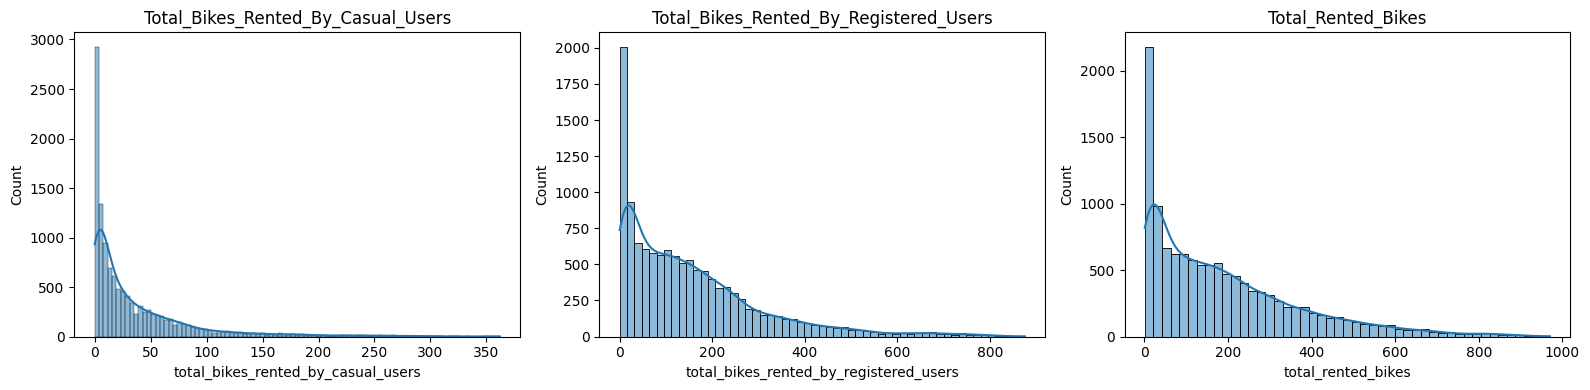

In [ ]:
fig = plt.figure(figsize=(16,4)) # (horizontal, vertikal)
posisi = 1
plt.title('Histogram')
for kolom in num:
  plt.subplot(1,3,posisi) # (berapa baris, berapa kolom, di urutan ke berapa)
  plt.title(f'{kolom.title()}')
  sns.histplot(df[kolom], kde = True) # kernell density estimator
  fig.tight_layout()

  posisi += 1

plt.show()

Berdasarkan plot distribusi permintaan sepeda, terlihat bahwa ketiga variabel memiliki distribusi right-skewed, di mana modus < median < mean. Dengan kata lain, terdapat skewness positif pada fitur terkait permintaan. Untuk memastikan bahwa data tidak berdistribusi normal, kita akan menggunakan D'Agostino and Pearson's Test.

**D'Agostino and Pearson's Test**

In [ ]:
print('Casual Users')
stat, pvalue = normaltest(df['total_bikes_rented_by_casual_users'])
print("p-value =", pvalue)

if pvalue < 0.05:
  print('Tolak H0')
  print('Tidak cukup bukti untuk menyatakan bahwa data tersebut berdistribusi normal\n')
else:
  print('Gagal tolak H0')
  print('Terdapat cukup bukti untuk menyatakan bahwa data berdistribusi normal\n')

print('Regiestered Users')
stat, pvalue = normaltest(df['total_bikes_rented_by_registered_users'])
print("p-value =", pvalue)

if pvalue < 0.05:
  print('Tolak H0')
  print('Tidak cukup bukti untuk menyatakan bahwa data tersebut berdistribusi normal\n')
else:
  print('Gagal tolak H0')
  print('Terdapat cukup bukti untuk menyatakan bahwa data berdistribusi normal\n')

print('Total')
stat, pvalue = normaltest(df['total_rented_bikes'])
print("p-value =", pvalue)

if pvalue < 0.05:
  print('Tolak H0')
  print('Tidak cukup bukti untuk menyatakan bahwa data tersebut berdistribusi normal\n')
else:
  print('Gagal tolak H0')
  print('Terdapat cukup bukti untuk menyatakan bahwa data berdistribusi normal\n')



Casual Users
p-value = 0.0
Tolak H0
Tidak cukup bukti untuk menyatakan bahwa data tersebut berdistribusi normal

Regiestered Users
p-value = 0.0
Tolak H0
Tidak cukup bukti untuk menyatakan bahwa data tersebut berdistribusi normal

Total
p-value = 0.0
Tolak H0
Tidak cukup bukti untuk menyatakan bahwa data tersebut berdistribusi normal



Jadi, ketiga variabel terbukti tidak berdistibusi normal.

## Correlation Heatmap
Kita dapat dengan mudah memvisualisasikan korelasi antara variabel numerik dalam dataset dengan heatmap. Heatmap memberikan representasi visual yang jelas tentang seberapa kuat korelasi antara setiap pasangan variabel numerik.

Selain itu, heatmap juga memungkinkan kita untuk dengan cepat mengidentifikasi pola dan hubungan antara variabel numerik. Ini dapat membantu dalam mengidentifikasi variabel yang paling berpengaruh terhadap variabel target, seperti `total_rented_bikes` dalam kasus ini.

Karena data dari masing-masing variabel tidak berdistribusi normal, kita akan menggunakan metode Spearman Correlation.

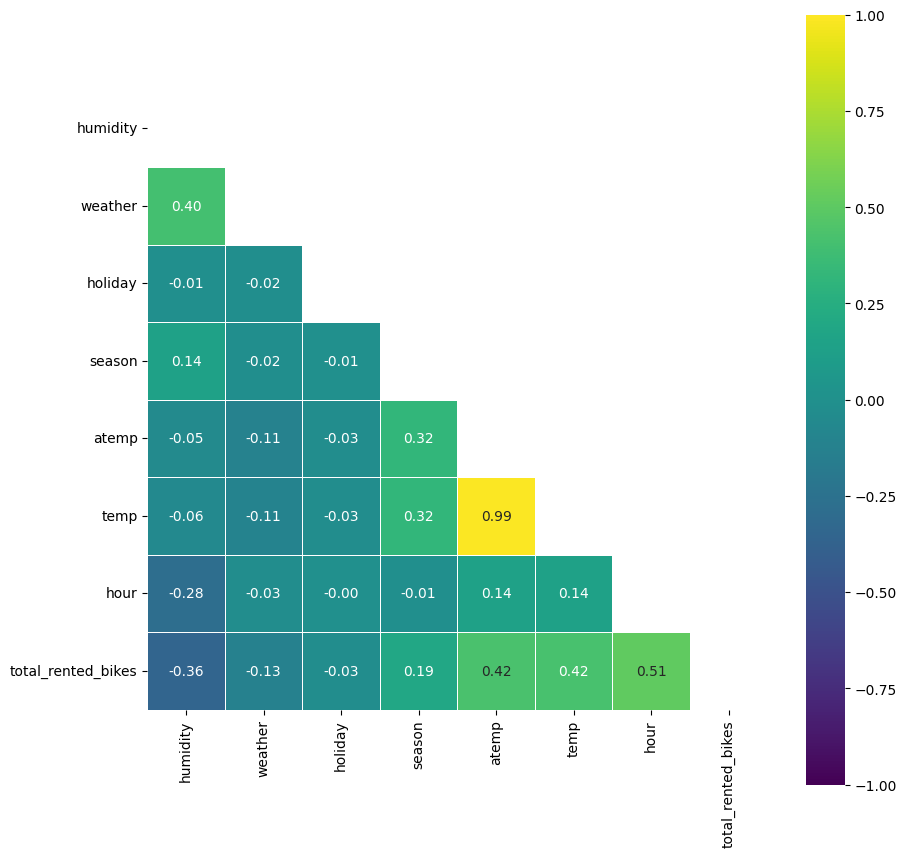

In [ ]:
df_num = df.select_dtypes(include='number')
df_num = df.drop(['total_bikes_rented_by_casual_users', 'total_bikes_rented_by_registered_users', 'dateday'], axis=1)
df_corr = df_num.corr(method = 'spearman')

plt.figure(figsize=(10,10))
mask = np.triu(np.ones_like(df_corr, dtype=bool))
sns.heatmap(df_corr, cmap = 'viridis', vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5, mask = mask)
plt.show()

Dari heatmap di atas, dapat dilihat bahwa ada:
- Ada korelasi moderat positif antara `total_rented_bikes` dengan `atemp`. Artinya, semakin tinggi suhu *feels-like*, semakin tinggi permintaan sepeda rental.
- Ada korelasi moderat positif antara `total_rented_bikes` dengan `hour`. Artinya, semakin siang/sore, semakin tinggi permintaan sepeda rental.
- Terdapat korelasi lemah negatif antara `total_rented_bikes` dengan `humidity`. Artinya, semakin tinggi kelembaban, semakin rendah permintaan sepeda rental.
- Terdapat korelasi positif sangat lemah antara `total_rented_bikes` dengan `season`. Artinya, musim semi, panas, dan gugur memiliki permintaan yang lebih tinggi dibandingkan permintaan pada musim dingin.
- Korelasi `temp` dan `atemp` sangat kuat dan mengindikasikan multikolinearitas. Karena, keduanya mengukur hal yang sama, yaitu suhu. Maka dari itu, kita perlu menghapus salah satunya.

## Demand Analysis


### Demand by Registered and Casual Users
Karena distribusi permintaan sepeda tidak normal, maka kita akan membandingkan demand dari user terdaftar dan casual berdasarkan mediannya.

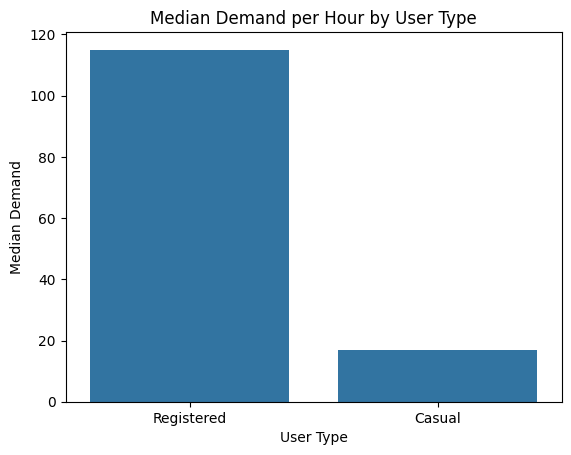

In [ ]:
median_reg = df['total_bikes_rented_by_registered_users'].median()
median_casual = df['total_bikes_rented_by_casual_users'].median()
demand_median = [median_reg, median_casual]

categories = ['Registered', 'Casual']
sns.barplot(x=categories, y=demand_median)
plt.xlabel('User Type')
plt.ylabel('Median Demand')
plt.title('Median Demand per Hour by User Type')
plt.show()

Dari grafik tersebut, terlihat bahwa median jumlah sepeda yang disewa oleh user yang sudah terdaftar jauh lebih besar dibandingkan median jumlah sepeda yang disewa oleh user yang tidak terdaftar. Hal ini mengindikasikan bahwa perusahaan telah berhasil memasang strategi pemasaran yang dapat menarik minat pengguna untuk registrasi.

**Pointplot**

Untuk melihat perbedaan demand penyewaan sepeda di berbagai kondisi, kita bisa menggunakan point plot. Dikutip dari https://seaborn.pydata.org/generated/seaborn.pointplot.html, point plot mewakili estimasi *central tendency* untuk variabel numerik berdasarkan posisi titik dan memberikan beberapa indikasi ketidakpastian di sekitar estimasi tersebut dengan menggunakan *error bar*. Point plot dapat lebih berguna daripada bar plot untuk memfokuskan perbandingan antara tingkat yang berbeda dari satu atau lebih variabel kategorikal. Plot ini sangat mahir dalam menunjukkan interaksi: bagaimana hubungan antara tingkat satu variabel kategorikal berubah di seluruh tingkat variabel kategorikal kedua. Garis-garis yang menghubungkan setiap titik dari level *hue* yang sama memungkinkan interaksi dinilai dari perbedaan kemiringannya, yang lebih mudah dilihat oleh mata daripada membandingkan ketinggian beberapa kelompok titik atau batang.

### Count of rented bikes (hourly)

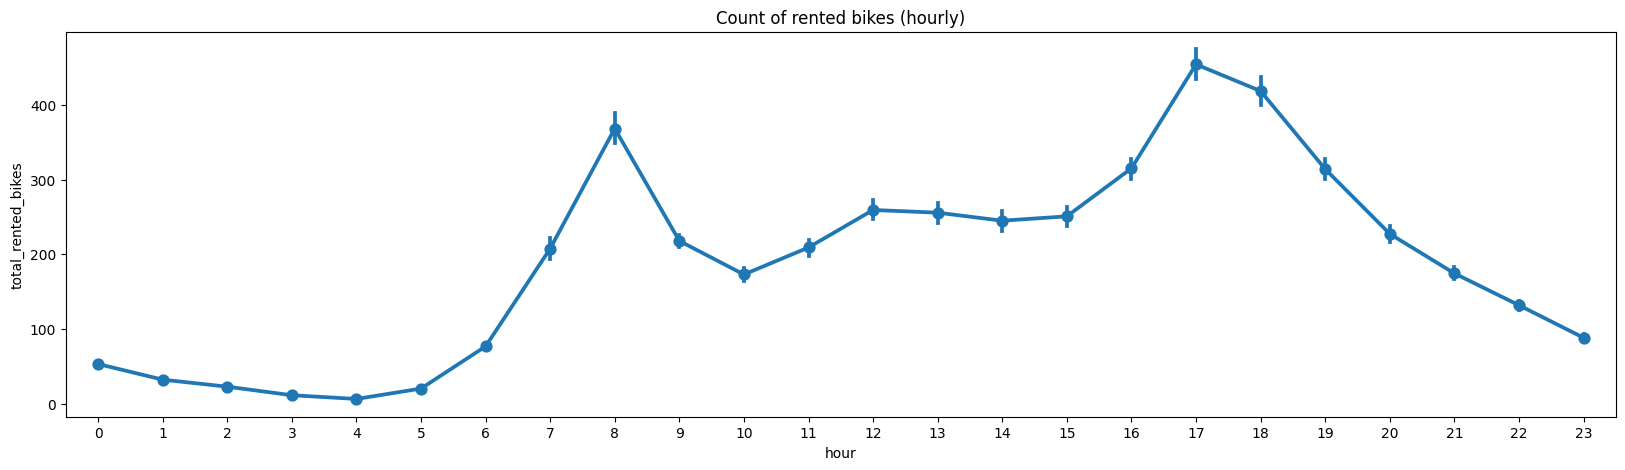

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
sns.pointplot(data=df, x='hour', y='total_rented_bikes', ax=ax)
ax.set(title='Count of rented bikes (hourly)')
plt.show()

Berdasarkan plot di atas, terdapat 3 peak hour, yaitu di pukul 8 pagi serta 17 dan 18 sore. Hal ini kemungkinan besar disebabkan oleh adanya para karyawan yang berangkat dan pulang kantor pada jam tersebut. Alhasil, mereka menyewa sepeda untuk pergi ke tujuan mereka. Maka dari itu, dapat diasumsikan bahwa mayoritas penyewa sepeda adalah karyawan/pekerja.

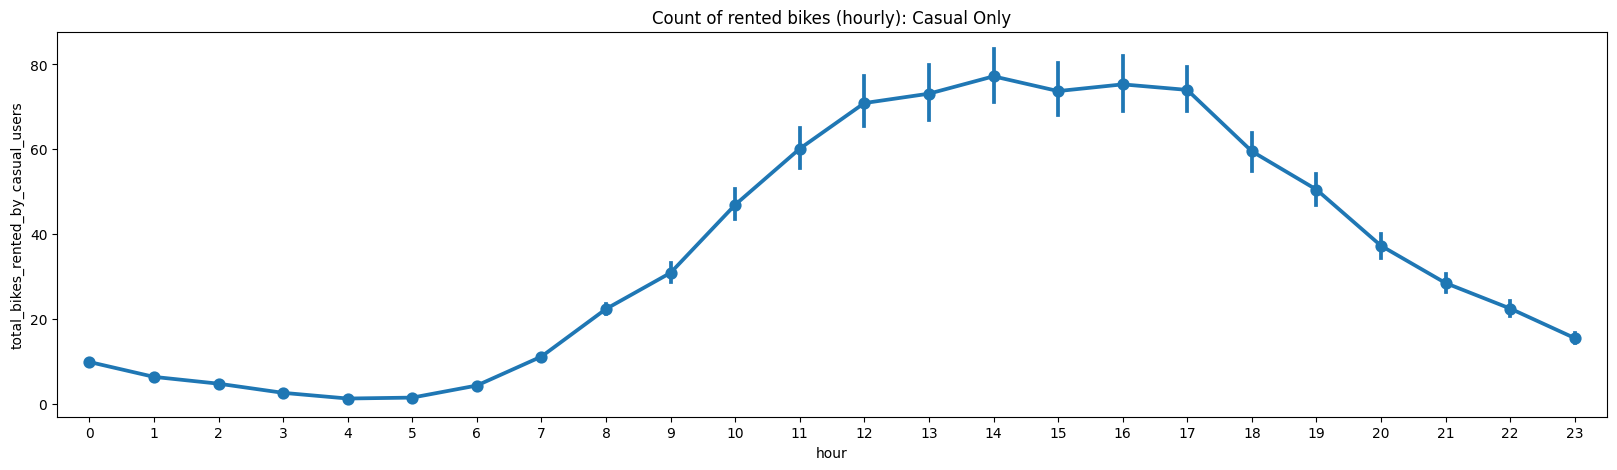

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
sns.pointplot(data=df, x='hour', y='total_bikes_rented_by_casual_users', ax=ax)
ax.set(title='Count of rented bikes (hourly): Casual Only')
plt.show()

Berdasarkan plot di atas, dapat dilihat bahwa banyak sepeda yang dipinjam oleh casual users merangkak naik dari pukul 6-14, kemudian perlahan-lahan turun hingga pukul 4 pagi. Demand tertinggi tercatat pada pukul 14. Pola ini mengindikasikan bahwa pengguna kasual cenderung menyewa sepeda untuk aktivitas yang berkaitan dengan waktu luang di siang hari, mungkin pada saat cuaca lebih hangat dan menyenangkan. Casual user mungkin didominasi oleh turis yang sedang berkunjung di kota ataupun mahasiswa.

### Count of rented bikes based on its holiday status

In [ ]:
df['holiday'].value_counts()

holiday
0    11803
1    362  
Name: count, dtype: int64

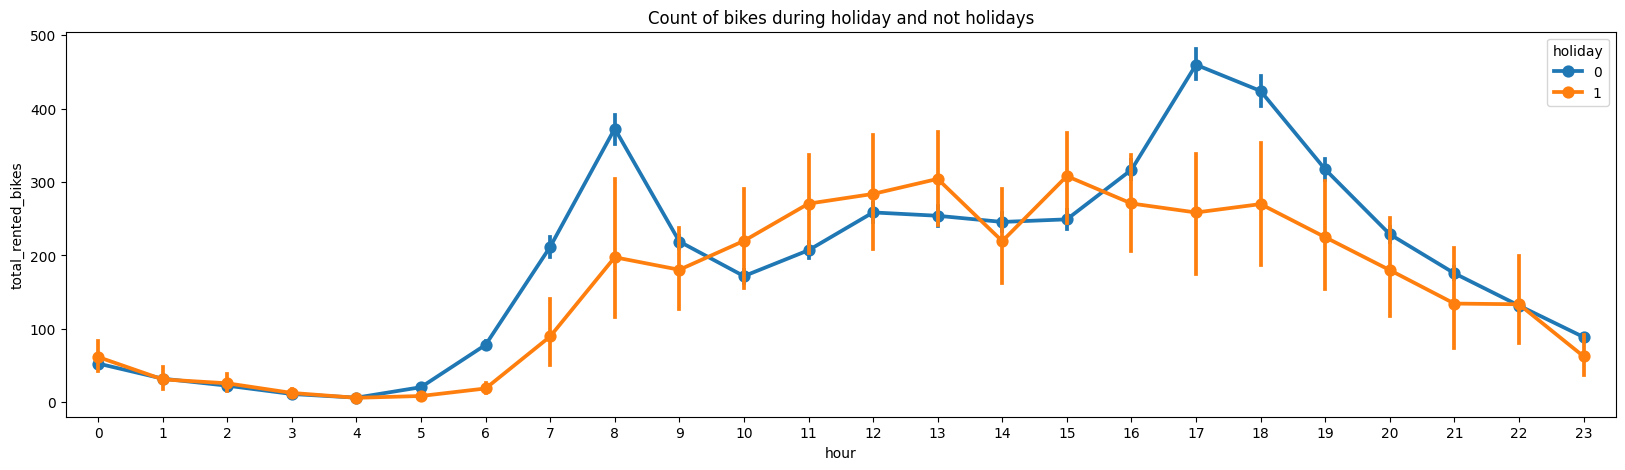

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
sns.pointplot(data=df, x='hour', y='total_rented_bikes', hue='holiday', ax=ax)
ax.set(title='Count of bikes during holiday and not holidays')
plt.show()

- Demand sepeda ketika hari kerja lebih tinggi dibandingkan hari libur. Hal ini memperkuat teori kita yang menyatakan bahwa mayoritas penyewa berstatus karyawan atau pelajar.
- Kemudian, demand tertinggi pada hari libur ada pada pukul 13 dan 15. Hal ini berarti, mayoritas pengguna lebih suka menghabiskan waktu dengan bersepeda pada saat matahari sedang terik-teriknya.

### Count of rented bikes during different seasons

In [ ]:
df['season'].value_counts()

season
3    3169
2    3074
1    3023
4    2899
Name: count, dtype: int64

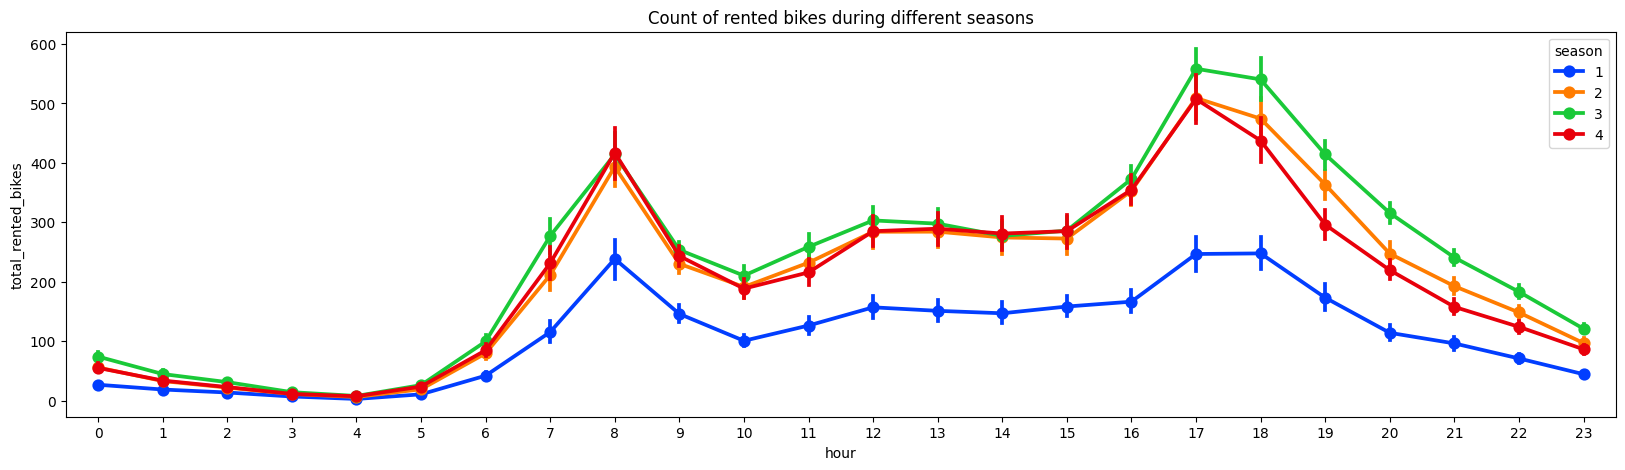

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
sns.pointplot(data=df, x='hour', y='total_rented_bikes', hue='season', ax=ax, palette='bright')
ax.set(title='Count of rented bikes during different seasons')
plt.show()

Dari plot tersebut, dapat kita lihat bahwa musim dengan demand tertinggi adalah musim panas (3) dan semi (2). Di mana seperti yang kita ketahui, orang-orang di Barat lebih suka menghabiskan waktu di luar ruangan ketika musim panas (3) dan semi (2). Musim gugur (4) juga memiliki demand yang sedikit lebih rendah dibandingkan keduanya. Cuaca cerah dan jarak pandang yang luas pada ketiga musim ini juga cocok untuk bersepeda sehingga demand lebih tinggi di musim tersebut.

### Count of rented bikes based on its weather

In [ ]:
df['weather'].value_counts()

weather
1    8071
2    3119
3    972 
4    3   
Name: count, dtype: int64

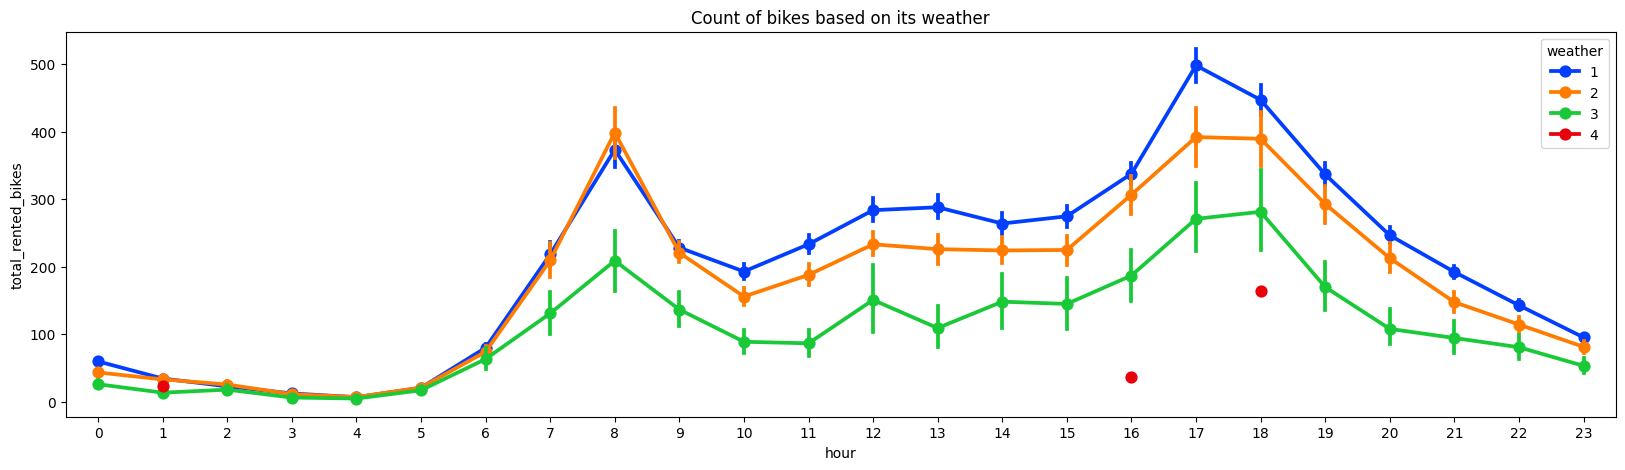

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
sns.pointplot(data=df, x='hour', y='total_rented_bikes', hue='weather', ax=ax, palette='bright')
ax.set(title='Count of bikes based on its weather')
plt.show()

Demand penyewaan sepeda lebih tinggi ketika cuaca cerah (1) atau berawan (2). Cuaca cerah/berawan biasanya berarti tidak ada hambatan seperti hujan atau angin kencang yang bisa membuat berkendara menjadi tidak nyaman. Cuaca cerah/berawan mendukung berbagai aktivitas luar ruang, membuat lebih banyak orang tertarik untuk keluar rumah dan menggunakan sepeda, baik untuk rekreasi maupun transportasi. Visibilitas yang baik selama cuaca cerah/berawan meningkatkan keamanan bagi pengendara sepeda, mengurangi risiko kecelakaan dibandingkan dengan kondisi cuaca yang buruk (seperti 3 dan 4).

Selain itu, hanya ada 3 data dengan `weather` = 4 dan ketiganya memiliki demand yang sangat rendah. Artinya, daerah tersebut tidak sering mengalami hujan deras + badai petir + kabut. Namun, ketika mengalaminya, demandnya sangat rendah dibandingkan ketika cuaca sedang baik.

### Humidity and Temperature relation to Count of Rented Bikes

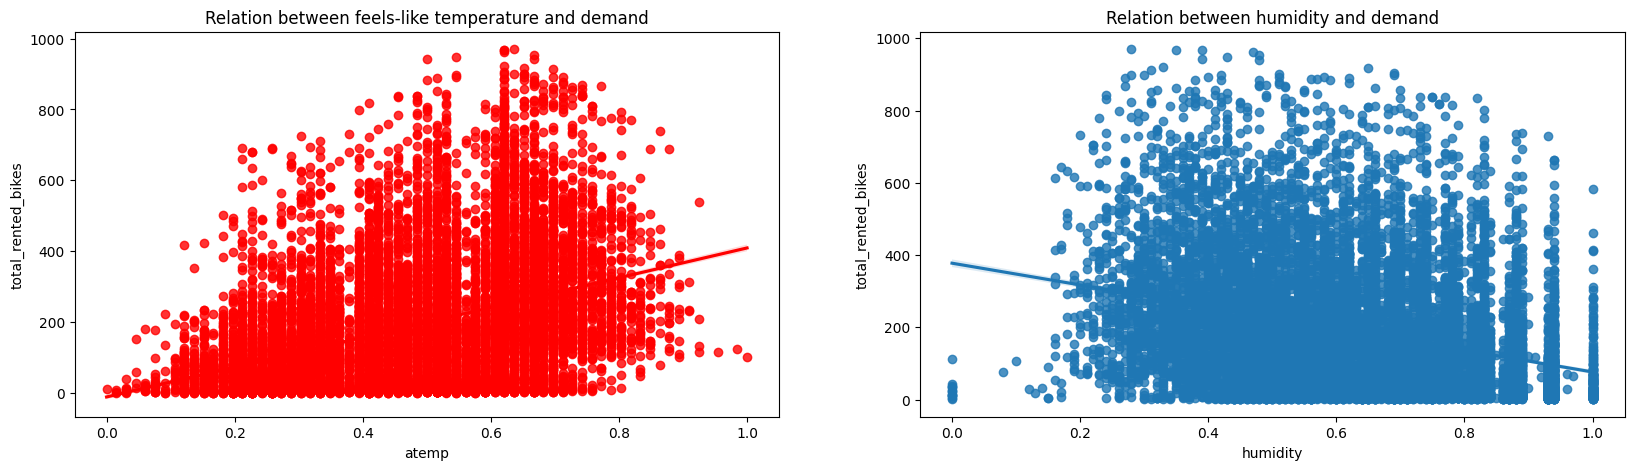

In [ ]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,5))
sns.regplot(x=df['atemp'], y=df['total_rented_bikes'], ax=ax1 ,color='red')
ax1.set(title="Relation between feels-like temperature and demand")
sns.regplot(x=df['humidity'], y=df['total_rented_bikes'], ax=ax2)
ax2.set(title="Relation between humidity and demand")
plt.show()

Dari kedua grafik tersebut, tidak terdapat hubungan yang kuat antara demand dan temperature ataupun humidity. Namun, semakin tinggi temperature, semakin tinggi demand. Selain itu, semakin tinggi kelembaban, semakin rendah demand penyewaan sepeda. Hal ini dapat sebabkan oleh beberapa faktor, salah satunya adalah kelembaban yang tinggi dapat membuat pengguna merasa tidak nyaman dan berkeringat lebih banyak, sehingga dapat mengurangi minat untuk menggunakan sepeda. Kemudian, cuaca yang hangat dan nyaman cenderung meningkatkan minat orang untuk bersepeda karena mereka merasa lebih nyaman. Artinya, para penyewa lebih nyaman bersepeda ketika cuaca sedang terik dan kering.

# Data Preprocessing
Data preprocessing adalah serangkaian proses yang dilakukan pada data mentah untuk mengubahnya menjadi format yang lebih bersih dan lebih siap untuk modelling. Proses ini penting dalam pemodelan machine learning karena kualitas data yang baik adalah prasyarat untuk mendapatkan hasil yang akurat dan efektif.

In [ ]:
df_preprocess = df.copy()

## Changing data types

`dateday`

In [ ]:
df_preprocess['dateday'] = pd.to_datetime(df_preprocess['dateday'], format='%Y-%m-%d')
df_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12165 entries, 0 to 12164
Data columns (total 11 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   dateday                                 12165 non-null  datetime64[ns]
 1   humidity                                12165 non-null  float64       
 2   weather                                 12165 non-null  int64         
 3   holiday                                 12165 non-null  int64         
 4   season                                  12165 non-null  int64         
 5   atemp                                   12165 non-null  float64       
 6   temp                                    12165 non-null  float64       
 7   hour                                    12165 non-null  int64         
 8   total_bikes_rented_by_casual_users      12165 non-null  int64         
 9   total_bikes_rented_by_registered_users  12165 non-

`weather`, `holiday`, and `season`

In [ ]:
df_preprocess['weather'] = df_preprocess['weather'].astype('category')
df_preprocess['holiday'] = df_preprocess['holiday'].astype('category')
df_preprocess['season'] = df_preprocess['season'].astype('category')

## Dropping redundant column


### `temp`
Variabel `atemp` (feels-like temperature) dan `temp` bersifat redundan. Jika salah satunya tidak dihapus, maka akan menimbulkan masalah multikolinearitas.
Menurut [foxweather.com](https://www.foxweather.com/learn/feels-like-temperature-heat-index-wind-chill#:~:text=Basically%2C%20the%20feels%2Dlike%20temperature,even%20the%20amount%20of%20sunshine.), "the feels-like temperature is how hot or how cold the air feels to the human body when factoring in variables such as relative humidity, wind speeds and even the amount of sunshine." Sedangkan, temperatur merupakan kuantitas fisika yang diukur menggunakan termometer di dalam sebuah bilik meteorologis ([windy.app](https://windy.app/blog/feels-like-temperature.html#:~:text=Air%20temperature%20is%20a%20real,air%20humidity%20and%20wind%20speed.)). Dari penjelasan tersebut, kita dapat menyimpulkan bahwa variabel `atemp` lebih relevan untuk dimasukkan ke dalam analisis karena menggambarkan bagaimana suhu dirasakan oleh tubuh manusia, yang secara langsung mempengaruhi keputusan seseorang untuk beraktivitas di luar rumah, termasuk menyewa dan menggunakan sepeda.

In [ ]:
df_preprocess = df_preprocess.drop('temp', axis=1)

### `total_bikes_rented_by_casual_users` and `total_bikes_rented_by_registered_users`
`total_rented_bikes` adalah penjumlahan dari `total_bikes_rented_by_casual_users` dan `total_bikes_rented_by_registered_users`. Jika tidak dihapus, kedua variabel tersebut akan menghasilkan model dengan multikolinieritas dan bias.



In [ ]:
df_preprocess = df_preprocess.drop(['total_bikes_rented_by_casual_users', 'total_bikes_rented_by_registered_users'], axis = 1)
df_preprocess.head()

,dateday,humidity,weather,holiday,season,atemp,hour,total_rented_bikes
0,2011-01-01,0.81,1,0,1,0.2879,0,16
1,2011-01-01,0.80,1,0,1,0.2727,1,40
2,2011-01-01,0.80,1,0,1,0.2727,2,32
3,2011-01-01,0.75,1,0,1,0.2879,3,13
4,2011-01-01,0.75,1,0,1,0.2879,4,1


## Feature Engineering
Model machine learning hanya bisa mempelajari data numerik. Maka dari itu, kita akan mengekstrak informasi numerik dari `dateday` (hari keberapa, tanggal ke berapa, dan tahun berapa) yang dapat membantu model machine learning kita untuk memahami pola tertentu dan memprediksi permintaan sepeda di waktu tertentu.

### Splitting `date` to its corresponding `year`, `month`, and `day`
Selanjutnya, kita akan membuat variabel baru yang berisikan hari, bulan, dan tahun dari tanggal tersebut. Hal ini dilakukan agar model dapat menangkap pola yang terjadi terkait dengan waktu.

In [ ]:
df_preprocess['day'] = df_preprocess['dateday'].dt.day
df_preprocess['month'] = df_preprocess['dateday'].dt.month
df_preprocess['year'] = df_preprocess['dateday'].dt.year

### Creating `day_of_week` column
Selanjutnya, kita juga akan membuat kolom baru yang menandakan hari apa observasi tersebut diambil, di mana 0 = Senin sampai 6 = Minggu.

In [ ]:
df_preprocess['day_of_week'] = df_preprocess['dateday'].dt.dayofweek.astype('category')
df_preprocess

,dateday,humidity,weather,holiday,season,atemp,hour,total_rented_bikes,day,month,year,day_of_week
0,2011-01-01,0.81,1,0,1,0.2879,0,16,1,1,2011,5
1,2011-01-01,0.80,1,0,1,0.2727,1,40,1,1,2011,5
2,2011-01-01,0.80,1,0,1,0.2727,2,32,1,1,2011,5
3,2011-01-01,0.75,1,0,1,0.2879,3,13,1,1,2011,5
4,2011-01-01,0.75,1,0,1,0.2879,4,1,1,1,2011,5
...,...,...,...,...,...,...,...,...,...,...,...,...
12160,2012-12-31,0.45,2,0,1,0.2727,14,247,31,12,2012,0
12161,2012-12-31,0.48,2,0,1,0.2576,16,214,31,12,2012,0
12162,2012-12-31,0.48,2,0,1,0.2879,17,164,31,12,2012,0
12163,2012-12-31,0.60,2,0,1,0.2576,19,119,31,12,2012,0


## Outliers Detection
Outliers seringkali memperluas rentang variansi data, yang meningkatkan standar error dari estimasi. Dengan menghilangkan outliers, variansi data menjadi lebih kecil, yang menghasilkan standar error yang lebih kecil dan interval kepercayaan yang lebih sempit. Hal ini meningkatkan keandalan estimasi yang dihasilkan oleh model statistik.

### Categoric Variables
Pertama-tama, kita akan melihat distribusi dari variabel diskrit.

In [ ]:
list_obj = ['weather', 'holiday', 'season', 'hour', 'day', 'month']

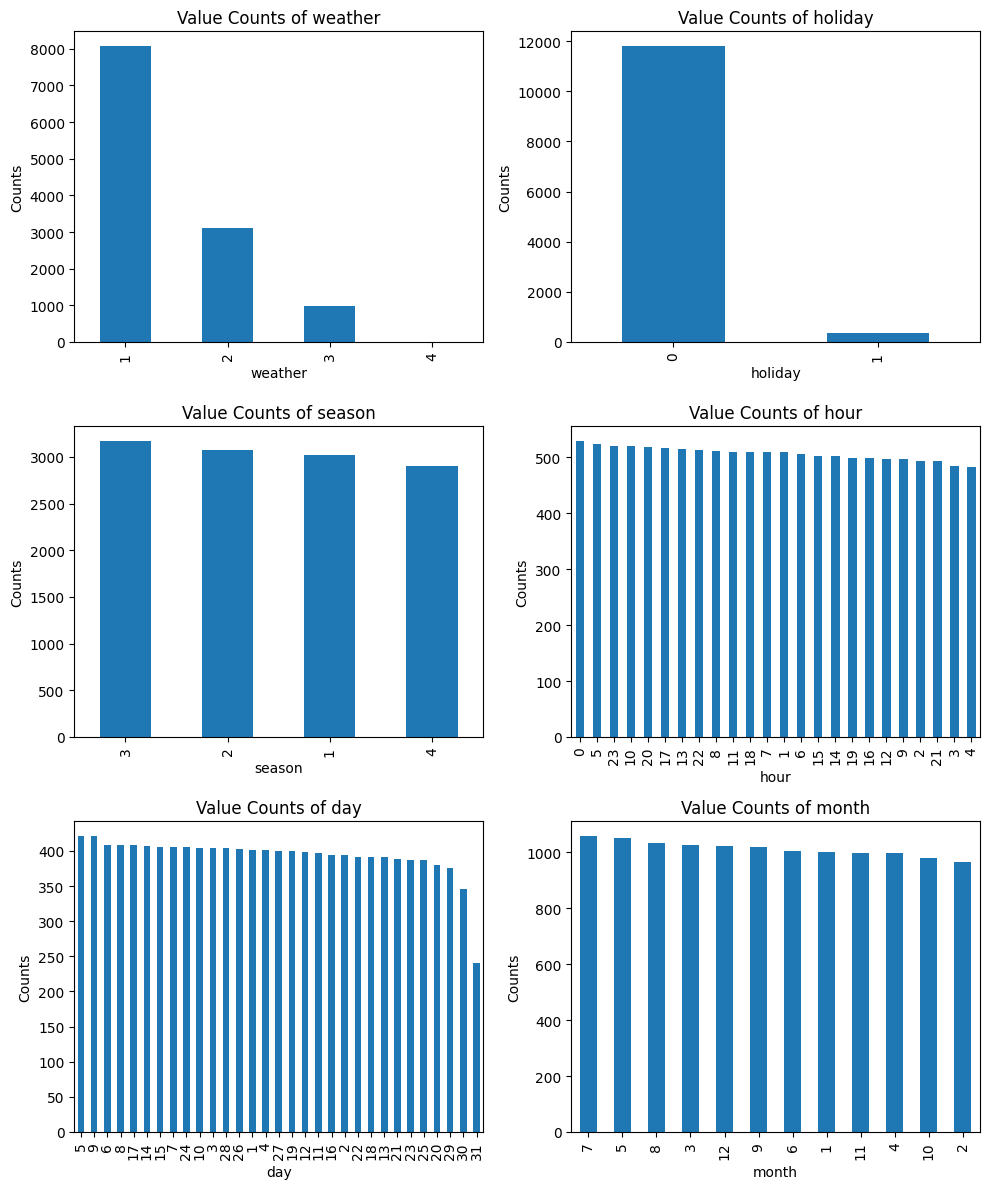

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))
axes = axes.flatten()

for i, column in enumerate(list_obj):
    value_counts = df_preprocess[column].value_counts()
    value_counts.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Value Counts of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Counts')

plt.tight_layout()
plt.show()

Dari hasil tersebut, kita dapat lihat bahwa:
- Data dengan label `weather` = 4 memiliki jumlah yang sangat sedikit. Hal ini dapat disebabkan oleh area/wilayah tersebut yang memang jarang terdampak cuaca ekstrem (hujan deras, badai petir, kabut, badai salju). Karena jumlahnya sangat sedikit dan dianggap sebagai outlier, kita akan menghapus baris data dengan `weather` = 4.
- Terdapat 362 data dengan label `holiday`= 1. Jumlah ini tergolong sedikit karena jumlah tanggal merah dalam setahun memang tidak banyak. Hal ini bukanlah anomali maupun outlier.
- Jumlah data yang berlabel musim panas paling banyak di antara musim lainnya. Hal ini disebabkan oleh musim panas yang umumnya berlangsung lebih lama dibandingkan musim lainnya, yaitu 94 hari (source: [starrynighteducation.com](https://www.starrynighteducation.com/stargazer/1205.shtml#:~:text=Summer%20begins%20when%20the%20sun,longest%20season%2C%20lasting%2094%20days.))
- Pada value_counts() untuk variabel `hour`, kita ketahui bahwa ada hari yang tidak merekam permintaan sepeda di jam tertentu. Akibatnya, jumlah data dari masing-masing jam tidak sama banyak. Hal ini tidak akan memengaruhi hasil analisis, sehingga akan dibiarkan seperti itu.
- Variabel lainnya memiliki distribusi yang seimbang.

Hapus baris dengan label `weather` = 4

In [ ]:
df_preprocess = df_preprocess[df_preprocess['weather'] != 4]
df_preprocess['weather'].value_counts()

weather
1    8071
2    3119
3    972 
4    0   
Name: count, dtype: int64

### Numeric Variable

In [ ]:
df_num = df_preprocess.select_dtypes(include='number')

# Keluarkan variabel kategorik dari df_num
df_num = df_num.drop(['day', 'month', 'year'], axis=1)

<Axes: >

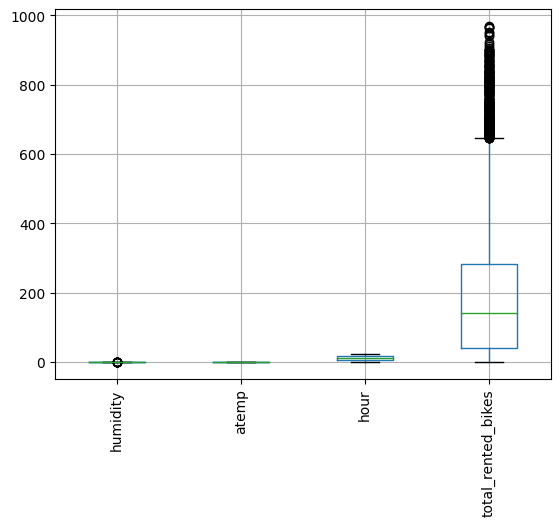

In [ ]:
df_num.boxplot(rot=90)

In [ ]:
# menampilkan proporsi outlier secara detail pada variabel numerikal
numerical_features = ['humidity', 'atemp', 'hour', 'total_rented_bikes']
list_lower = []
list_upper = []
number_lower = []
number_inside = []
number_upper = []
percentage_outlier = []

for feature in numerical_features:
    IQR = df_preprocess[feature].quantile(0.75) - df_preprocess[feature].quantile(0.25)
    lower_bound = df_preprocess[feature].quantile(0.25) - 1.5 * IQR
    upper_bound = df_preprocess[feature].quantile(0.75) + 1.5 * IQR
    list_lower.append(lower_bound)
    list_upper.append(upper_bound)
    number_lower.append(len(df_preprocess[df_preprocess[feature] < lower_bound]))
    number_inside.append(len(df_preprocess[(df_preprocess[feature] >= lower_bound) & (df_preprocess[feature] <= upper_bound)]))
    number_upper.append(len(df_preprocess[df_preprocess[feature] > upper_bound]))
    percentage_outlier.append(round((len(df_preprocess[df_preprocess[feature] < lower_bound]) + len(df_preprocess[df_preprocess[feature] > upper_bound])) / len(df_preprocess) * 100, 2))

outliers = pd.DataFrame({
    "Attribute (Numerical Features)" : numerical_features,
    "Lower Bound" : list_lower,
    "Upper Bound" : list_upper,
    "# Lower" : number_lower,
    "# Inside" : number_inside,
    "# Upper" : number_upper,
    "% Outlier" : percentage_outlier})

outliers

,Attribute (Numerical Features),Lower Bound,Upper Bound,# Lower,# Inside,# Upper,% Outlier
0,humidity,0.00500,1.24500,14,12148,0,0.12
1,atemp,-0.09855,1.05305,0,12162,0,0.00
2,hour,-12.00000,36.00000,0,12162,0,0.00
3,total_rented_bikes,-323.00000,645.00000,0,11824,338,2.78


* Variabel `humidity` memiliki 14 data yang berada di bawah lower bound. Artinya, terdapat hari-hari yang lebih kering dari biasanya.
* Variabel `total_rented_bikes` memiliki 338 data di atas upper bound.

In [ ]:
df_preprocess['total_rented_bikes'].describe()

count    12162.000000
mean     189.299375  
std      181.234506  
min      1.000000    
25%      40.000000   
50%      142.000000  
75%      282.000000  
max      970.000000  
Name: total_rented_bikes, dtype: float64

In [ ]:
df_preprocess['humidity'].describe()

count    12162.000000
mean     0.625387    
std      0.192083    
min      0.000000    
25%      0.470000    
50%      0.620000    
75%      0.780000    
max      1.000000    
Name: humidity, dtype: float64

- Terlihat bahwa 75% data pada kolom `total_rented_bikes` memiliki demand kurang dari 282 sepeda/jam, sedangkan demand paling tinggi adalah 970 sepeda/jam. Sehingga, terdapat skewness pada distribusinya, yaitu tail yang memanjang di sebelah kanan (positive skewness). Skewness yang berlebihan dapat mempengaruhi analisis dan mengakibatkan estimasi yang bias, terutama dalam model yang mengasumsikan distribusi simetris.
- Terdapat 338 data yang demandnya melebihi 645 sepeda/jam (batas atas berdasarkan metode IQR). Untuk mendapatkan model dengan performa yang optimal, **kita akan membuat dua model, yaitu model dengan outliers dan model dengan data tanpa outliers.**

- Begitu pula dengan `humidity`. Kita akan mencoba membuat model dengan data tanpa outliers.

#### Cleaned Data with outliers

Copy df_preprocess dan hapus kolom `dateday`

In [ ]:
df_preprocess = df_preprocess.drop('dateday', axis=1)
df_clean_outliers = df_preprocess.copy()
df_clean_outliers

,humidity,weather,holiday,season,atemp,hour,total_rented_bikes,day,month,year,day_of_week
0,0.81,1,0,1,0.2879,0,16,1,1,2011,5
1,0.80,1,0,1,0.2727,1,40,1,1,2011,5
2,0.80,1,0,1,0.2727,2,32,1,1,2011,5
3,0.75,1,0,1,0.2879,3,13,1,1,2011,5
4,0.75,1,0,1,0.2879,4,1,1,1,2011,5
...,...,...,...,...,...,...,...,...,...,...,...
12160,0.45,2,0,1,0.2727,14,247,31,12,2012,0
12161,0.48,2,0,1,0.2576,16,214,31,12,2012,0
12162,0.48,2,0,1,0.2879,17,164,31,12,2012,0
12163,0.60,2,0,1,0.2576,19,119,31,12,2012,0


#### Cleaned Data without outliers

Copy df_preprocess. Setelah itu hapus outliers berdasarkan upper dan lower bound.

In [ ]:
df_clean_wo_outliers = df_preprocess.copy()
df_clean_wo_outliers = df_clean_wo_outliers[df_clean_wo_outliers['total_rented_bikes'] <= 645]
df_clean_wo_outliers = df_clean_wo_outliers[df_clean_wo_outliers['humidity'] >= 0.005]
df_clean_wo_outliers

,humidity,weather,holiday,season,atemp,hour,total_rented_bikes,day,month,year,day_of_week
0,0.81,1,0,1,0.2879,0,16,1,1,2011,5
1,0.80,1,0,1,0.2727,1,40,1,1,2011,5
2,0.80,1,0,1,0.2727,2,32,1,1,2011,5
3,0.75,1,0,1,0.2879,3,13,1,1,2011,5
4,0.75,1,0,1,0.2879,4,1,1,1,2011,5
...,...,...,...,...,...,...,...,...,...,...,...
12160,0.45,2,0,1,0.2727,14,247,31,12,2012,0
12161,0.48,2,0,1,0.2576,16,214,31,12,2012,0
12162,0.48,2,0,1,0.2879,17,164,31,12,2012,0
12163,0.60,2,0,1,0.2576,19,119,31,12,2012,0


Setelah outliersnya dihapus, kita memiliki 11,810 baris data dengan 11 kolom.

Sekarang kita akan memperhatikan bagaimana distribusi data setelah outliers dihapus.

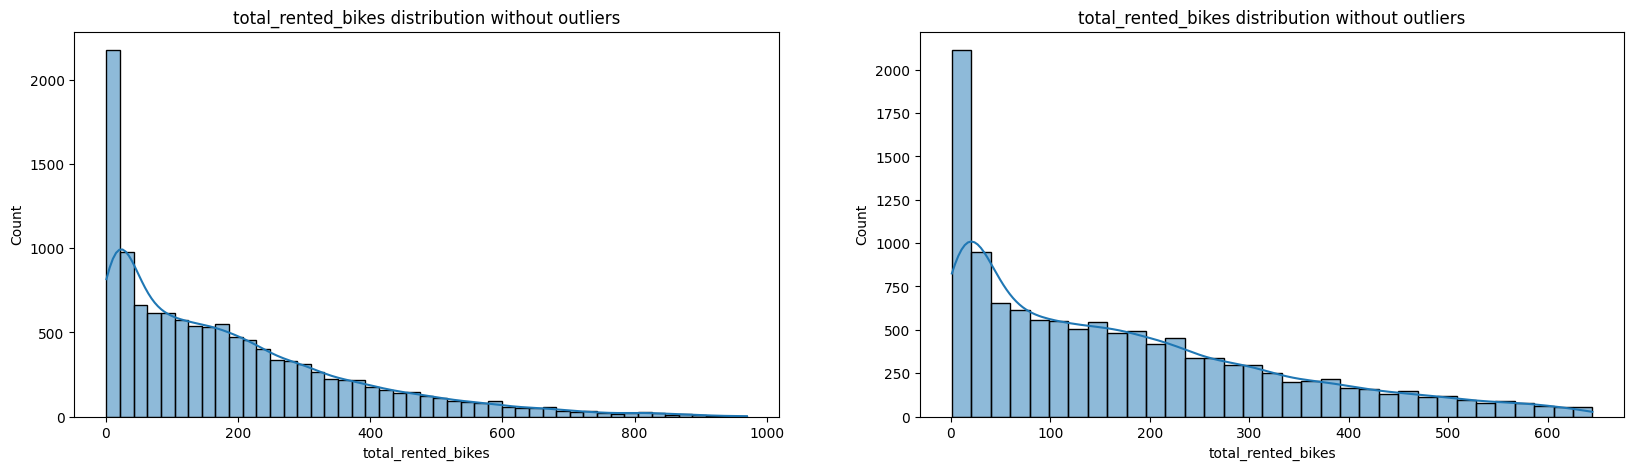

In [ ]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,5))
sns.histplot(df_clean_outliers['total_rented_bikes'], kde = True, ax=ax1)
ax1.set(title="total_rented_bikes distribution without outliers")
sns.histplot(df_clean_wo_outliers['total_rented_bikes'], kde = True, ax=ax2)
ax2.set(title="total_rented_bikes distribution without outliers")
plt.show()

Setelah outliers dihapus, terlihat bahwa skewness distribusi jadi berkurang. Namun, distribusi masih memiliki karakteristik modus < median < mean.


# Modelling

## Models


Ada beberapa model yang akan digunakan dalam pemodelan ini, yaitu:
1. **Multiple Linear Regression**

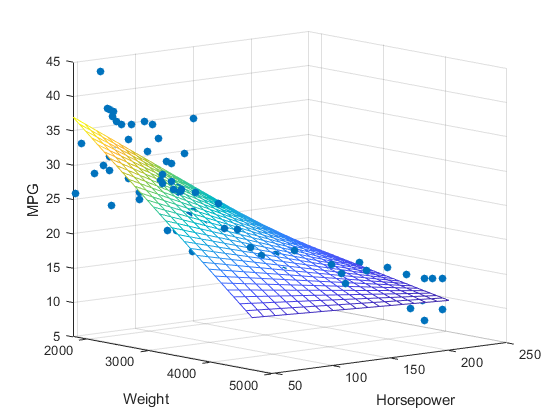
- Multiple Linear Regression adalah ekstensi dari simple linear regression ke beberapa variabel independen. Model ini juga merupakan model parametrik yang memiliki asumsi. Model ini mengasumsikan bahwa hubungan antara variabel dependen (y) dan variabel independen (X1, X2, ..., Xn) adalah linear. Persamaan dari multiple linear regression adalah y = β0 + β1X1 + β2X2 + ... + βnXn + ε, di mana β0 adalah intercept, β1, β2, ..., βn adalah koefisien untuk variabel independen, dan ε adalah error. Model ini meminimalkan jumlah kuadrat residu (sum of squared residuals), yang merupakan perbedaan antara nilai observasi dan nilai yang diprediksi oleh model. Linear regression sangat berguna karena hasilnya yang mudah diinterpretasikan dan cocok untuk situasi di mana hubungan antar variabel diharapkan linear.
- Namun, Linear Regression sensitif terhadap outlier yang bisa sangat mempengaruhi slope dari regresi yang dihasilkan, dan asumsi linearitas yang kuat mungkin tidak selalu sesuai dalam praktik nyata. Model ini juga menghadapi masalah multicollinearity, di mana dua atau lebih variabel independen sangat berkorelasi, membuat interpretasi dari beberapa koefisien menjadi sulit atau tidak stabil. Oleh karena itu, diperlukan analisis lebih lanjut atau modifikasi model seperti Ridge atau Lasso untuk mengatasi isu-isu tersebut.


2. **Ridge Regression**
- Ridge Regression (atau Tikhonov regularization) adalah metode parametrik dan digunakan untuk menganalisis data regresi dengan multikolinearitas, yaitu situasi di mana variabel independen sangat berkorelasi. Ini adalah perluasan dari regresi linier yang mencakup istilah regularisasi L2. Regularisasi adalah teknik yang digunakan untuk mencegah overfitting dengan menambahkan penalti pada ukuran koefisien dalam cost function regresi. Dalam ridge regression, cost function diubah dengan menambahkan istilah penalti yang proporsional dengan kuadrat besar dari magnitude koefisien (norma L2). Ridge regression meminimalkan cost function ini:
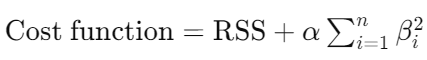
- Di mana RSS adalah sum of squares error, β adalah koefisien, dan α adalah parameter yang menentukan kekuatan penalti regularisasi, yang harus ditetapkan lebih dahulu. Penambahan istilah penalti ini mendorong pembelajaran model yang lebih kecil (kontraksi) koefisien, yang secara efektif mengurangi kompleksitas model. Ridge regression sangat berguna ketika kita memiliki variabel prediktor yang sangat berkorelasi (multikolinearitas) atau ketika jumlah variabel independen melebihi jumlah observasi. Keunggulan utama dari ridge regression adalah bahwa ia dapat menyediakan solusi yang stabil dan terbiasa, tetapi kelemahannya adalah ia tidak melakukan seleksi variabel secara otomatis; semua variabel dipertahankan dalam model akhir.

3. **Lasso Regression**
- Lasso Regression (Least Absolute Shrinkage and Selection Operator) adalah metode parametrik dan merupakan jenis regresi yang melakukan regularisasi L1, di mana sebuah penalti yang setara dengan jumlah nilai absolut dari koefisien diterapkan. Tujuan dari Lasso adalah untuk memperoleh subset dari prediktor yang meminimalkan kesalahan prediksi dengan mengonstruksi model yang lebih interpretatif dengan mengurangi jumlah variabel. Cost function dalam Lasso adalah sebagai berikut:

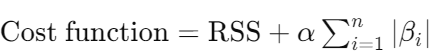
- Lasso cenderung membuat koefisien dari variabel prediktor yang kurang penting menjadi nol, sehingga melakukan seleksi fitur secara otomatis dan menghasilkan model yang lebih sederhana dan mudah diinterpretasikan. Lasso sangat berguna ketika kita memiliki banyak variabel, dan banyak dari variabel tersebut tidak penting untuk model prediktif. Keuntungan utama dari Lasso adalah kemampuannya untuk melakukan seleksi fitur yang secara inheren membangun model yang lebih sederhana dan kurang rentan terhadap overfitting. Namun, Lasso bisa kewalahan jika jumlah variabel sangat besar atau jika hubungan antar variabel sangat kompleks, di mana Lasso mungkin tidak dapat menangkap pola data dengan efektif.

4. **Decision Tree Regressor**

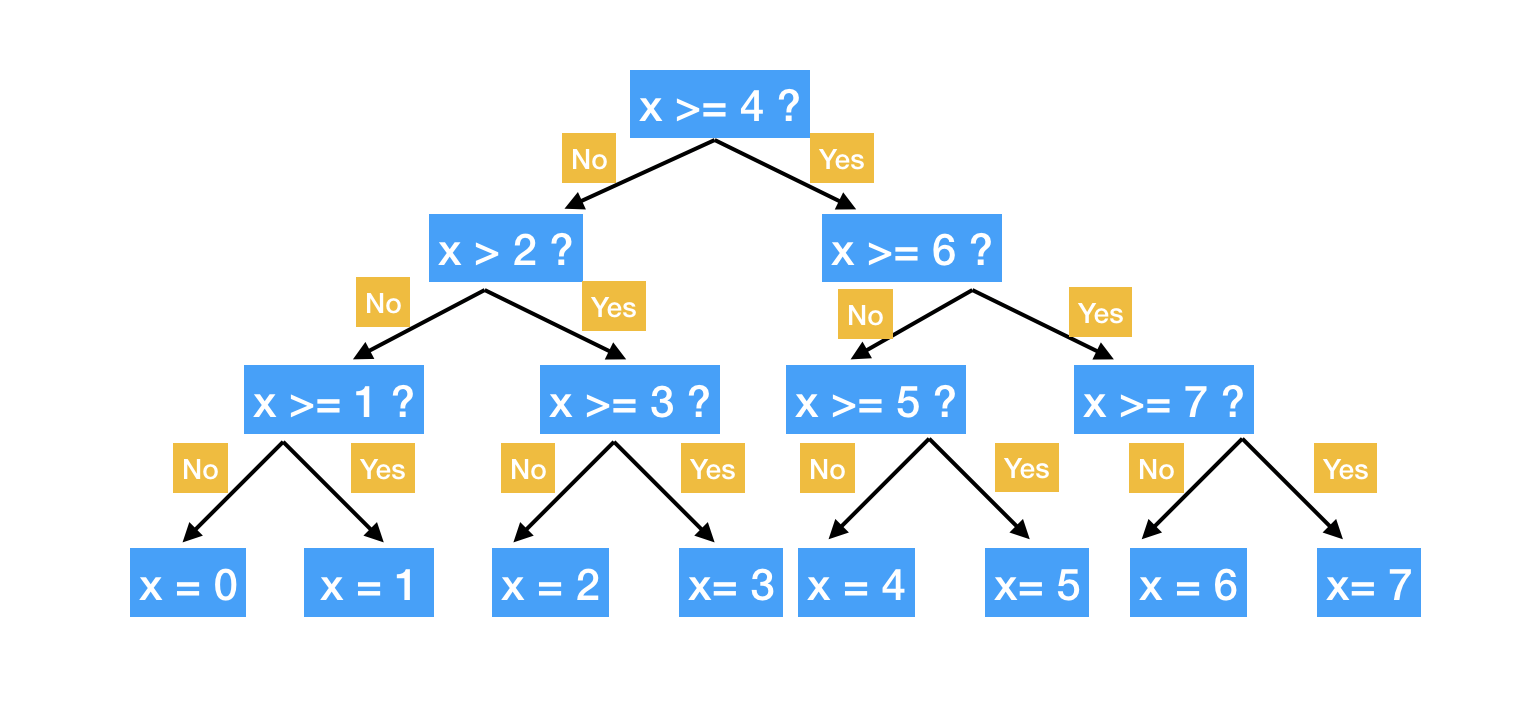
- Decision Tree Regressor merupakan model non-parametrik (tidak memiliki asumsi yang harus dipenuhi) bekerja dengan membuat model prediksi dalam bentuk struktur decision tree. Prosesnya melibatkan pemecahan data menjadi sub kelompok yang lebih kecil dan lebih homogen berdasarkan fitur yang paling informatif yang menghasilkan pengurangan maksimum dalam variasi (atau entropi, Gini impurity, dll. dalam konteks klasifikasi). Setiap node dalam tree mewakili fitur dalam dataset, dan setiap cabang mewakili keputusan yang membagi data menjadi lebih homogen antar grup dari segi variabel respon. Proses pemecahan ini berlanjut secara rekursif hingga kriteria berhenti terpenuhi (misalnya, kedalaman maksimum tercapai, atau peningkatan minimum dalam homogenitas setelah pemecahan).
- Keunggulan Decision Tree termasuk kemampuannya untuk menangani data numerik dan kategorikal, serta tidak memerlukan normalisasi data. Decision tree juga mudah untuk diinterpretasikan dan dapat memvisualisasikan bagaimana keputusan dibuat. Namun, DT sangat rentan terhadap overfitting, terutama jika tree dibiarkan memiliki node yang sangat banyak. Decision tree juga bisa menjadi tidak stabil karena perubahan kecil dalam data bisa mengakibatkan tree yang sangat berbeda. Oleh karena itu, biasanya lebih baik menggunakan ensemble of trees, seperti dalam Random Forest atau boosted trees, untuk mengatasi kelemahan ini.

5. **Random Forest Regressor**

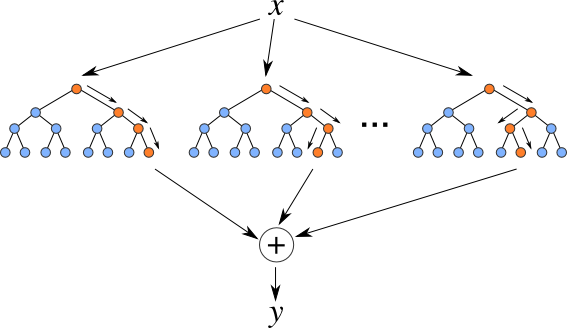
- Random Forest adalah metode non-parametrik (tidak memiliki asumsi yang harus dipenuhi) dan metode ensemble learning yang bekerja dengan menggabungkan prediksi dari banyak decision trees yang dilatih pada subset acak dari data dengan penggantian (bagging). Setiap pohon dalam hutan acak dibangun dari sampel data yang diambil dengan penggantian dari dataset pelatihan. Selain itu, pada setiap node dari pohon, pemilihan pemisahan hanya dilakukan dari subset acak dari fitur, bukan dari semua fitur yang tersedia. Ini meningkatkan keberagaman di antara pohon-pohon dalam model, yang mengurangi risiko overfitting dan meningkatkan akurasi prediksi keseluruhan.
- Random Forest memiliki banyak keunggulan, termasuk kemampuannya untuk memberikan estimasi yang sangat akurat dan robust terhadap overfitting. Model ini efektif pada dataset besar dengan dimensi tinggi dan dapat menangani missing values serta variabel dalam berbagai skala. Namun, kelemahannya termasuk kompleksitas yang lebih tinggi yang bisa membuat model lebih sulit untuk diinterpretasikan dibandingkan dengan single decision tree. Selain itu, meskipun lebih efisien dari segi komputasi daripada beberapa metode lain untuk dataset besar, waktu pelatihan bisa cukup lama karena kompleksitas dari banyak pohon yang dibangun.

6. **XGBoost Regressor**

- XGBoost (eXtreme Gradient Boosting) adalah model non-parametrik (tidak memiliki asumsi yang harus dipenuhi) dan implementasi dari gradient boosted decision trees yang dirancang untuk kecepatan dan performa. XGBoost menyediakan platform yang sangat efisien untuk mengembangkan model ensemble yang berbasis pohon melalui teknik boosting. Dalam boosting, model dibangun secara berurutan; setiap model baru belajar dari kesalahan yang dibuat oleh model sebelumnya dan mencoba memperbaikinya. XGBoost mengoptimalkan algoritma gradient boosting konvensional melalui teknik seperti regularisasi (L1 dan L2), yang membantu mencegah overfitting dan membuat model lebih robust.
- Keunggulan XGBoost meliputi efisiensinya yang tinggi, skalabilitas, dan kemampuan untuk menangani berbagai jenis data tabular. Algoritma ini juga menawarkan fleksibilitas dalam penyesuaian model melalui berbagai hyperparameter, yang memungkinkan pengguna untuk mendapatkan performa optimal. Namun, XGBoost memerlukan penyetelan yang cermat dari hyperparameter untuk menghindari overfitting. Selain itu, meskipun modelnya akurat, interpretasi dari model ensemble yang kompleks ini bisa menjadi tantangan.

7. **Bagging Regressor**
- Bagging Regressor adalah metode untuk meningkatkan akurasi prediksi dalam model machine learning dengan cara melatih beberapa model secara terpisah pada bagian data yang acak dan kemudian menggabungkan prediksinya. Metode ini menggunakan sampling dengan pengembalian dari dataset utama untuk menghasilkan sampel-sampel baru, dan setiap model dilatih pada salah satu dari sampel tersebut. Setelah itu, hasil dari semua model diambil rata-ratanya untuk mendapatkan prediksi akhir. Teknik ini sangat efektif untuk mengurangi kesalahan prediksi yang sering terjadi karena overfitting, yaitu ketika model terlalu cocok dengan data latih hingga tidak efektif pada data baru. Bagging biasanya dilakukan dengan model yang sama, seperti decision tree, dan cocok untuk situasi di mana keakuratan prediksi adalah sangat penting.
- Pada kasus ini kita akan menggunakan XGB Regressor karena performanya yang seringkali sangat baik dan terhindar dari overfitting karena adanya reg_alpha dan reg_lambda.

8. **Voting Regressor**


- Voting Regressor adalah ensemble machine learning tipe various type, di mana kita dapat menggunakan beberapa tipe algoritma yang tidak setipe. Metode ini menggabungkan prediksi dari beberapa model regresi yang berbeda untuk meningkatkan keakuratan prediksi secara keseluruhan. Voting Regressor merata-ratakan hasil prediksi dari tiap model. Ini menghasilkan output akhir yang merupakan rata-rata prediksi dari semua model yang terlibat dalam training. Averaging membantu mengurangi varians dan bias yang mungkin dihasilkan oleh model individu, sehingga meningkatkan stabilitas prediksi keseluruhan. Voting Regressor dipilih karena seringkali menghasilkan prediksi yang lebih akurat daripada model individu.
- Pada kasus ini, kita akan menggunakan XGB Regressor, Random Forest Regressor, dan Bagging Regressor. 1) XGBoost Regressor dipilih sebagai salah satu model karena mengimplementasikan teknik perbaikan pada Gradient Boosting, termasuk regularisasi (L1 & L2) yang mengurangi overfitting dan meningkatkan performa keseluruhan. 2) Sebagai pengembangan dari decision trees, Random Forest menggunakan teknik bagging untuk membuat banyak trees dari sampel acak dataset, mengurangi varians tanpa menambah bias yang signifikan, membuat model lebih stabil dan akurat. 3) Proses pembuatan model bisa diparalelisasi sepenuhnya karena masing-masing instance dari model base learner di-fit secara independen.

## Preprocessing Pipeline

### **OneHot Encoding**
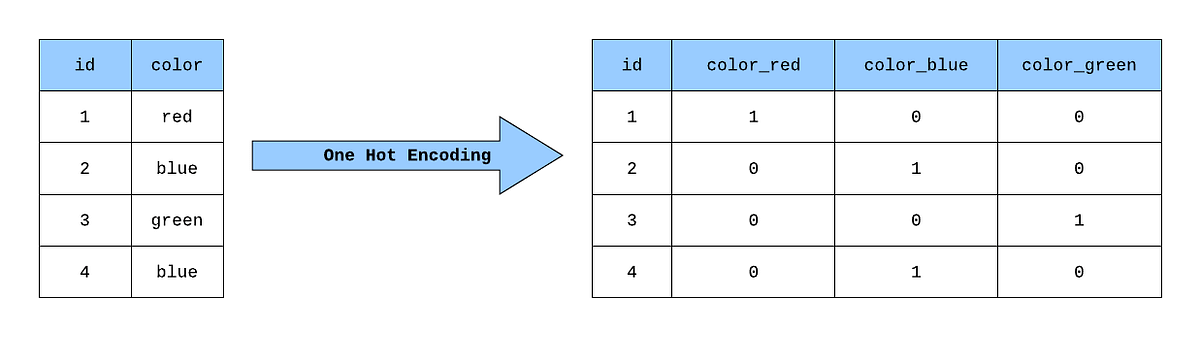
One Hot Encoding adalah teknik preprocessing untuk mengubah variabel kategorikal menjadi bentuk numerik yang dapat diproses oleh algoritma machine learning. Setiap kategori dalam variabel tersebut diwakili sebagai vektor biner dengan panjang sesuai jumlah kategori di variabel tersebut, di mana hanya satu elemen yang aktif (1) dan sisanya nol (0).

One Hot Encoding penting dilakukan karena banyak algoritma pembelajaran mesin tidak dapat menangani variabel kategorikal secara langsung. Algoritma machine learning membutuhkan input numerik. Menggunakan One Hot Encoding memungkinkan pemodelan tanpa mengasumsikan suatu urutan pada kategori, yang mungkin tidak ada, dan membantu algoritma untuk memahami dan menggunakan informasi tersebut secara efektif.

### **Cross Validation**

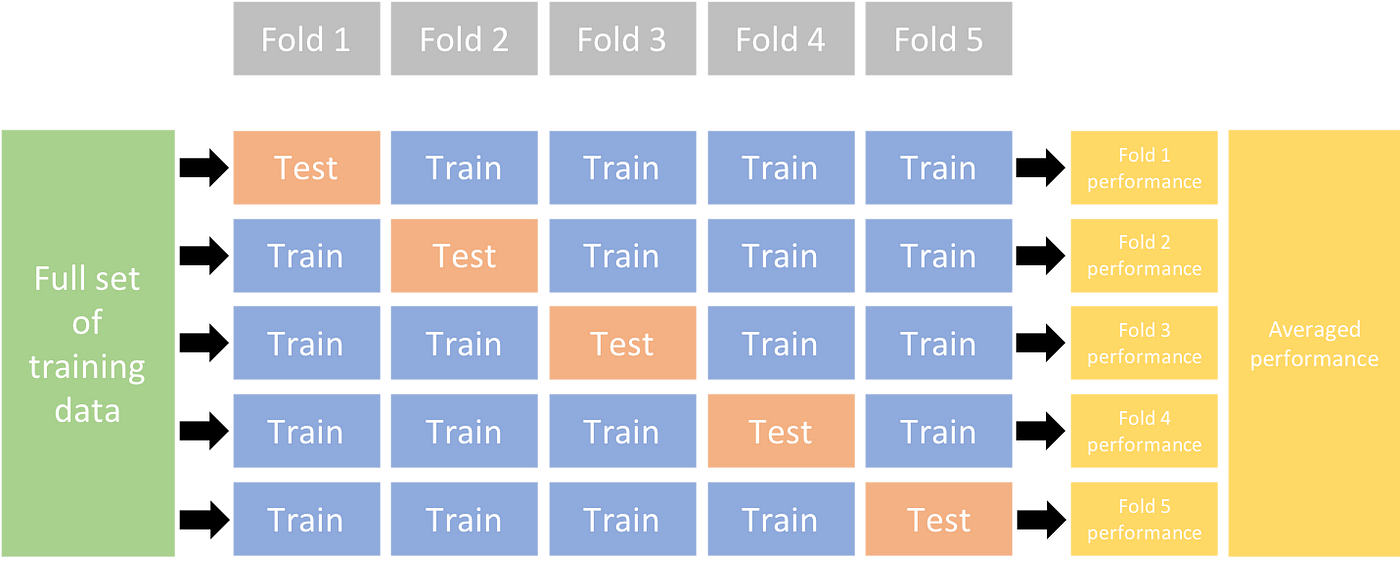

Cross Validation adalah teknik statistik yang digunakan untuk menilai seberapa baik model prediktif dapat bekerja pada set data yang belum dilihat oleh model. Cross validation melibatkan pembagian data menjadi beberapa segmen; model dilatih pada segmen-segmen tersebut kecuali satu yang digunakan sebagai test set. Proses ini diulang sehingga setiap segmen telah digunakan sebagai test set.

Menggunakan n_splits=6 dalam cross-validation berarti data akan dibagi menjadi enam bagian. Alasan pemilihan jumlah splits ini bisa bervariasi, namun secara umum, ini memberikan keseimbangan yang baik antara ukuran set pelatihan dan validitas statistik — semakin banyak splits, semakin akurat penilaian model, tapi juga semakin meningkat komputasi yang dibutuhkan. Jumlah splits harus dipilih berdasarkan ukuran dataset dan sumber daya komputasi yang tersedia. Melakukan cross-validation penting untuk memastikan bahwa model tidak hanya sesuai dengan data training (overfitting), tetapi juga dapat bekerja dengan baik pada data yang tidak terlihat, meningkatkan kemungkinan model akan bekerja dengan baik dalam kondisi nyata.

### **StandardScaler**

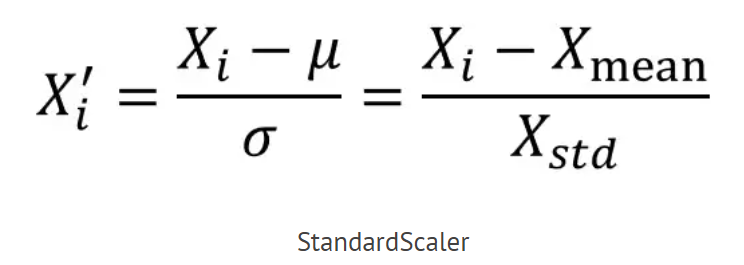

StandardScaler adalah metode preprocessing yang digunakan untuk menormalkan distribusi fitur dengan menghapus mean dan scaling ke unit variance. Dengan kata lain, ini mengubah data sedemikian rupa sehingga memiliki mean (rata-rata) nol dan deviasi standar satu.

Pentingnya StandardScaler muncul dalam algoritma yang sensitif terhadap variasi dalam skala input, seperti regresi linear, logistic regression, dan machine learning berbasis gradient. Scaling membantu menghindari bias yang algoritma mungkin buat terhadap fitur dengan variasi yang lebih besar dan memastikan bahwa konvergensi lebih cepat selama proses pembelajaran, terutama dalam metode yang menggunakan gradient descent sebagai teknik optimisasi.

## Evaluation Metrics

In [ ]:
def rmsle(predictions, targets):
    """Calculate the root mean squared logarithmic error between predictions and targets"""
    return np.sqrt(np.mean((np.log(predictions + 1) - np.log(targets + 1)) ** 2))
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

Dalam pemodelan ini, terdapat 6 metrics yang digunakan untuk mengevaluasi masing-masing model.
- RMSLE (Root Mean Squared Log Error) menghitung logaritma dari nilai prediksi dan nilai sebenarnya sebelum menghitung akar kuadrat dari rata-rata kesalahan kuadrat. Hal ini membuat RMSLE khususnya berguna untuk situasi di mana perbedaan skala besar dalam nilai prediksi yang lebih tinggi tidak seharusnya menjadi masalah yang besar dibandingkan dengan nilai-nilai yang lebih rendah. RMSLE juga digunakan ketika varians dari variabel dependen sangat besar, artinya variabel memiliki distribusi right-skewed, seperti pada kasus kita kali ini.

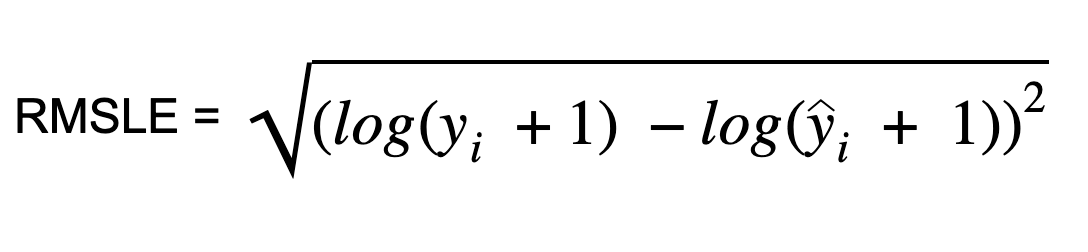
- **RMSE** adalah metrik yang mengukur akar kuadrat dari rata-rata perbedaan kuadrat antara nilai yang diprediksi oleh model dan nilai yang sebenarnya. RMSE memberikan estimasi error model dalam satuan yang sama dengan target. RMSE yang rendah menunjukkan prediksi yang lebih tepat. Nilai ideal adalah RMSE = 0, yang berarti model memberikan prediksi sempurna tanpa kesalahan.
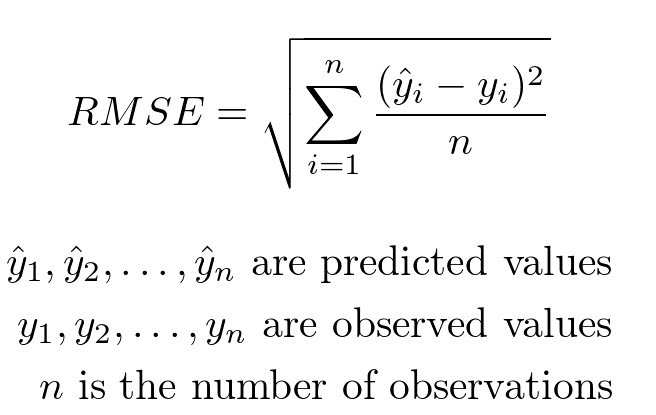

- **MAE** mengukur rata-rata kesalahan absolut antara prediksi dan nilai sebenarnya. Nilai ini memberikan representasi langsung dari kesalahan rata-rata dalam unit yang sama dengan data yang diprediksi. Misalnya, jika kita memprediksi jumlah sepeda yang disewa, MAE akan memberitahu kita berapa banyak sepeda, rata-rata, yang salah dalam prediksi model dibandingkan dengan aktual. selain itu, berbeda dengan MSE, MAE lebih resisten terhadap outliers karena tidak mengkuadratkan kesalahan. Dalam konteks bisnis seperti penyewaan sepeda, ini berguna karena bisa jadi ada hari-hari tertentu dengan permintaan sangat tinggi atau rendah yang tidak tipikal dan tidak seharusnya mempengaruhi evaluasi model secara keseluruhan.

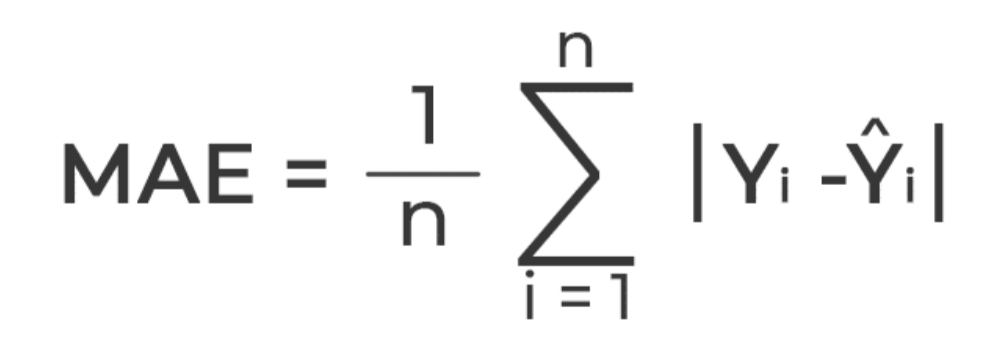

- MAPE mengukur kesalahan sebagai persentase dari nilai aktual, membuatnya berguna untuk membandingkan performa model di antara dataset atau unit yang berbeda tanpa khawatir tentang perbedaan skala. Dalam bisnis penyewaan sepeda, ini penting karena memungkinkan pembandingan performa model di berbagai lokasi atau waktu dengan volume permintaan yang sangat berbeda. MAPE memberikan insight tentang kesalahan relatif, yang secara langsung berkorelasi dengan kerugian atau kelebihan kapasitas yang dapat dialami bisnis. Sebuah MAPE yang tinggi menunjukkan bahwa model mungkin tidak akurat dalam memprediksi permintaan, yang bisa mengarah pada kekurangan persediaan sepeda atau sebaliknya, kelebihan yang tidak termanfaatkan.

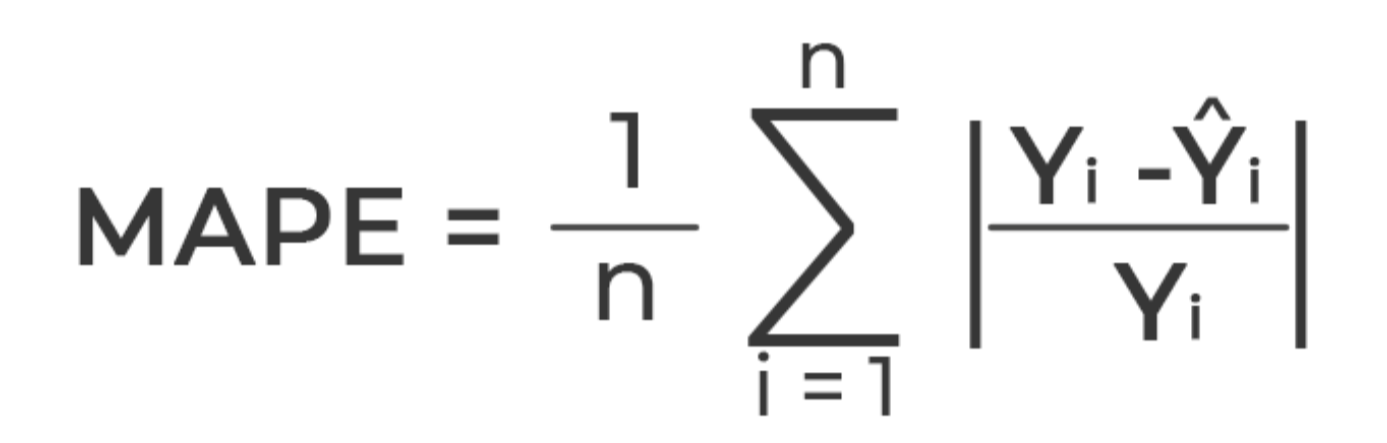
- Std RMSE, MAE, MAPE, dan RMSLE mengukur variasi atau dispersi nilai RMSE, MAE, dan MAPE dari satu set prediksi ke prediksi lainnya, biasanya dihitung selama cross validation. Std RMSE, MAE, dan MAPE menunjukkan seberapa berubah-ubah ketiga metrics tersebut ketika model diuji dengan berbagai subset data (misalnya, dalam cross validation). Standar deviasi yang lebih rendah menunjukkan bahwa model memberikan prediksi yang konsisten di berbagai kondisi pengujian. Ini menunjukkan stabilitas model.
- **Kita akan menggunakan metrics RMSLE dan standar deviasinya sebagai metrics utama. Karena, pada bisnis penyewaan sepeda, kesalahan relatif sering kali lebih penting dari besarannya**. Misalnya, overestimation atau underestimation jumlah sepeda yang dibutuhkan pada waktu tertentu bisa memiliki dampak yang sama-sama besar. Selain itu, RMSLE lebih memberikan penalti lebih besar kepada hasil prediksi yang *underestimation* daripada *overestimation*. Hal ini tentunya sangat berguna dalam kasus rental sepeda, di mana apabila prediksi kurang dari demand asli, dapat merugikan bisnis dan menurunkan kepuasan pengguna.
- **RMSLE dengan efektif meminimalisir efek berlebih dari kesalahan besar pada nilai-nilai besar karena mengukur kesalahan relatif, bukan perbedaan absolut seperti MAE**. Kemudian, karena **RMSLE mengukur perbedaan dalam skala logaritmik sehingga, kesalahan besar pada nilai-nilai besar tidak akan mendominasi keseluruhan kesalahan sebanyak dalam RMSE**. Ini bermanfaat untuk data yang nilainya berdistribusi right-skewed atau di mana kesalahan pada nilai-nilai kecil dan besar sama-sama penting. Selain itu, **RMSLE lebih dipilih daripada MAPE karena mengurangi pengaruh kesalahan besar pada prediksi tinggi, yang merupakan fitur kritis dalam mengoptimalkan sumber daya dan mengelola persediaan sepeda secara efisien**. RMSLE mendorong model untuk menjadi akurat dalam memprediksi proporsi daripada perbedaan mutlak, yang sangat berguna dalam menghindari biaya logistik yang tidak perlu atau kekurangan pasokan yang dapat merugikan kepuasan pelanggan.

## Modelling With Outliers

Agar dapat menggunakan semua fitur yang dipilih, maka fitur-fitur kategorikal harus diubah menjadi fitur numerikal. Kita dapat menggunakan ColumnTransformer untuk dapat mengubah tipe datanya, yang mana nanti dapat diaplikasikan pada pipeline model.

Ada beberapa variabel kategorik yang kita miliki yang perlu di-encode:
- `weather` (nominal). Kita gunakan onehot encoding karena variabel tersebut adalah variabel nominal dan hanya memiliki 3 label.
- `season` (nominal). Kita gunakan onehot encoding karena variabel tersebut adalah variabel nominal dan hanya memiliki 4 label.
- `day_of_week` (nominal). Kita gunakan onehot encoding karena variabel tersebut adalah variabel nominal dan memiliki 7 label.
- `holiday` (nominal). Kita gunakan onehot encoding karena variabel tersebut adalah variabel nominal dan memiliki 2 label.

Sedangkan, untuk variabel `month`, dan `day` dapat kita perlakukan sebagai numerik dan bisa juga diperlakukan sebagai kategorik. Maka, di sini kita akan menggunakan 2 metode encoding, yaitu:
- Metode 1 akan mengencode variabel `weather`, `season`, dan `day_of_week` saja.
- Metode 2 akan mengencode variabel `weather`, `season`, `day_of_week`, dan `month` dengan OneHot Encoder. Sedangkan untuk `day` dan `hour` akan di-encode dengan binary encoder karena jumlah labelnya yang banyak. Metode 2 dilakukan agar model dapat menangkap pola perulangan dari ketiga variabel ini.


### Encoding Metode 1 (`day`, `month`, dan `hour` tidak di-encode)

Mengubah fitur kategorikal menjadi numerikal

In [ ]:
df_oh_outliers = df_clean_outliers.copy()

def one_hot_encoding(data, column):
    data = pd.concat([data, pd.get_dummies(data[column], prefix=column, drop_first=True)], axis=1)
    data = data.drop([column], axis=1)
    return data

cols = ['season', 'holiday', 'day_of_week', 'weather']

for col in cols:
    df_oh_outliers = one_hot_encoding(df_oh_outliers, col)
df_oh_outliers

,humidity,atemp,hour,total_rented_bikes,day,month,year,season_2,season_3,season_4,holiday_1,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,weather_2,weather_3,weather_4
0,0.81,0.2879,0,16,1,1,2011,False,False,False,False,False,False,False,False,True,False,False,False,False
1,0.80,0.2727,1,40,1,1,2011,False,False,False,False,False,False,False,False,True,False,False,False,False
2,0.80,0.2727,2,32,1,1,2011,False,False,False,False,False,False,False,False,True,False,False,False,False
3,0.75,0.2879,3,13,1,1,2011,False,False,False,False,False,False,False,False,True,False,False,False,False
4,0.75,0.2879,4,1,1,1,2011,False,False,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12160,0.45,0.2727,14,247,31,12,2012,False,False,False,False,False,False,False,False,False,False,True,False,False
12161,0.48,0.2576,16,214,31,12,2012,False,False,False,False,False,False,False,False,False,False,True,False,False
12162,0.48,0.2879,17,164,31,12,2012,False,False,False,False,False,False,False,False,False,False,True,False,False
12163,0.60,0.2576,19,119,31,12,2012,False,False,False,False,False,False,False,False,False,False,True,False,False


### Train, Test, Split (dengan metode 1)

Memisahkan data independen variabel dengan target

In [ ]:
X = df_oh_outliers.drop(['total_rented_bikes'], axis=1)
y = df_oh_outliers['total_rented_bikes']

Splitting data training dan test dengan proporsi 80:20 untuk memaksimalkan model dalam mempelajari data

In [ ]:
X_train_outliers, X_test_outliers, y_train_outliers, y_test_outliers = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=10)

### Training the Models (dengan metode 1)
Lakukan training dengan menggunakan scaling, encoder, dan benchmark model. Selain itu, untuk mencegah terjadinya overfitting, kita menggunakan cross validation. Dalam mengevaluasi model, digunakan RMSE, MAE, MAPE, dan RMSLE beserta standar deviasinya.

Buat fungsi penghitung neg_RMSLE

In [ ]:
# Define algoritma yang digunakan
lr = LinearRegression()
ridge = Ridge(random_state=100)
lasso = Lasso(random_state=100)
dt = DecisionTreeRegressor(random_state=100)
rf = RandomForestRegressor(random_state=100)
xgb = XGBRegressor(random_state=100)
bagging = BaggingRegressor(estimator=xgb, random_state=100)
voting = VotingRegressor([('xgb', XGBRegressor()), ('rf', RandomForestRegressor()), ('bagging', BaggingRegressor())])


# Pemodelan dilakukan dalam skala logaritmik, namun kemudian di-inverse kembali untuk interpretasi
log_lr = TransformedTargetRegressor(lr, func=np.log, inverse_func=np.exp)
log_ridge = TransformedTargetRegressor(ridge, func=np.log, inverse_func=np.exp)
log_lasso = TransformedTargetRegressor(lasso, func=np.log, inverse_func=np.exp)
log_dt = TransformedTargetRegressor(dt, func=np.log, inverse_func=np.exp)
log_rf = TransformedTargetRegressor(rf, func=np.log, inverse_func=np.exp)
log_xgb = TransformedTargetRegressor(xgb, func=np.log, inverse_func=np.exp)
log_bagging = TransformedTargetRegressor(bagging, func=np.log, inverse_func=np.exp)
log_voting = TransformedTargetRegressor(voting, func=np.log, inverse_func=np.exp)

# Scaling data
scaler = StandardScaler()

# Kandidat algoritma
models = [log_lr, log_ridge, log_lasso, log_dt, log_rf, log_xgb, log_bagging, log_voting]

score_rmsle = []
nilai_mean_rmsle = []
nilai_std_rmsle = []

score_rmse = []
nilai_mean_rmse = []
nilai_std_rmse = []

score_mae = []
nilai_mean_mae = []
nilai_std_mae = []

score_mape = []
nilai_mean_mape = []
nilai_std_mape = []

# Mencari algoritma terbaik berdasarkan tiap metrics
for i in models:

    crossval = KFold(n_splits=6, shuffle=True, random_state=1)

    estimator = Pipeline([
        ('scaler', scaler),
        ('model', i)
    ])

    # RMSLE
    model_cv_rmsle = cross_val_score(
        estimator,
        X_train_outliers,
        y_train_outliers,
        cv=crossval,
        scoring=rmsle_scorer,
        error_score='raise'
        )

    print(model_cv_rmsle, i)

    score_rmsle.append(model_cv_rmsle)
    nilai_mean_rmsle.append(model_cv_rmsle.mean())
    nilai_std_rmsle.append(model_cv_rmsle.std())

    # RMSE
    model_cv_rmse = cross_val_score(
        estimator,
        X_train_outliers,
        y_train_outliers,
        cv=crossval,
        scoring='neg_root_mean_squared_error',
        error_score='raise'
        )

    print(model_cv_rmse, i)

    score_rmse.append(model_cv_rmse)
    nilai_mean_rmse.append(model_cv_rmse.mean())
    nilai_std_rmse.append(model_cv_rmse.std())

    # MAE
    model_cv_mae = cross_val_score(
        estimator,
        X_train_outliers,
        y_train_outliers,
        cv=crossval,
        scoring='neg_mean_absolute_error',
        error_score='raise'
        )

    print(model_cv_mae, i)

    score_mae.append(model_cv_mae)
    nilai_mean_mae.append(model_cv_mae.mean())
    nilai_std_mae.append(model_cv_mae.std())

    # MAPE
    model_cv_mape = cross_val_score(
        estimator,
        X_train_outliers,
        y_train_outliers,
        cv=crossval,
        scoring='neg_mean_absolute_percentage_error',
        error_score='raise'
        )

    print(model_cv_mape, i)

    score_mape.append(model_cv_mape)
    nilai_mean_mape.append(model_cv_mape.mean())
    nilai_std_mape.append(model_cv_mape.std())

[-1.03452887 -0.99553797 -1.02602622 -1.01037228 -0.99140611 -1.03503573] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-164.1055636  -169.98961986 -156.43843882 -161.60694084 -165.7211009
 -163.04132595] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-108.20438851 -111.36455973 -103.0635903  -107.45779997 -109.5423308
 -107.56403517] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-1.47189327 -1.2357066  -1.44069994 -1.43908582 -1.30286233 -1.43684599] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-1.03452613 -0.99553445 -1.02602312 -1.0103755  -0.99139751 -1.03502955] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
   

Kode di atas menggambarkan sebuah proses untuk melatih dan membandingkan performa dari berbagai model regresi menggunakan pendekatan cross-validation dan beberapa metrik seperti RMSLE (Root Mean Squared Log Error), RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), dan MAPE (Mean Absolute Percentage Error). Pertama-tama, kita definisikan beberapa model regresi dilakukan, termasuk Linear Regression, Decision Tree, Random Forest, XGBoost, Ridge Regression, ElasticNet, dan Lasso. Model-model ini diterapkan dalam bentuk logaritmik menggunakan `TransformedTargetRegressor` untuk menstabilkan varians dan meminimalkan potensi pengaruh nilai ekstrem, dengan transformasi logaritmik pada target variabel dan kemudian di-*inverse* kembali untuk interpretasi hasil.

Setiap model diintegrasikan ke dalam sebuah pipeline yang menyertakan proses preprocessing, scaling menggunakan `StandardScaler`, dan model regresi itu sendiri. Penggunaan `StandardScaler` bertujuan untuk menghilangkan bias akibat perbedaan skala unit antar fitur, yang sangat penting untuk beberapa model seperti SVM dan k-nearest neighbors.

Evaluasi model dilakukan menggunakan cross-validation dengan enam splits, diacak dengan `shuffle=True` untuk mengurangi bias sampling. Metrics yang digunakan untuk evaluasi adalah RMSLE, RMSE, MAE, dan MAPE, semuanya dalam bentuk negatif (sesuai konvensi scikit-learn yang memaksimalkan skor). Nilai metrics dihitung untuk setiap fold, di mana rata-rata dan standar deviasi dari nilai-nilai ini dicatat untuk menilai dan membandingkan kinerja model secara keseluruhan.

Output yang dihasilkan mencakup nilai skor untuk masing-masing model dan setiap metrik, memberikan informasi tentang konsistensi dan keakuratan dari masing-masing model dalam memprediksi data. Ini sangat membantu dalam memilih model yang paling sesuai berdasarkan kriteria spesifik dari analisis yang dilakukan.

In [ ]:
# Evaluasi hasil dari 8 kandidat algoritma yang digunakan
train_metrics_m1_outliers = pd.DataFrame({'Model': ['Linear Regression',  'Ridge', 'Lasso', 'DecisionTree Regressor', 'RandomForest Regressor',
                                                    'XGBoost Regressor', 'Bagging Regressor', 'Voting Regressor'],
                                          'Mean_RMSLE': nilai_mean_rmsle,
                                          'Std_RMSLE': nilai_std_rmsle,
                                          'Mean_RMSE': nilai_mean_rmse,
                                          'Std_RMSE': nilai_std_rmse,
                                          'Mean_MAE': nilai_mean_mae,
                                          'Std_MAE': nilai_std_mae,
                                          'Mean_MAPE': nilai_mean_mape,
                                          'Std_MAPE': nilai_std_mape})
train_metrics_m1_outliers = train_metrics_m1_outliers.set_index('Model').sort_values(by='Mean_RMSLE', ascending=False)
train_metrics_m1_outliers

,Mean_RMSLE,Std_RMSLE,Mean_RMSE,Std_RMSE,Mean_MAE,Std_MAE,Mean_MAPE,Std_MAPE
Model,,,,,,,,
Bagging Regressor,-0.296145,0.010175,-41.709020,0.786398,-25.180600,0.362834,-0.244213,0.013005
XGBoost Regressor,-0.309321,0.007246,-44.184727,1.043596,-26.833207,0.874101,-0.255291,0.011636
Voting Regressor,-0.317943,0.008786,-45.476814,1.130482,-27.543537,0.475747,-0.265671,0.015552
RandomForest Regressor,-0.344268,0.009788,-49.602142,1.457546,-30.041399,0.528023,-0.290419,0.017463
DecisionTree Regressor,-0.480619,0.019595,-69.241249,3.645413,-40.532734,1.249637,-0.418109,0.038039
Ridge,-1.015481,0.017607,-163.476881,4.104812,-107.862331,2.532278,-1.387909,0.086857
Linear Regression,-1.015485,0.017606,-163.483832,4.104333,-107.866117,2.532636,-1.387849,0.086845
Lasso,-1.419190,0.019104,-204.782800,7.095167,-142.724394,4.405388,-3.781399,0.279400


Sehingga dari hasil di atas, disimpulkan bahwa:
- Bagging Regressor menampilkan performa yang sangat baik dengan skor terendah untuk Mean RMSLE, Mean RMSE, Mean MAE, dan Mean MAPE di antara model-model yang lain. Ini menunjukkan bahwa model ini memiliki kesalahan prediksi yang paling rendah dan paling akurat.
- XGB Regressor dan Voting Regressor juga menunjukkan performa yang cukup baik dengan nilai error yang sedikit lebih tinggi daripada Bagging Regressor.
- Metode seperti Ridge dan Lasso, meskipun keduanya mengandalkan regularisasi untuk mengurangi overfitting, tampaknya tidak mampu menangkap kompleksitas dalam data yang sama efektifnya dengan model non-parametrik.
- Bagging Regressor juga menunjukkan performa yang beragam tetapi umumnya lebih rendah dari XGBoost, Voting, dan RandomForest.
- Linear regression menampilkan performa yang kurang baik. Hal ini dapat dilihat dari nilai keseluruhan metrics yang tinggi.

Dalam mencari model yang ideal untuk keperluan bisnis, konsistensi dan akurasi adalah dua faktor kunci yang harus dipertimbangkan. Berdasarkan konteks bisnis, seperti dalam industri rental sepeda, model yang dapat memberikan prediksi yang akurat dan konsisten sangat penting untuk memaksimalkan pendapatan dan mengoptimalkan operasional. **Karena Bagging Regressor dan XGB Regressor menawarkan konsistensi dan akurasi yang paling baik, maka kita akan melakukan testing terhadap model tersebut**.

### Encoding Metode 2 (`day`, `month`, dan `hour` di-encode)

In [ ]:
# Ubah day ke kategorik untuk dapat melakukan binary encoder
df_clean_outliers['day'] = df_clean_outliers['day'].astype('category')
df_clean_outliers['hour'] = df_clean_outliers['hour'].astype('category')
transformer2 = ColumnTransformer([
    ('One Hot', OneHotEncoder(drop='first'), ['weather', 'season', 'day_of_week', 'month', 'holiday']),
    ('binary', ce.BinaryEncoder(),['day', 'hour'])], remainder='passthrough')

### Train, Test, Split (dengan metode 2)

Memisahkan data independen variabel dengan target

In [ ]:
X = df_clean_outliers.drop(['total_rented_bikes'], axis=1)
y = df_clean_outliers['total_rented_bikes']

Splitting data training dan test dengan proporsi 80:20

In [ ]:
X_train_outliers, X_test_outliers, y_train_outliers, y_test_outliers = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=10)

### Training the Models (dengan metode 2)

In [ ]:
# Define algoritma yang digunakan
lr = LinearRegression()
ridge = Ridge(random_state=100)
lasso = Lasso(random_state=100)
dt = DecisionTreeRegressor(random_state=100)
rf = RandomForestRegressor(random_state=100)
xgb = XGBRegressor(random_state=100)
bagging = BaggingRegressor(estimator=xgb, random_state=100)
voting = VotingRegressor([('xgb', XGBRegressor()), ('rf', RandomForestRegressor()), ('bagging', BaggingRegressor())])


# Pemodelan dilakukan dalam skala logaritmik, namun kemudian di-inverse kembali untuk interpretasi
log_lr = TransformedTargetRegressor(lr, func=np.log, inverse_func=np.exp)
log_ridge = TransformedTargetRegressor(ridge, func=np.log, inverse_func=np.exp)
log_lasso = TransformedTargetRegressor(lasso, func=np.log, inverse_func=np.exp)
log_dt = TransformedTargetRegressor(dt, func=np.log, inverse_func=np.exp)
log_rf = TransformedTargetRegressor(rf, func=np.log, inverse_func=np.exp)
log_xgb = TransformedTargetRegressor(xgb, func=np.log, inverse_func=np.exp)
log_bagging = TransformedTargetRegressor(bagging, func=np.log, inverse_func=np.exp)
log_voting = TransformedTargetRegressor(voting, func=np.log, inverse_func=np.exp)

# Scaling data
scaler = StandardScaler()

# Kandidat algoritma
models = [log_lr, log_ridge, log_lasso, log_dt, log_rf, log_xgb, log_bagging, log_voting]

score_rmsle = []
nilai_mean_rmsle = []
nilai_std_rmsle = []

score_rmse = []
nilai_mean_rmse = []
nilai_std_rmse = []

score_mae = []
nilai_mean_mae = []
nilai_std_mae = []

score_mape = []
nilai_mean_mape = []
nilai_std_mape = []

# Mencari algoritma terbaik berdasarkan tiap metrics
for i in models:

    crossval = KFold(n_splits=5, shuffle=True, random_state=1)

    estimator = Pipeline([
        ('preprocessing', transformer2),
        ('scaler', scaler),
        ('model', i)
    ])

    # RMSLE
    model_cv_rmsle = cross_val_score(
        estimator,
        X_train_outliers,
        y_train_outliers,
        cv=crossval,
        scoring=rmsle_scorer,
        error_score='raise'
        )

    print(model_cv_rmsle, i)

    score_rmsle.append(model_cv_rmsle)
    nilai_mean_rmsle.append(model_cv_rmsle.mean())
    nilai_std_rmsle.append(model_cv_rmsle.std())

    # RMSE
    model_cv_rmse = cross_val_score(
        estimator,
        X_train_outliers,
        y_train_outliers,
        cv=crossval,
        scoring='neg_root_mean_squared_error',
        error_score='raise'
        )

    print(model_cv_rmse, i)

    score_rmse.append(model_cv_rmse)
    nilai_mean_rmse.append(model_cv_rmse.mean())
    nilai_std_rmse.append(model_cv_rmse.std())

    # MAE
    model_cv_mae = cross_val_score(
        estimator,
        X_train_outliers,
        y_train_outliers,
        cv=crossval,
        scoring='neg_mean_absolute_error',
        error_score='raise'
        )

    print(model_cv_mae, i)

    score_mae.append(model_cv_mae)
    nilai_mean_mae.append(model_cv_mae.mean())
    nilai_std_mae.append(model_cv_mae.std())

    # MAPE
    model_cv_mape = cross_val_score(
        estimator,
        X_train_outliers,
        y_train_outliers,
        cv=crossval,
        scoring='neg_mean_absolute_percentage_error',
        error_score='raise'
        )

    print(model_cv_mape, i)

    score_mape.append(model_cv_mape)
    nilai_mean_mape.append(model_cv_mape.mean())
    nilai_std_mape.append(model_cv_mape.std())

[-0.97289391 -1.03795567 -0.99545376 -1.07718566 -1.04141267] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-174.36639183 -156.95320844 -171.74680483 -172.16580447 -175.83343061] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-111.79332518 -102.96426053 -110.53758615 -111.69889155 -112.25076336] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-1.31090406 -1.61469894 -1.33356076 -1.7795474  -1.67630656] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-0.97287844 -1.03793772 -0.9954655  -1.07717809 -1.04139819] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Ridge(random_state=100))
[-174

In [ ]:
# Evaluasi hasil dari 8 kandidat algoritma yang digunakan
train_metrics_m2_outliers = pd.DataFrame({'Model': ['Linear Regression',  'Ridge', 'Lasso', 'DecisionTree Regressor', 'RandomForest Regressor',
                                                    'XGBoost Regressor', 'Bagging Regressor', 'Voting Regressor'],
                                          'Mean_RMSLE': nilai_mean_rmsle,
                                          'Std_RMSLE': nilai_std_rmsle,
                                          'Mean_RMSE': nilai_mean_rmse,
                                          'Std_RMSE': nilai_std_rmse,
                                          'Mean_MAE': nilai_mean_mae,
                                          'Std_MAE': nilai_std_mae,
                                          'Mean_MAPE': nilai_mean_mape,
                                          'Std_MAPE': nilai_std_mape})
train_metrics_m2_outliers = train_metrics_m2_outliers.set_index('Model').sort_values(by='Mean_RMSLE', ascending=False)
train_metrics_m2_outliers

,Mean_RMSLE,Std_RMSLE,Mean_RMSE,Std_RMSE,Mean_MAE,Std_MAE,Mean_MAPE,Std_MAPE
Model,,,,,,,,
Bagging Regressor,-0.407128,0.030136,-65.886871,8.165772,-40.712571,5.320826,-0.374844,0.037242
Voting Regressor,-0.408549,0.042921,-63.996957,9.721093,-39.011780,5.295125,-0.370512,0.048029
XGBoost Regressor,-0.429091,0.033719,-70.923051,8.195593,-43.521695,5.339932,-0.388344,0.029731
RandomForest Regressor,-0.437865,0.049586,-67.488096,10.855220,-41.049167,6.219361,-0.406058,0.063303
DecisionTree Regressor,-0.652331,0.103183,-90.852001,14.866720,-53.517461,7.952135,-0.705102,0.200641
Ridge,-1.024972,0.036736,-170.175897,6.803793,-109.836870,3.490306,-1.543064,0.187913
Linear Regression,-1.024980,0.036739,-170.213128,6.794527,-109.848965,3.488402,-1.543004,0.187936
Lasso,-1.419245,0.013424,-204.860897,4.097022,-142.728320,2.536119,-3.781139,0.198852


Metode kedua menghasilkan error yang tinggi dengan standar deviasi yang tinggi juga. Hal ini mengindikasikan bahwa terjadi curse of dimensionality, yaitu terlalu banyaknya variabel sehingga model mengalami underfitting. Selain itu, ternyata, hasil RMSLE, RMSE, MAE, dan MAPE lebih baik ketika menggunakan hanya melakukan onehot encoding pada `weather`, `season`, `holiday`, dan `day_of_week`. Sehingga, kita akan menggunakan metode 1 untuk melakukan encoding terhadap variabel kategorik pada data dengan outliers.

## Modelling Without Outliers

### Encoding1 (`day`, `month`, dan `hour`)

Mengubah fitur kategorikal menjadi numerikal

In [ ]:
df_oh_wo_outliers = df_clean_wo_outliers.copy()

def one_hot_encoding(data, column):
    data = pd.concat([data, pd.get_dummies(data[column], prefix=column, drop_first=True)], axis=1)
    data = data.drop([column], axis=1)
    return data

cols = ['season', 'holiday', 'day_of_week', 'weather']

for col in cols:
    df_oh_wo_outliers = one_hot_encoding(df_oh_wo_outliers, col)
df_oh_wo_outliers

,humidity,atemp,hour,total_rented_bikes,day,month,year,season_2,season_3,season_4,holiday_1,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,weather_2,weather_3,weather_4
0,0.81,0.2879,0,16,1,1,2011,False,False,False,False,False,False,False,False,True,False,False,False,False
1,0.80,0.2727,1,40,1,1,2011,False,False,False,False,False,False,False,False,True,False,False,False,False
2,0.80,0.2727,2,32,1,1,2011,False,False,False,False,False,False,False,False,True,False,False,False,False
3,0.75,0.2879,3,13,1,1,2011,False,False,False,False,False,False,False,False,True,False,False,False,False
4,0.75,0.2879,4,1,1,1,2011,False,False,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12160,0.45,0.2727,14,247,31,12,2012,False,False,False,False,False,False,False,False,False,False,True,False,False
12161,0.48,0.2576,16,214,31,12,2012,False,False,False,False,False,False,False,False,False,False,True,False,False
12162,0.48,0.2879,17,164,31,12,2012,False,False,False,False,False,False,False,False,False,False,True,False,False
12163,0.60,0.2576,19,119,31,12,2012,False,False,False,False,False,False,False,False,False,False,True,False,False


### Train, Test, Split (dengan metode 1)

Memisahkan data independen variabel dengan target

In [ ]:
X = df_oh_wo_outliers.drop(['total_rented_bikes'], axis=1)
y = df_oh_wo_outliers['total_rented_bikes']

Splitting data training dan test dengan proporsi 80:20

In [ ]:
X_train_wo_outliers, X_test_wo_outliers, y_train_wo_outliers, y_test_wo_outliers = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=10)

### Training the Models (dengan metode 1)

In [ ]:
# Define algoritma yang digunakan
lr = LinearRegression()
ridge = Ridge(random_state=100)
lasso = Lasso(random_state=100)
dt = DecisionTreeRegressor(random_state=100)
rf = RandomForestRegressor(random_state=100)
xgb = XGBRegressor(random_state=100)
bagging = BaggingRegressor(estimator=xgb, random_state=100)
voting = VotingRegressor([('xgb', XGBRegressor()), ('rf', RandomForestRegressor()), ('bagging', BaggingRegressor())])


# Pemodelan dilakukan dalam skala logaritmik, namun kemudian di-inverse kembali untuk interpretasi
log_lr = TransformedTargetRegressor(lr, func=np.log, inverse_func=np.exp)
log_ridge = TransformedTargetRegressor(ridge, func=np.log, inverse_func=np.exp)
log_lasso = TransformedTargetRegressor(lasso, func=np.log, inverse_func=np.exp)
log_dt = TransformedTargetRegressor(dt, func=np.log, inverse_func=np.exp)
log_rf = TransformedTargetRegressor(rf, func=np.log, inverse_func=np.exp)
log_xgb = TransformedTargetRegressor(xgb, func=np.log, inverse_func=np.exp)
log_bagging = TransformedTargetRegressor(bagging, func=np.log, inverse_func=np.exp)
log_voting = TransformedTargetRegressor(voting, func=np.log, inverse_func=np.exp)

# Scaling data
scaler = StandardScaler()

# Kandidat algoritma
models = [log_lr, log_ridge, log_lasso, log_dt, log_rf, log_xgb, log_bagging, log_voting]

score_rmsle = []
nilai_mean_rmsle = []
nilai_std_rmsle = []

score_rmse = []
nilai_mean_rmse = []
nilai_std_rmse = []

score_mae = []
nilai_mean_mae = []
nilai_std_mae = []

score_mape = []
nilai_mean_mape = []
nilai_std_mape = []

# Mencari algoritma terbaik berdasarkan tiap metrics
for i in models:

    crossval = KFold(n_splits=6, shuffle=True, random_state=1)

    estimator = Pipeline([
        ('scaler', scaler),
        ('model', i)
    ])

    # RMSLE
    model_cv_rmsle = cross_val_score(
        estimator,
        X_train_wo_outliers,
        y_train_wo_outliers,
        cv=crossval,
        scoring=rmsle_scorer,
        error_score='raise'
        )

    print(model_cv_rmsle, i)

    score_rmsle.append(model_cv_rmsle)
    nilai_mean_rmsle.append(model_cv_rmsle.mean())
    nilai_std_rmsle.append(model_cv_rmsle.std())

    # RMSE
    model_cv_rmse = cross_val_score(
        estimator,
        X_train_wo_outliers,
        y_train_wo_outliers,
        cv=crossval,
        scoring='neg_root_mean_squared_error',
        error_score='raise'
        )

    print(model_cv_rmse, i)

    score_rmse.append(model_cv_rmse)
    nilai_mean_rmse.append(model_cv_rmse.mean())
    nilai_std_rmse.append(model_cv_rmse.std())

    # MAE
    model_cv_mae = cross_val_score(
        estimator,
        X_train_wo_outliers,
        y_train_wo_outliers,
        cv=crossval,
        scoring='neg_mean_absolute_error',
        error_score='raise'
        )

    print(model_cv_mae, i)

    score_mae.append(model_cv_mae)
    nilai_mean_mae.append(model_cv_mae.mean())
    nilai_std_mae.append(model_cv_mae.std())

    # MAPE
    model_cv_mape = cross_val_score(
        estimator,
        X_train_wo_outliers,
        y_train_wo_outliers,
        cv=crossval,
        scoring='neg_mean_absolute_percentage_error',
        error_score='raise'
        )

    print(model_cv_mape, i)

    score_mape.append(model_cv_mape)
    nilai_mean_mape.append(model_cv_mape.mean())
    nilai_std_mape.append(model_cv_mape.std())

[-1.03000587 -1.03472668 -1.00266571 -1.00712685 -1.01967442 -0.98258731] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-145.26624829 -146.38748975 -149.2537419  -142.01703438 -146.80873726
 -142.77719343] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[ -99.18104223  -99.18654425 -101.29326643  -96.40287913  -97.85332977
  -96.31847638] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-1.47216722 -1.48965339 -1.24663675 -1.33360076 -1.48990014 -1.28927544] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-1.03000508 -1.03472462 -1.00265693 -1.00712354 -1.01967206 -0.9825835 ] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
 

In [ ]:
# Evaluasi hasil dari 8 kandidat algoritma yang digunakan
train_metrics_m1_wo_outliers = pd.DataFrame({'Model': ['Linear Regression',  'Ridge', 'Lasso', 'DecisionTree Regressor', 'RandomForest Regressor',
                                                    'XGBoost Regressor', 'Bagging Regressor', 'Voting Regressor'],
                                            'Mean_RMSLE': nilai_mean_rmsle,
                                            'Std_RMSLE': nilai_std_rmsle,
                                            'Mean_RMSE': nilai_mean_rmse,
                                            'Std_RMSE': nilai_std_rmse,
                                            'Mean_MAE': nilai_mean_mae,
                                            'Std_MAE': nilai_std_mae,
                                            'Mean_MAPE': nilai_mean_mape,
                                            'Std_MAPE': nilai_std_mape})
train_metrics_m1_wo_outliers = train_metrics_m1_wo_outliers.set_index('Model').sort_values(by='Mean_RMSLE', ascending=False)
train_metrics_m1_wo_outliers

,Mean_RMSLE,Std_RMSLE,Mean_RMSE,Std_RMSE,Mean_MAE,Std_MAE,Mean_MAPE,Std_MAPE
Model,,,,,,,,
Bagging Regressor,-0.297839,0.011250,-39.341022,0.740325,-24.036967,0.356842,-0.245602,0.012985
XGBoost Regressor,-0.308119,0.013724,-40.417436,0.714996,-24.921557,0.754531,-0.253630,0.017196
Voting Regressor,-0.321086,0.008722,-42.665356,0.844334,-26.066131,0.937851,-0.268757,0.012691
RandomForest Regressor,-0.350127,0.005933,-47.442421,1.158810,-28.814320,0.991600,-0.296834,0.009376
DecisionTree Regressor,-0.494703,0.012057,-65.147828,2.282998,-38.906934,1.209101,-0.430015,0.026259
Ridge,-1.012794,0.017664,-145.410462,2.453331,-98.368698,1.742231,-1.386938,0.100410
Linear Regression,-1.012798,0.017662,-145.418408,2.454602,-98.372590,1.742376,-1.386872,0.100402
Lasso,-1.403978,0.029088,-179.232294,5.167267,-130.585145,3.825169,-3.722038,0.299594


Dari hasil di atas, dapat disimpulkan bahwa:

- XGBoost Regressor menunjukkan performa yang sangat baik dengan nilai Mean RMSLE, Mean RMSE, Mean MAE, dan Mean MAPE yang terendah di antara semua model yang diuji. Hal ini mengindikasikan bahwa XGBoost Regressor memiliki tingkat kesalahan prediksi yang paling rendah dan memberikan prediksi yang paling akurat. Konsistensi yang ditunjukkan oleh skor Standar Deviasi yang rendah untuk semua metriknya juga menunjukkan bahwa model ini stabil dalam berbagai kondisi uji.

- Voting Regressor dan RandomForest Regressor menunjukkan performa yang cukup baik dengan error yang hanya sedikit lebih tinggi daripada XGBoost Regressor. Performa ini menandakan bahwa kedua model juga cukup handal dalam membuat prediksi yang akurat, meskipun tidak seoptimal XGBoost.

- Bagging Regressor memiliki performa yang variatif, namun model ini tidak seefektif model-model sebelumnya dalam mengatasi data ini.

- Meskipun Ridge dan Lasso merupakan metode regresi yang mengandalkan regularisasi untuk mengurangi risiko overfitting, tampaknya kedua model tidak cukup efektif dalam mengatasi kompleksitas yang ada dalam dataset ini. Performa yang kurang ini dapat dilihat dari skor kesalahan yang tinggi dalam semua metrik yang diukur.

- Linear Regression menunjukkan performa yang serupa dengan Ridge dan Lasso. Hal ini menegaskan bahwa teknik regresi linear sederhana tidak mampu menangkap variabilitas dalam data sepeda yang kompleks.

### Encoding2 (`day` dan `month` di-encode)

In [ ]:
# Ubah day dan hour ke kategorik untuk dapat melakukan binary encoder
df_clean_wo_outliers['day'] = df_clean_wo_outliers['day'].astype('category')
df_clean_wo_outliers['hour'] = df_clean_wo_outliers['hour'].astype('category')
transformer2 = ColumnTransformer([
    ('One Hot', OneHotEncoder(drop='first'), ['weather', 'season', 'day_of_week', 'month', 'holiday']),
    ('binary', ce.BinaryEncoder(),['day', 'hour'])], remainder='passthrough')

### Train, Test, Split (dengan metode 2)

In [ ]:
X = df_clean_wo_outliers.drop(['total_rented_bikes'], axis=1)
y = df_clean_wo_outliers['total_rented_bikes']

In [ ]:
X_train_wo_outliers, X_test_wo_outliers, y_train_wo_outliers, y_test_wo_outliers = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=10)

### Training the Models (dengan metode 2)

In [ ]:
# Define algoritma yang digunakan
lr = LinearRegression()
ridge = Ridge(random_state=100)
lasso = Lasso(random_state=100)
dt = DecisionTreeRegressor(random_state=100)
rf = RandomForestRegressor(random_state=100)
xgb = XGBRegressor(random_state=100)
bagging = BaggingRegressor(estimator=xgb, random_state=100)
voting = VotingRegressor([('xgb', XGBRegressor()), ('rf', RandomForestRegressor()), ('bagging', BaggingRegressor())])


# Pemodelan dilakukan dalam skala logaritmik, namun kemudian di-inverse kembali untuk interpretasi
log_lr = TransformedTargetRegressor(lr, func=np.log, inverse_func=np.exp)
log_ridge = TransformedTargetRegressor(ridge, func=np.log, inverse_func=np.exp)
log_lasso = TransformedTargetRegressor(lasso, func=np.log, inverse_func=np.exp)
log_dt = TransformedTargetRegressor(dt, func=np.log, inverse_func=np.exp)
log_rf = TransformedTargetRegressor(rf, func=np.log, inverse_func=np.exp)
log_xgb = TransformedTargetRegressor(xgb, func=np.log, inverse_func=np.exp)
log_bagging = TransformedTargetRegressor(bagging, func=np.log, inverse_func=np.exp)
log_voting = TransformedTargetRegressor(voting, func=np.log, inverse_func=np.exp)

# Scaling data
scaler = StandardScaler()

# Kandidat algoritma
models = [log_lr, log_ridge, log_lasso, log_dt, log_rf, log_xgb, log_bagging, log_voting]

score_rmsle = []
nilai_mean_rmsle = []
nilai_std_rmsle = []

score_rmse = []
nilai_mean_rmse = []
nilai_std_rmse = []

score_mae = []
nilai_mean_mae = []
nilai_std_mae = []

score_mape = []
nilai_mean_mape = []
nilai_std_mape = []

# Mencari algoritma terbaik berdasarkan tiap metrics
for i in models:

    crossval = KFold(n_splits=6, shuffle=True, random_state=1)

    estimator = Pipeline([
        ('preprocessing', transformer2),
        ('scaler', scaler),
        ('model', i)
    ])

    # RMSLE
    model_cv_rmsle = cross_val_score(
        estimator,
        X_train_wo_outliers,
        y_train_wo_outliers,
        cv=crossval,
        scoring=rmsle_scorer,
        error_score='raise'
        )

    print(model_cv_rmsle, i)

    score_rmsle.append(model_cv_rmsle)
    nilai_mean_rmsle.append(model_cv_rmsle.mean())
    nilai_std_rmsle.append(model_cv_rmsle.std())

    # RMSE
    model_cv_rmse = cross_val_score(
        estimator,
        X_train_wo_outliers,
        y_train_wo_outliers,
        cv=crossval,
        scoring='neg_root_mean_squared_error',
        error_score='raise'
        )

    print(model_cv_rmse, i)

    score_rmse.append(model_cv_rmse)
    nilai_mean_rmse.append(model_cv_rmse.mean())
    nilai_std_rmse.append(model_cv_rmse.std())

    # MAE
    model_cv_mae = cross_val_score(
        estimator,
        X_train_wo_outliers,
        y_train_wo_outliers,
        cv=crossval,
        scoring='neg_mean_absolute_error',
        error_score='raise'
        )

    print(model_cv_mae, i)

    score_mae.append(model_cv_mae)
    nilai_mean_mae.append(model_cv_mae.mean())
    nilai_std_mae.append(model_cv_mae.std())

    # MAPE
    model_cv_mape = cross_val_score(
        estimator,
        X_train_wo_outliers,
        y_train_wo_outliers,
        cv=crossval,
        scoring='neg_mean_absolute_percentage_error',
        error_score='raise'
        )

    print(model_cv_mape, i)

    score_mape.append(model_cv_mape)
    nilai_mean_mape.append(model_cv_mape.mean())
    nilai_std_mape.append(model_cv_mape.std())

[-1.1383931  -1.15427221 -1.11077944 -1.13871847 -1.1427337  -1.07669315] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-160.53223075 -149.18948711 -159.83590586 -150.21518526 -144.20174022
 -151.36303637] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-108.66792903 -104.62921231 -108.65986979 -104.6390081   -98.51975897
 -101.39690887] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-2.02801465 -2.17621759 -1.67591728 -1.86005126 -2.17605313 -1.56949411] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-1.13838318 -1.15429424 -1.11078271 -1.13872368 -1.14274476 -1.07664701] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
 

In [ ]:
# Evaluasi hasil dari 8 kandidat algoritma yang digunakan
train_metrics_m2_wo_outliers = pd.DataFrame({'Model': ['Linear Regression',  'Ridge', 'Lasso', 'DecisionTree Regressor', 'RandomForest Regressor',
                                                    'XGBoost Regressor', 'Bagging Regressor', 'Voting Regressor'],
                                            'Mean_RMSLE': nilai_mean_rmsle,
                                            'Std_RMSLE': nilai_std_rmsle,
                                            'Mean_RMSE': nilai_mean_rmse,
                                            'Std_RMSE': nilai_std_rmse,
                                            'Mean_MAE': nilai_mean_mae,
                                            'Std_MAE': nilai_std_mae,
                                            'Mean_MAPE': nilai_mean_mape,
                                            'Std_MAPE': nilai_std_mape})
train_metrics_m2_wo_outliers = train_metrics_m2_wo_outliers.set_index('Model').sort_values(by='Mean_RMSLE', ascending=False)
train_metrics_m2_wo_outliers

,Mean_RMSLE,Std_RMSLE,Mean_RMSE,Std_RMSE,Mean_MAE,Std_MAE,Mean_MAPE,Std_MAPE
Model,,,,,,,,
Bagging Regressor,-0.451017,0.044693,-68.385546,7.116845,-42.755297,4.321957,-0.433535,0.067630
Voting Regressor,-0.455910,0.052754,-69.795222,8.648417,-42.971455,4.819419,-0.450167,0.095278
XGBoost Regressor,-0.475814,0.053931,-73.553702,9.858886,-46.055144,6.116364,-0.454904,0.075285
RandomForest Regressor,-0.496542,0.068479,-75.161039,7.930401,-46.257263,4.796130,-0.509564,0.131233
DecisionTree Regressor,-0.718720,0.142350,-96.261910,11.852804,-57.471987,7.599286,-0.887683,0.427744
Ridge,-1.126929,0.026007,-152.535767,5.837415,-104.411689,3.652886,-1.914385,0.234096
Linear Regression,-1.126932,0.025988,-152.556264,5.840190,-104.418781,3.652968,-1.914291,0.234061
Lasso,-1.403978,0.029088,-179.232294,5.167267,-130.585145,3.825169,-3.722038,0.299594


Pada data tanpa outliers, metode kedua juga menghasilkan error yang tinggi dengan standar deviasi yang tinggi. Hal ini mengindikasikan bahwa terjadi curse of dimensionality, yaitu terlalu banyaknya variabel independen dalam model, sehingga terjadi underfitting. Selain itu, ternyata, hasil RMSLE, RMSE, MAE, dan MAPE lebih baik ketika menggunakan hanya melakukan onehot encoding pada `weather`, `season`, `holiday`, dan `day_of_week`. **Maka kita akan gunakan metode 1 untuk meng-*encode* data tanpa outliers**.

## Train Metrics Comparison between Models with Outliers and without outliers
Sekarang kita akan membandingkan performa training model dengan data lengkap dan data yang dihilangkan outliers-nya.

In [ ]:
print('Hasil Pemodelan dengan outliers\n')
display(train_metrics_m1_outliers)
print('\nHasil Pemodelan tanpa outliers\n')
display(train_metrics_m1_wo_outliers)

Hasil Pemodelan dengan outliers



,Mean_RMSLE,Std_RMSLE,Mean_RMSE,Std_RMSE,Mean_MAE,Std_MAE,Mean_MAPE,Std_MAPE
Model,,,,,,,,
Bagging Regressor,-0.296145,0.010175,-41.709020,0.786398,-25.180600,0.362834,-0.244213,0.013005
XGBoost Regressor,-0.309321,0.007246,-44.184727,1.043596,-26.833207,0.874101,-0.255291,0.011636
Voting Regressor,-0.317943,0.008786,-45.476814,1.130482,-27.543537,0.475747,-0.265671,0.015552
RandomForest Regressor,-0.344268,0.009788,-49.602142,1.457546,-30.041399,0.528023,-0.290419,0.017463
DecisionTree Regressor,-0.480619,0.019595,-69.241249,3.645413,-40.532734,1.249637,-0.418109,0.038039
Ridge,-1.015481,0.017607,-163.476881,4.104812,-107.862331,2.532278,-1.387909,0.086857
Linear Regression,-1.015485,0.017606,-163.483832,4.104333,-107.866117,2.532636,-1.387849,0.086845
Lasso,-1.419190,0.019104,-204.782800,7.095167,-142.724394,4.405388,-3.781399,0.279400



Hasil Pemodelan tanpa outliers



,Mean_RMSLE,Std_RMSLE,Mean_RMSE,Std_RMSE,Mean_MAE,Std_MAE,Mean_MAPE,Std_MAPE
Model,,,,,,,,
Bagging Regressor,-0.297839,0.011250,-39.341022,0.740325,-24.036967,0.356842,-0.245602,0.012985
XGBoost Regressor,-0.308119,0.013724,-40.417436,0.714996,-24.921557,0.754531,-0.253630,0.017196
Voting Regressor,-0.321086,0.008722,-42.665356,0.844334,-26.066131,0.937851,-0.268757,0.012691
RandomForest Regressor,-0.350127,0.005933,-47.442421,1.158810,-28.814320,0.991600,-0.296834,0.009376
DecisionTree Regressor,-0.494703,0.012057,-65.147828,2.282998,-38.906934,1.209101,-0.430015,0.026259
Ridge,-1.012794,0.017664,-145.410462,2.453331,-98.368698,1.742231,-1.386938,0.100410
Linear Regression,-1.012798,0.017662,-145.418408,2.454602,-98.372590,1.742376,-1.386872,0.100402
Lasso,-1.403978,0.029088,-179.232294,5.167267,-130.585145,3.825169,-3.722038,0.299594


Dapat disimpulkan bahwa:
- RMSLE yang lebih rendah pada model tanpa outliers menunjukkan bahwa model tersebut sedikit lebih akurat dalam memprediksi nilai pada skala logaritmik. Penurunan RMSLE ini menunjukkan bahwa menghilangkan outliers membantu model dalam membuat prediksi yang lebih proporsional antara nilai prediksi dan aktual.
- RMSE yang lebih rendah pada model tanpa outliers menunjukkan bahwa rata-rata kesalahan kuadrat prediksi relatif lebih kecil, menandakan peningkatan akurasi dalam nilai prediksi. Hal ini menegaskan bahwa menghilangkan outliers membantu dalam mengurangi kesalahan besar yang mungkin dihasilkan oleh nilai-nilai ekstrem tersebut.
- MAE yang lebih rendah pada model tanpa outliers menunjukkan bahwa kesalahan absolut rata-rata lebih kecil, yang berarti model tersebut secara umum lebih akurat dalam memprediksi jumlah sepeda yang disewakan.
- Peningkatan kecil dalam Mean MAPE menunjukkan bahwa model tanpa outliers sedikit lebih akurat dalam prediksi persentase, meskipun perbedaannya sangat tipis.
- Secara keseluruhan, menghilangkan outliers telah memberikan perbaikan dalam akurasi prediksi yang dievaluasi melalui RMSLE, RMSE, dan MAE, dengan membuat model lebih tepat dan konsisten.
- XGBoost Regressor menunjukkan performa yang konsisten baik dalam kedua kondisi, dengan atau tanpa outliers, memberikan indikasi bahwa XGBoost mampu mengelola outliers dengan efektif dibandingkan model lain.
- Bagging Regressor juga menunjukkan peningkatan dalam semua metrik ketika outliers dihilangkan, yang menandakan bahwa Bagging mungkin sensitif terhadap noise dan outliers dalam data.

## Predict Test Set with 2 Best Untuned Models
Untuk mengetahui apakah model yang dibuat underfitting, overfitting, atau good fit, kita perlu melakukan testing. Testing dilakukan dengan tujuan untuk menguji model yang telah di-*train*. Langkah ini sangat penting karena akan memberikan gambaran kinerja model di dunia nyata dan menunjukkan bagaimana model tersebut berperilaku terhadap data baru.

### Testing (with outliers)

In [ ]:
# Benchmark 2 model terbaik
models = {
    'XGB Regressor': XGBRegressor(random_state=100),
    'Bagging Regressor': BaggingRegressor(estimator=XGBRegressor(random_state=100), random_state=100)
}

score_rmsle = []
score_rmse = []
score_mae = []
score_mape = []

# Prediksi pada test set
for i in models:

    model = Pipeline([
        ('scaler', scaler),
        ('model', models[i])
        ])

    model.fit(X_train_outliers, y_train_outliers)
    y_pred_outliers = model.predict(X_test_outliers)
    y_pred_outliers = np.maximum(0, y_pred_outliers)
    score_rmsle.append(np.sqrt(mean_squared_log_error(y_test_outliers, y_pred_outliers)))
    score_rmse.append(np.sqrt(mean_squared_error(y_test_outliers, y_pred_outliers)))
    score_mae.append(mean_absolute_error(y_test_outliers, y_pred_outliers))
    score_mape.append(mean_absolute_percentage_error(y_test_outliers, y_pred_outliers))

score_before_tuning_xgb = pd.DataFrame({'RMSLE':score_rmsle,'RMSE': score_rmse, 'MAE': score_mae, 'MAPE': score_mape}, index=models.keys())
score_before_tuning_xgb

,RMSLE,RMSE,MAE,MAPE
XGB Regressor,0.538276,39.406873,25.217740,0.377137
Bagging Regressor,0.451450,38.043185,23.747093,0.320891


 Mengingat bahwa Bagging Regressor menunjukkan performa yang lebih baik di fase testing, yang mengindikasikan performa yang lebih baik dalam generalisasi pada data yang tidak terlihat, akan lebih logis untuk melakukan hyperparameter tuning pada Bagging Regressor. Namun, meskipun Bagging Regressor lebih unggul di fase testing, tidak ada salahnya juga untuk melakukan tuning pada XGB secara terpisah, terutama jika ingin memanfaatkan model tersebut untuk aplikasi dimana latensi inferensi adalah pertimbangan kritis (mengingat XGB mungkin lebih cepat dalam prediksi dibandingkan dengan Bagging Classifier yang lebih kompleks).

### Testing (without outliers)

In [ ]:
# Benchmark 2 model terbaik
models = {
    'XGB Regressor': XGBRegressor(random_state=100),
    'Bagging Regressor': BaggingRegressor(estimator=XGBRegressor(random_state=100), random_state=100)
}

score_rmsle = []
score_rmse = []
score_mae = []
score_mape = []

# Prediksi pada test set
for i in models:

    model = Pipeline([
        ('scaler', scaler),
        ('model', models[i])
        ])

    model.fit(X_train_wo_outliers, y_train_wo_outliers)
    y_pred_wo_outliers = model.predict(X_test_wo_outliers)
    y_pred_wo_outliers = np.maximum(0, y_pred_wo_outliers)
    score_rmsle.append(np.sqrt(mean_squared_log_error(y_test_wo_outliers, y_pred_wo_outliers)))
    score_rmse.append(np.sqrt(mean_squared_error(y_test_wo_outliers, y_pred_wo_outliers)))
    score_mae.append(mean_absolute_error(y_test_wo_outliers, y_pred_wo_outliers))
    score_mape.append(mean_absolute_percentage_error(y_test_wo_outliers, y_pred_wo_outliers))

score_before_tuning_xgb_wo_outliers = pd.DataFrame({'RMSLE':score_rmsle,'RMSE': score_rmse, 'MAE': score_mae, 'MAPE': score_mape}, index=models.keys())
score_before_tuning_xgb_wo_outliers

,RMSLE,RMSE,MAE,MAPE
XGB Regressor,0.519498,39.720598,24.931192,0.344636
Bagging Regressor,0.447084,38.550592,23.694557,0.306062


Begitu pula dengan model yang dimodelkan terhadap data tanpa outliers, performa Bagging Regressor lebih baik dibandingkan performa XGBoost Regressor. Maka, kita akan mencoba melakukan hyperparameter tuning dan melihat manakah model yang lebih baik.

# Evaluation

## With Outliers

### Train, Test, Split

Memisahkan data independen variabel dengan target

In [ ]:
X = df_oh_outliers.drop(['total_rented_bikes'], axis=1)
y = df_oh_outliers['total_rented_bikes']

Splitting data training dan test dengan proporsi 80:20 untuk memaksimalkan model dalam mempelajari data

In [ ]:
X_train_outliers, X_test_outliers, y_train_outliers, y_test_outliers = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=10)

### Bagging Regressor

Set parameter yang ingin di-*tune*. Hanya ada

- `base_estimator__max_depth` mengatur kedalaman maksimum tiap pohon yang dibangun oleh XGBRegressor. Nilai yang lebih tinggi memungkinkan model mempelajari interaksi yang lebih kompleks namun juga dapat meningkatkan risiko overfitting.
- `max_samples` menentukan proporsi dari sampel data yang digunakan untuk melatih setiap base_estimator dalam ensemble. Misalnya, 0.1 berarti hanya 10% dari total data latihan yang digunakan untuk setiap tree.
- `base_estimator__learning_rate` ini adalah tingkat pembelajaran untuk penyesuaian bobot pada tiap langkah dalam boosting. Nilai yang lebih rendah membutuhkan lebih banyak tree untuk dimodelkan tetapi bisa meningkatkan kinerja umum dan mengurangi overfitting.
- `base_estimator__n_estimators` adalah jumlah total tree yang dibangun dalam XGBRegressor. Lebih banyak tree dapat meningkatkan akurasi tetapi juga meningkatkan risiko overfitting dan memperlambat proses pelatihan.
- `base_estimator__reg_alpha` digunakan untuk L1 regularization pada bobot tree. Regularisasi menambahkan penalti pada fitur dengan bobot yang besar untuk mencegah kompleksitas model yang berlebihan. Nilai yang lebih tinggi berarti regularisasi yang lebih kuat.
- `base_estimator__reg_lambda` mirip dengan reg_alpha tetapi untuk L2 regularization. Ini membantu dalam mengontrol overfitting dengan membuat model lebih umum dan kurang sensitif terhadap variabilitas data pelatihan.


In [ ]:
param_dist = {
    'model__base_estimator__max_depth': [1, 2, 3, 4, 5],
    'model__max_samples': [0.05, 0.1, 0.2, 0.5],
    'model__base_estimator__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'model__base_estimator__n_estimators': [100, 150, 200, 250, 300],
    'model__base_estimator__reg_alpha': [0, 0.01, 0.1, 1, 10],
    'model__base_estimator__reg_lambda': [0.01, 0.1, 1, 10, 100]
}

Sekarang kita akan melakukan hyperparameter tuning dengan menggunakan RandomizedSearchCV. RandomizedSearchCV adalah metode yang digunakan dalam library scikit-learn Python untuk melakukan pencarian secara acak dari kombinasi parameter dalam proses *tuning*. Tujuannya adalah untuk menemukan kombinasi parameter yang optimal untuk model prediktif tertentu, yang bergantung pada algoritma yang digunakan.

In [ ]:
crossval = KFold(n_splits=6, shuffle=True, random_state=1)
estimator_bagging = Pipeline([
    ('scaler', scaler),
    ('model', BaggingRegressor(base_estimator=XGBRegressor(), n_estimators=30))
])
bagging_outliers = RandomizedSearchCV(estimator_bagging, n_iter=300,
                   param_distributions = param_dist, scoring = {'neg_root_mean_squared_log_error': rmsle_scorer,
                                                              'neg_root_mean_squared_error':'neg_root_mean_squared_error',
                                                              'neg_mean_absolute_error':'neg_mean_absolute_error',
                                                              'neg_mean_absolute_percentage_error':'neg_mean_absolute_percentage_error'},
                  n_jobs = -1, cv=crossval,
                  refit = 'neg_root_mean_squared_log_error', error_score='raise')

Kode di atas mengatur proses hyperparameter tuning untuk model regresi menggunakan Bagging Regressor, dengan menggunakan RandomizedSearchCV untuk mengoptimalkan model berdasarkan beberapa kriteria evaluasi yang berbeda.

Pertama, kode menginisialisasi cross validation dengan dengan 6 splits untuk memastikan kestabilan hasil dan verbosity diatur ke 0 untuk mengurangi log output selama pelatihan. Model ini kemudian diintegrasikan ke dalam sebuah Pipeline yang juga mencakup langkah scaling. Menggunakan Pipeline memastikan model fitting dilakukan dalam satu alur yang konsisten, yang membantu mencegah kebocoran data dan menjaga prosesnya menjadi reproducible.

RandomizedSearchCV diimplementasikan untuk melakukan pencarian acak dari kombinasi parameter yang ditentukan dalam param_dist. Dengan menggunakan cross-validation (dikonfigurasi dengan KFold), setiap kombinasi parameter dievaluasi sebanyak enam kali (sesuai dengan pengaturan n_splits) pada subset data yang berbeda. Ini membantu dalam memperoleh estimasi yang lebih stabil tentang performa model di berbagai sampel data. Pemilihan parameter dilakukan berdasarkan empat metrik negatif: Root Mean Squared Log Error (RMSLE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), dan Mean Absolute Percentage Error (MAPE), dengan MAE sebagai metrik yang dipilih untuk refitting model terbaik. Ini mengindikasikan fokus pada mengurangi kesalahan absolut rata-rata sebagai prioritas utama dalam optimisasi model.

Proses ini sangat berguna dalam aplikasi praktis di mana model yang robust dan berperforma tinggi diperlukan. RandomizedSearchCV menyediakan pendekatan yang efisien untuk mengeksplorasi ruang parameter yang luas, mengurangi waktu yang diperlukan untuk menemukan kombinasi parameter optimal jika dibandingkan dengan GridSearchCV yang lebih sistematis dan intensif komputasi.

Fitting data training untuk mencari parameter terbaik

In [ ]:
bagging_outliers.fit(X_train_outliers, y_train_outliers)

c:\Users\cynti\anaconda_3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


RandomizedSearchCV(cv=KFold(n_splits=6, random_state=1, shuffle=True),
                   error_score='raise',
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model',
                                              BaggingRegressor(base_estimator=XGBRegressor(base_score=None,
                                                                                           booster=None,
                                                                                           callbacks=None,
                                                                                           colsample_bylevel=None,
                                                                                           colsample_bynode=None,
                                                                                           colsample_bytree=None,
                                                                                           device=None,
                                                                                           early_stopping_rounds=None,
                                                                                           enab...
                                        'model__max_samples': [0.05, 0.1, 0.2,
                                                               0.5]},
                   refit='neg_root_mean_squared_log_error',
                   scoring={'neg_mean_absolute_error': 'neg_mean_absolute_error',
                            'neg_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error',
                            'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
                            'neg_root_mean_squared_log_error': make_scorer(rmsle, greater_is_better=False)})

In [ ]:
pd.DataFrame(bagging_outliers.cv_results_).sort_values(by=['rank_test_neg_root_mean_squared_log_error', 'rank_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_percentage_error']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_samples,param_model__base_estimator__reg_lambda,param_model__base_estimator__reg_alpha,param_model__base_estimator__n_estimators,param_model__base_estimator__max_depth,param_model__base_estimator__learning_rate,...,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,split5_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
41,10.092895,0.293211,0.266733,0.005193,0.5,0.01,10,250,5,0.2,...,3,-0.512325,-0.431931,-0.532460,-0.481217,-0.463021,-0.458469,-0.479904,0.033815,2
153,9.697416,0.101757,0.319320,0.089761,0.5,1,0.01,250,5,0.3,...,1,-0.512763,-0.405785,-0.511183,-0.466437,-0.451431,-0.448204,-0.465967,0.037379,1
99,10.918055,0.619227,0.332532,0.052333,0.5,0.01,0.1,250,5,0.2,...,2,-0.531137,-0.449435,-0.515342,-0.479363,-0.454281,-0.460914,-0.481745,0.031108,3
140,10.220163,1.212358,0.274373,0.059527,0.5,100,1,200,5,0.3,...,6,-0.576826,-0.470631,-0.582682,-0.530672,-0.494967,-0.494720,-0.525083,0.042466,9
190,12.376033,0.370483,0.360813,0.043629,0.2,1,1,300,5,0.3,...,7,-0.569372,-0.467732,-0.553673,-0.525313,-0.495428,-0.482503,-0.515670,0.037034,8


Cek skor dan params terbaik

In [ ]:
print('Bagging Regressor')
print('Best_score:', bagging_outliers.best_score_)
print('Best_params:', bagging_outliers.best_params_)

Bagging Regressor
Best_score: -0.4276182727853827
Best_params: {'model__max_samples': 0.5, 'model__base_estimator__reg_lambda': 0.01, 'model__base_estimator__reg_alpha': 10, 'model__base_estimator__n_estimators': 250, 'model__base_estimator__max_depth': 5, 'model__base_estimator__learning_rate': 0.2}


**Predict to Test Set with the Tuned Model**

Melakukan prediksi pada test set dengan menggunakan model Bagging Regressor dan hyperparameter terpilih.

In [ ]:
# Model XGBoost
model = {'Bagging Regressor': BaggingRegressor(estimator=XGBRegressor(), random_state=100)}

# Define model terhadap estimator terbaik
bagging_tuning = bagging_outliers.best_estimator_

# Fitting model
bagging_tuning.fit(X_train_outliers, y_train_outliers)

# Predict test set
y_pred_bagging_tuning = bagging_tuning.predict(X_test_outliers)
# # Ensure tidak ada nilai negatif
y_pred_bagging_tuning = np.maximum(0, y_pred_bagging_tuning)

# Simpan nilai metrics RMSLE, RMSE, MAE & MAPE setelah tuning
rmsle_bagging_tuning = np.sqrt(mean_squared_log_error(y_test_outliers, y_pred_bagging_tuning))
rmse_bagging_tuning = np.sqrt(mean_squared_error(y_test_outliers, y_pred_bagging_tuning))
mae_bagging_tuning = mean_absolute_error(y_test_outliers, y_pred_bagging_tuning)
mape_bagging_tuning = mean_absolute_percentage_error(y_test_outliers, y_pred_bagging_tuning)

score_after_tuning_bagging_outliers = pd.DataFrame({'RMSLE':rmsle_bagging_tuning, 'RMSE': rmse_bagging_tuning, 'MAE': mae_bagging_tuning, 'MAPE': mape_bagging_tuning}, index=model.keys())
score_after_tuning_bagging_outliers

c:\Users\cynti\anaconda_3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


,RMSLE,RMSE,MAE,MAPE
Bagging Regressor,0.519044,42.530343,27.056,0.363298


Ternyata, setelah dilakukan hyperparameter tuning, hasilnya menjadi lebih buruk. Maka, kita akan mencoba untuk melakukan hyperparameter tuning terhadap model XGBoost Regressor.

### XGBoost Regressor

In [ ]:
hyperparam_space_xgb = {
    'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'model__min_child_weight': [1, 2, 3, 4, 5],
    'model__gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'model__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'model__n_estimators': [100, 150, 200, 250, 300],
    'model__reg_alpha': [0, 0.01, 0.1, 1, 10],
    'model__reg_lambda': [0.01, 0.1, 1, 10, 100]
}

Sekarang kita akan melakukan hyperparameter tuning dengan menggunakan RandomizedSearchCV. RandomizedSearchCV adalah metode yang digunakan dalam library scikit-learn Python untuk melakukan pencarian secara acak dari kombinasi parameter dalam proses *tuning*. Tujuannya adalah untuk menemukan kombinasi parameter yang optimal untuk model prediktif tertentu, yang bergantung pada algoritma yang digunakan. Metode ini sering digunakan sebagai alternatif untuk GridSearchCV, yang melakukan pencarian ekshaustif melalui grid parameter yang ditentukan.

In [ ]:
# Benchmark model dengan hyperparameter tuning
xgb = XGBRegressor(random_state=100, verbosity=0)
scaler=StandardScaler()
# Membuat algorithm chains
estimator_xgb = Pipeline([
        ('scaler', scaler),
        ('model', xgb)])

crossval = KFold(n_splits=6, shuffle=True, random_state=1)

# Hyperparameter tuning
random_xgb_outliers = RandomizedSearchCV(
    estimator_xgb,
    param_distributions = hyperparam_space_xgb,
    n_iter = 400,
    cv = crossval,
    scoring = {'neg_root_mean_squared_log_error': rmsle_scorer,
               'neg_root_mean_squared_error':'neg_root_mean_squared_error',
               'neg_mean_absolute_error':'neg_mean_absolute_error',
               'neg_mean_absolute_percentage_error':'neg_mean_absolute_percentage_error'},
    n_jobs = -1,
    refit = 'neg_root_mean_squared_log_error', # Hanya bisa memilih salah stau metric untuk optimisasi
    random_state = 42)

Kode di atas mengatur proses hyperparameter tuning untuk model regresi menggunakan XGBoost, dengan menggunakan RandomizedSearchCV untuk mengoptimalkan model berdasarkan beberapa kriteria evaluasi yang berbeda.

Pertama, kode menginisialisasi model XGBRegressor dengan parameter random_state untuk memastikan kestabilan hasil dan verbosity diatur ke 0 untuk mengurangi log output selama pelatihan. Model ini kemudian diintegrasikan ke dalam sebuah Pipeline yang juga mencakup langkah preprocessing dan scaling. Menggunakan Pipeline memastikan bahwa semua langkah pra-pengolahan dan model fitting dilakukan dalam satu alur yang konsisten, yang membantu mencegah kebocoran data dan menjaga prosesnya menjadi reproducible.

RandomizedSearchCV diimplementasikan untuk melakukan pencarian acak dari kombinasi parameter yang ditentukan dalam hyperparam_space_xgb. Dengan menggunakan cross-validation (dikonfigurasi dengan KFold), setiap kombinasi parameter dievaluasi sebanyak lima kali (sesuai dengan pengaturan n_splits) pada subset data yang berbeda. `n_iter` = 400 menentukan berapa kali pemilihan acak dari hyperparameter akan dilakukan. Angka yang lebih tinggi memberikan kesempatan yang lebih besar untuk menemukan kombinasi terbaik. Ini membantu dalam memperoleh estimasi yang lebih stabil tentang performa model di berbagai sampel data. Pemilihan parameter dilakukan berdasarkan empat metrik negatif: Root Mean Squared Log Error (RMSLE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), dan Mean Absolute Percentage Error (MAPE), dengan RMSLE sebagai metrik yang dipilih untuk refitting model terbaik alasan yang telah disampaikan sebelumnya.

Proses ini sangat berguna dalam aplikasi praktis di mana model yang robust dan berperforma tinggi diperlukan. RandomizedSearchCV menyediakan pendekatan yang efisien untuk mengeksplorasi ruang parameter yang luas, mengurangi waktu yang diperlukan untuk menemukan kombinasi parameter optimal jika dibandingkan dengan GridSearchCV yang lebih sistematis dan intensif komputasi.

Fitting data training untuk mencari parameter terbaik

In [ ]:
random_xgb_outliers.fit(X_train_outliers, y_train_outliers)

RandomizedSearchCV(cv=KFold(n_splits=6, random_state=1, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           device=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           feature_types=...
                                        'model__subsample': [0.6, 0.7, 0.8, 0.9,
                                                             1.0]},
                   random_state=42, refit='neg_root_mean_squared_log_error',
                   scoring={'neg_mean_absolute_error': 'neg_mean_absolute_error',
                            'neg_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error',
                            'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
                            'neg_root_mean_squared_log_error': make_scorer(rmsle, greater_is_better=False)})

In [ ]:
pd.DataFrame(random_xgb_outliers.cv_results_).sort_values(by=['rank_test_neg_root_mean_squared_log_error', 'rank_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_percentage_error']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__subsample,param_model__reg_lambda,param_model__reg_alpha,param_model__n_estimators,param_model__min_child_weight,param_model__max_depth,...,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,split5_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
86,2.285442,0.110879,0.067842,0.025014,0.8,1,0,250,1,10,...,6,-0.354656,-0.264431,-0.327345,-0.332554,-0.312913,-0.322486,-0.319064,0.027543,1
329,0.739205,0.044231,0.021502,0.004113,0.8,1,10,100,5,10,...,60,-0.384155,-0.306849,-0.380791,-0.373657,-0.356266,-0.379154,-0.363479,0.026881,19
56,1.705522,0.102127,0.038231,0.001924,0.9,1,0,300,3,9,...,1,-0.346009,-0.280466,-0.329477,-0.356813,-0.316181,-0.314817,-0.323961,0.024603,2
9,0.751055,0.085835,0.022837,0.007274,0.7,0.1,0,100,3,9,...,20,-0.376472,-0.296748,-0.349302,-0.372897,-0.330691,-0.329505,-0.342602,0.027465,6
81,0.739735,0.073635,0.025742,0.004149,0.6,1,0.1,100,5,10,...,90,-0.410006,-0.314635,-0.394681,-0.394218,-0.358339,-0.391269,-0.377192,0.031988,32


Cek skor dan params terbaik

In [ ]:
print('XGBoost')
print('Best_score:', random_xgb_outliers.best_score_)
print('Best_params:', random_xgb_outliers.best_params_)

XGBoost
Best_score: -0.35418906905586917
Best_params: {'model__subsample': 0.8, 'model__reg_lambda': 1, 'model__reg_alpha': 0, 'model__n_estimators': 250, 'model__min_child_weight': 1, 'model__max_depth': 10, 'model__learning_rate': 0.05, 'model__gamma': 0.4, 'model__colsample_bytree': 1.0}


**Predict to Test Set with the Tuned Model**

Melakukan prediksi pada test set dengan menggunakan model XGBoost dan hyperparameter terpilih.

In [ ]:
# Model XGBoost
model = {'XGB Regressor': XGBRegressor(random_state=100)}

# Define model terhadap estimator terbaik
xgb_tuning_outliers = random_xgb_outliers.best_estimator_

# Fitting model
xgb_tuning_outliers.fit(X_train_outliers, y_train_outliers)

# Predict test set
y_pred_xgb_tuning_outliers = xgb_tuning_outliers.predict(X_test_outliers)
# Ensure tidak ada nilai negatif
y_pred_xgb_tuning_outliers = np.maximum(0, y_pred_xgb_tuning_outliers)

# Simpan nilai metrics RMSLE, RMSE, MAE & MAPE setelah tuning
rmsle_xgb_tuning_outliers = np.sqrt(mean_squared_log_error(y_test_outliers, y_pred_xgb_tuning_outliers))
rmse_xgb_tuning_outliers = np.sqrt(mean_squared_error(y_test_outliers, y_pred_xgb_tuning_outliers))
mae_xgb_tuning_outliers = mean_absolute_error(y_test_outliers, y_pred_xgb_tuning_outliers)
mape_xgb_tuning_outliers = mean_absolute_percentage_error(y_test_outliers, y_pred_xgb_tuning_outliers)

score_after_tuning_xgb_outliers = pd.DataFrame({'RMSLE':rmsle_xgb_tuning_outliers,'RMSE': rmse_xgb_tuning_outliers, 'MAE': mae_xgb_tuning_outliers, 'MAPE': mape_xgb_tuning_outliers}, index=model.keys())
score_after_tuning_xgb_outliers

,RMSLE,RMSE,MAE,MAPE
XGB Regressor,0.372017,39.352253,24.170218,0.316608


## Without Outliers

### Train, Test, Split

In [ ]:
X = df_oh_wo_outliers.drop(['total_rented_bikes'], axis=1)
y = df_oh_wo_outliers['total_rented_bikes']

Splitting data training dan test dengan proporsi 80:20 untuk memaksimalkan model dalam mempelajari data

In [ ]:
X_train_wo_outliers, X_test_wo_outliers, y_train_wo_outliers, y_test_wo_outliers = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=10)

### Bagging Regressor

Set parameter yang ingin di-*tune*

- `base_estimator__max_depth` mengatur kedalaman maksimum tiap pohon yang dibangun oleh XGBRegressor. Nilai yang lebih tinggi memungkinkan model mempelajari interaksi yang lebih kompleks namun juga dapat meningkatkan risiko overfitting.
- `max_samples` menentukan proporsi dari sampel data yang digunakan untuk melatih setiap base_estimator dalam ensemble. Misalnya, 0.1 berarti hanya 10% dari total data latihan yang digunakan untuk setiap tree.
- `base_estimator__learning_rate` ini adalah tingkat pembelajaran untuk penyesuaian bobot pada tiap langkah dalam boosting. Nilai yang lebih rendah membutuhkan lebih banyak tree untuk dimodelkan tetapi bisa meningkatkan kinerja umum dan mengurangi overfitting.
- `base_estimator__n_estimators` adalah jumlah total tree yang dibangun dalam XGBRegressor. Lebih banyak tree dapat meningkatkan akurasi tetapi juga meningkatkan risiko overfitting dan memperlambat proses pelatihan.
- `base_estimator__reg_alpha` digunakan untuk L1 regularization pada bobot tree. Regularisasi menambahkan penalti pada fitur dengan bobot yang besar untuk mencegah kompleksitas model yang berlebihan. Nilai yang lebih tinggi berarti regularisasi yang lebih kuat.
- `base_estimator__reg_lambda` mirip dengan reg_alpha tetapi untuk L2 regularization. Ini membantu dalam mengontrol overfitting dengan membuat model lebih umum dan kurang sensitif terhadap variabilitas data pelatihan.


In [ ]:
param_dist = {
    'model__base_estimator__max_depth': [1, 2, 3, 4, 5],
    'model__max_samples': [0.05, 0.1, 0.2, 0.5],
    'model__base_estimator__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'model__base_estimator__n_estimators': [100, 150, 200, 250, 300],
    'model__base_estimator__reg_alpha': [0, 0.01, 0.1, 1, 10],
    'model__base_estimator__reg_lambda': [0.01, 0.1, 1, 10, 100]
}

Bagging Regressor Model

Sekarang kita akan melakukan hyperparameter tuning dengan menggunakan RandomizedSearchCV. RandomizedSearchCV adalah metode yang digunakan dalam library scikit-learn Python untuk melakukan pencarian secara acak dari kombinasi parameter dalam proses tuning. Tujuannya adalah untuk menemukan kombinasi parameter yang optimal untuk model prediktif tertentu, yang bergantung pada algoritma yang digunakan.

In [ ]:
crossval = KFold(n_splits=6, shuffle=True, random_state=1)
estimator_bagging = Pipeline([
    ('scaler', scaler),
    ('model', BaggingRegressor(base_estimator=XGBRegressor(), n_estimators=30))
])
bagging_wo_outliers = RandomizedSearchCV(estimator_bagging, n_iter=300,
                   param_distributions = param_dist, scoring = {'neg_root_mean_squared_log_error': rmsle_scorer,
                                                              'neg_root_mean_squared_error':'neg_root_mean_squared_error',
                                                              'neg_mean_absolute_error':'neg_mean_absolute_error',
                                                              'neg_mean_absolute_percentage_error':'neg_mean_absolute_percentage_error'},
                  n_jobs = -1, cv=crossval,
                  refit = 'neg_root_mean_squared_log_error', error_score='raise')

Kode di atas mengatur proses hyperparameter tuning untuk model regresi menggunakan Bagging Regressor, dengan menggunakan RandomizedSearchCV untuk mengoptimalkan model berdasarkan beberapa kriteria evaluasi yang berbeda.

Pertama, kode menginisialisasi cross validation dengan dengan 6 splits untuk memastikan kestabilan hasil dan verbosity diatur ke 0 untuk mengurangi log output selama pelatihan. Model ini kemudian diintegrasikan ke dalam sebuah Pipeline yang juga mencakup langkah scaling. Menggunakan Pipeline memastikan model fitting dilakukan dalam satu alur yang konsisten, yang membantu mencegah kebocoran data dan menjaga prosesnya menjadi reproducible.

RandomizedSearchCV diimplementasikan untuk melakukan pencarian acak dari kombinasi parameter yang ditentukan dalam param_dist. Dengan menggunakan cross-validation (dikonfigurasi dengan KFold), setiap kombinasi parameter dievaluasi sebanyak enam kali (sesuai dengan pengaturan n_splits) pada subset data yang berbeda. Ini membantu dalam memperoleh estimasi yang lebih stabil tentang performa model di berbagai sampel data. Pemilihan parameter dilakukan berdasarkan empat metrik negatif: Root Mean Squared Log Error (RMSLE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), dan Mean Absolute Percentage Error (MAPE), dengan MAE sebagai metrik yang dipilih untuk refitting model terbaik. Ini mengindikasikan fokus pada mengurangi kesalahan absolut rata-rata sebagai prioritas utama dalam optimisasi model.

Proses ini sangat berguna dalam aplikasi praktis di mana model yang robust dan berperforma tinggi diperlukan. RandomizedSearchCV menyediakan pendekatan yang efisien untuk mengeksplorasi ruang parameter yang luas, mengurangi waktu yang diperlukan untuk menemukan kombinasi parameter optimal jika dibandingkan dengan GridSearchCV yang lebih sistematis dan intensif komputasi.

Fitting data training untuk mencari parameter terbaik

In [ ]:
bagging_wo_outliers.fit(X_train_wo_outliers, y_train_wo_outliers)

c:\Users\cynti\anaconda_3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


RandomizedSearchCV(cv=KFold(n_splits=6, random_state=1, shuffle=True),
                   error_score='raise',
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model',
                                              BaggingRegressor(base_estimator=XGBRegressor(base_score=None,
                                                                                           booster=None,
                                                                                           callbacks=None,
                                                                                           colsample_bylevel=None,
                                                                                           colsample_bynode=None,
                                                                                           colsample_bytree=None,
                                                                                           device=None,
                                                                                           early_stopping_rounds=None,
                                                                                           enab...
                                        'model__max_samples': [0.05, 0.1, 0.2,
                                                               0.5]},
                   refit='neg_root_mean_squared_log_error',
                   scoring={'neg_mean_absolute_error': 'neg_mean_absolute_error',
                            'neg_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error',
                            'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
                            'neg_root_mean_squared_log_error': make_scorer(rmsle, greater_is_better=False)})

Cek skor dan params terbaik

In [ ]:
print('Bagging Regressor')
print('Best_score:', bagging_wo_outliers.best_score_)
print('Best_params:', bagging_wo_outliers.best_params_)

Bagging Regressor
Best_score: -0.44091483495585754
Best_params: {'model__max_samples': 0.5, 'model__base_estimator__reg_lambda': 1, 'model__base_estimator__reg_alpha': 1, 'model__base_estimator__n_estimators': 200, 'model__base_estimator__max_depth': 5, 'model__base_estimator__learning_rate': 0.3}


In [ ]:
pd.DataFrame(bagging_wo_outliers.cv_results_).sort_values(by=['rank_test_neg_root_mean_squared_log_error', 'rank_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_percentage_error']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_samples,param_model__base_estimator__reg_lambda,param_model__base_estimator__reg_alpha,param_model__base_estimator__n_estimators,param_model__base_estimator__max_depth,param_model__base_estimator__learning_rate,...,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,split5_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
3,8.889696,0.621681,0.245593,0.023760,0.5,1,1,200,5,0.3,...,1,-0.482579,-0.514732,-0.397550,-0.448001,-0.526416,-0.460486,-0.471627,0.043108,1
32,8.261625,0.203971,0.227735,0.005472,0.5,1,0.1,200,5,0.3,...,2,-0.504226,-0.540789,-0.406250,-0.458054,-0.530414,-0.457959,-0.482949,0.046865,3
228,7.720650,0.153797,0.216078,0.013307,0.5,10,0.1,200,5,0.3,...,4,-0.498188,-0.538093,-0.405821,-0.469071,-0.509100,-0.453869,-0.479024,0.042527,2
255,6.429100,0.254735,0.244507,0.046865,0.5,0.1,0,150,5,0.3,...,3,-0.494959,-0.543623,-0.413190,-0.469547,-0.546722,-0.463089,-0.488522,0.046809,5
143,12.663181,0.573869,0.330883,0.018180,0.2,1,1,300,5,0.3,...,19,-0.534112,-0.573792,-0.422267,-0.499529,-0.529911,-0.481797,-0.506902,0.047595,7


**Predict to Test Set with the Tuned Model**

Melakukan prediksi pada test set dengan menggunakan model Bagging Regressor dan hyperparameter terpilih.

In [ ]:
# Model XGBoost
model = {'Bagging Regressor': BaggingRegressor(estimator=XGBRegressor(), random_state=100, n_estimators=30)}

# Define model terhadap estimator terbaik
bagging_tuning_wo_outliers = bagging_wo_outliers.best_estimator_

# Fitting model
bagging_tuning_wo_outliers.fit(X_train_wo_outliers, y_train_wo_outliers)

# Predict test set
y_pred_bagging_tuning_wo_outliers = bagging_tuning_wo_outliers.predict(X_test_wo_outliers)
# # Ensure tidak ada nilai negatif
y_pred_bagging_tuning_wo_outliers = np.maximum(0, y_pred_bagging_tuning_wo_outliers)

# Simpan nilai metrics RMSLE, RMSE, MAE & MAPE setelah tuning
rmsle_bagging_tuning_wo_outliers = np.sqrt(mean_squared_log_error(y_test_wo_outliers, y_pred_bagging_tuning_wo_outliers))
rmse_bagging_tuning_wo_outliers = np.sqrt(mean_squared_error(y_test_wo_outliers, y_pred_bagging_tuning_wo_outliers))
mae_bagging_tuning_wo_outliers = mean_absolute_error(y_test_wo_outliers, y_pred_bagging_tuning_wo_outliers)
mape_bagging_tuning_wo_outliers = mean_absolute_percentage_error(y_test_wo_outliers, y_pred_bagging_tuning_wo_outliers)

score_after_tuning_bagging_wo_outliers = pd.DataFrame({'RMSLE':rmsle_bagging_tuning_wo_outliers, 'RMSE': rmse_bagging_tuning_wo_outliers, 'MAE': mae_bagging_tuning_wo_outliers, 'MAPE': mape_bagging_tuning_wo_outliers}, index=model.keys())
score_after_tuning_bagging_wo_outliers

c:\Users\cynti\anaconda_3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


,RMSLE,RMSE,MAE,MAPE
Bagging Regressor,0.520586,41.785115,26.423523,0.358742


Ternyata, setelah dilakukan hyperparameter tuning, hasilnya menjadi lebih buruk. Sekarang, kita coba model XGBoost Regressor.

### XGBoost Regressor

In [ ]:
hyperparam_space_xgb = {
    'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'model__min_child_weight': [1, 2, 3, 4, 5],
    'model__gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'model__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'model__n_estimators': [100, 150, 200, 250, 300],
    'model__reg_alpha': [0, 0.01, 0.1, 1, 10],
    'model__reg_lambda': [0.01, 0.1, 1, 10, 100]
}

Sekarang kita akan melakukan hyperparameter tuning dengan menggunakan RandomizedSearchCV. RandomizedSearchCV adalah metode yang digunakan dalam library scikit-learn Python untuk melakukan pencarian secara acak dari kombinasi parameter dalam proses *tuning*. Tujuannya adalah untuk menemukan kombinasi parameter yang optimal untuk model prediktif tertentu, yang bergantung pada algoritma yang digunakan. Metode ini sering digunakan sebagai alternatif untuk GridSearchCV, yang melakukan pencarian ekshaustif melalui grid parameter yang ditentukan.

In [ ]:
# Benchmark model dengan hyperparameter tuning
xgb = XGBRegressor(random_state=100, verbosity=0)
scaler = StandardScaler()
# Membuat algorithm chains
estimator_xgb = Pipeline([
        ('scaler', scaler),
        ('model', xgb)])

crossval = KFold(n_splits=6, shuffle=True, random_state=1)

# Hyperparameter tuning
random_xgb_wo_outliers = RandomizedSearchCV(
    estimator_xgb,
    param_distributions = hyperparam_space_xgb,
    n_iter = 400,
    cv = crossval,
    scoring = {'neg_root_mean_squared_log_error': rmsle_scorer,
               'neg_root_mean_squared_error':'neg_root_mean_squared_error',
               'neg_mean_absolute_error':'neg_mean_absolute_error',
               'neg_mean_absolute_percentage_error':'neg_mean_absolute_percentage_error'},
    n_jobs = -1,
    refit = 'neg_root_mean_squared_log_error', # Hanya bisa memilih salah stau metric untuk optimisasi
    random_state = 42)

Kode di atas mengatur proses hyperparameter tuning untuk model regresi menggunakan XGBoost, dengan menggunakan RandomizedSearchCV untuk mengoptimalkan model berdasarkan beberapa kriteria evaluasi yang berbeda.

Pertama, kode menginisialisasi model XGBRegressor dengan parameter random_state untuk memastikan kestabilan hasil dan verbosity diatur ke 0 untuk mengurangi log output selama pelatihan. Model ini kemudian diintegrasikan ke dalam sebuah Pipeline yang juga mencakup langkah preprocessing dan scaling. Menggunakan Pipeline memastikan bahwa semua langkah pra-pengolahan dan model fitting dilakukan dalam satu alur yang konsisten, yang membantu mencegah kebocoran data dan menjaga prosesnya menjadi reproducible.

RandomizedSearchCV diimplementasikan untuk melakukan pencarian acak dari kombinasi parameter yang ditentukan dalam hyperparam_space_xgb. Dengan menggunakan cross-validation (dikonfigurasi dengan KFold), setiap kombinasi parameter dievaluasi sebanyak lima kali (sesuai dengan pengaturan n_splits) pada subset data yang berbeda. `n_iter` = 400 menentukan berapa kali pemilihan acak dari hyperparameter akan dilakukan. Angka yang lebih tinggi memberikan kesempatan yang lebih besar untuk menemukan kombinasi terbaik. Ini membantu dalam memperoleh estimasi yang lebih stabil tentang performa model di berbagai sampel data. Pemilihan parameter dilakukan berdasarkan eampat metrik negatif: RMSLE, RMSE, MAPE, dan MAE, dengan RMSLE sebagai metrik yang dipilih untuk refitting model terbaik alasan yang telah disampaikan sebelumnya.

Proses ini sangat berguna dalam aplikasi praktis di mana model yang robust dan berperforma tinggi diperlukan. RandomizedSearchCV menyediakan pendekatan yang efisien untuk mengeksplorasi ruang parameter yang luas, mengurangi waktu yang diperlukan untuk menemukan kombinasi parameter optimal jika dibandingkan dengan GridSearchCV yang lebih sistematis dan intensif komputasi.

Fitting data training untuk mencari parameter terbaik

In [ ]:
random_xgb_wo_outliers.fit(X_train_wo_outliers, y_train_wo_outliers)

RandomizedSearchCV(cv=KFold(n_splits=6, random_state=1, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           device=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           feature_types=...
                                        'model__subsample': [0.6, 0.7, 0.8, 0.9,
                                                             1.0]},
                   random_state=42, refit='neg_root_mean_squared_log_error',
                   scoring={'neg_mean_absolute_error': 'neg_mean_absolute_error',
                            'neg_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error',
                            'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
                            'neg_root_mean_squared_log_error': make_scorer(rmsle, greater_is_better=False)})

In [ ]:
pd.DataFrame(random_xgb_wo_outliers.cv_results_).sort_values(by=['rank_test_neg_root_mean_squared_log_error', 'rank_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_percentage_error']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__subsample,param_model__reg_lambda,param_model__reg_alpha,param_model__n_estimators,param_model__min_child_weight,param_model__max_depth,...,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,split5_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
86,1.873647,0.028536,0.048050,0.000651,0.8,1,0,250,1,10,...,3,-0.308966,-0.360893,-0.280762,-0.313007,-0.339012,-0.340164,-0.323801,0.026025,2
329,0.582765,0.012448,0.024112,0.002069,0.8,1,10,100,5,10,...,40,-0.352768,-0.409311,-0.314488,-0.357736,-0.400922,-0.362331,-0.366259,0.031637,16
56,1.593953,0.364677,0.058668,0.021237,0.9,1,0,300,3,9,...,1,-0.303808,-0.358333,-0.281940,-0.305631,-0.353001,-0.325548,-0.321377,0.027371,1
191,0.468181,0.009720,0.021543,0.002379,0.8,0.01,1,100,1,8,...,105,-0.363218,-0.395785,-0.325690,-0.366499,-0.388220,-0.373946,-0.368893,0.022460,17
45,1.126008,0.014884,0.039184,0.002119,0.8,0.1,0.1,300,1,8,...,2,-0.344673,-0.378090,-0.295002,-0.334512,-0.372144,-0.354032,-0.346409,0.027421,7


Cek skor dan params terbaik

In [ ]:
print('XGBoost')
print('Best_score:', random_xgb_wo_outliers.best_score_)
print('Best_params:', random_xgb_wo_outliers.best_params_)

XGBoost
Best_score: -0.3611618193200607
Best_params: {'model__subsample': 0.8, 'model__reg_lambda': 1, 'model__reg_alpha': 0, 'model__n_estimators': 250, 'model__min_child_weight': 1, 'model__max_depth': 10, 'model__learning_rate': 0.05, 'model__gamma': 0.4, 'model__colsample_bytree': 1.0}


**Predict to Test Set with the Tuned Model**

Melakukan prediksi pada test set dengan menggunakan model XGBoost dan hyperparameter terpilih.

In [ ]:
# Model XGBoost
model = {'XGB Regressor': XGBRegressor(random_state=100)}

# Define model terhadap estimator terbaik
xgb_tuning_wo_outliers = random_xgb_wo_outliers.best_estimator_

# Fitting model
xgb_tuning_wo_outliers.fit(X_train_wo_outliers, y_train_wo_outliers)

# Predict test set
y_pred_xgb_tuning_wo_outliers = xgb_tuning_wo_outliers.predict(X_test_wo_outliers)
# Ensure tidak ada nilai negatif
y_pred_xgb_tuning_wo_outliers = np.maximum(0, y_pred_xgb_tuning_wo_outliers)

# Simpan nilai metrics RMSLE, RMSE, MAE & MAPE setelah tuning
rmsle_xgb_tuning_wo_outliers = np.sqrt(mean_squared_log_error(y_test_wo_outliers, y_pred_xgb_tuning_wo_outliers))
rmse_xgb_tuning_wo_outliers = np.sqrt(mean_squared_error(y_test_wo_outliers, y_pred_xgb_tuning_wo_outliers))
mae_xgb_tuning_wo_outliers = mean_absolute_error(y_test_wo_outliers, y_pred_xgb_tuning_wo_outliers)
mape_xgb_tuning_wo_outliers = mean_absolute_percentage_error(y_test_wo_outliers, y_pred_xgb_tuning_wo_outliers)

score_after_tuning_xgb_wo_outliers = pd.DataFrame({'RMSLE':rmsle_xgb_tuning_wo_outliers,'RMSE': rmse_xgb_tuning_wo_outliers, 'MAE': mae_xgb_tuning_wo_outliers, 'MAPE': mape_xgb_tuning_wo_outliers}, index=model.keys())
score_after_tuning_xgb_wo_outliers

,RMSLE,RMSE,MAE,MAPE
XGB Regressor,0.351265,37.211688,23.125309,0.290574


## Comparison between Tuned Models (with outliers and without outliers)
Untuk memilih final model, kita akan melihat hasil model yang telah di-*tuned*.

In [ ]:
print('Hasil tuning dengan outliers (Bagging)\n')
display(score_after_tuning_bagging_outliers)
print('Hasil tuning dengan outliers (XGB)\n')
display(score_after_tuning_xgb_outliers)
print('\nHasil tuning tanpa outliers (Bagging)\n')
display(score_after_tuning_bagging_wo_outliers)
print('\nHasil tuning tanpa outliers (XGB)\n')
display(score_after_tuning_xgb_wo_outliers)

Hasil tuning dengan outliers (Bagging)



,RMSLE,RMSE,MAE,MAPE
Bagging Regressor,0.519044,42.530343,27.056,0.363298


Hasil tuning dengan outliers (XGB)



,RMSLE,RMSE,MAE,MAPE
XGB Regressor,0.372017,39.352253,24.170218,0.316608



Hasil tuning tanpa outliers (Bagging)



,RMSLE,RMSE,MAE,MAPE
Bagging Regressor,0.520586,41.785115,26.423523,0.358742



Hasil tuning tanpa outliers (XGB)



,RMSLE,RMSE,MAE,MAPE
XGB Regressor,0.351265,37.211688,23.125309,0.290574


- Didapatkan bahwa hasil model XGBoost Regressor tanpa outliers menghasilkan metrics yang paling baik. Hal ini disebabkan oleh outliers yang sering kali menyebabkan noise dalam data yang dapat meningkatkan varians model. Ini cenderung membuat model overfit pada noise tersebut dan tidak dapat menggeneralisasi dengan baik pada data baru atau validasi. Outliers juga dapat mengganggu distribusi data yang sebenarnya dan mengarahkan model untuk mempelajari tren yang tidak representatif. Dengan menghilangkan outliers, distribusi data menjadi lebih homogen dan model lebih mampu fokus pada pola yang lebih valid dan umum.
- Setelah dilakukan hyperparameter tuning, performa dari Bagging Regressor memburuk. Hal ini mengindikasikan bahwa terjadi overfitting.

## Comparison before Hyperparameter Tuning and After

In [ ]:
print('\nHasil sebelum tuning tanpa outliers (XGBRegressor Untuned)\n')
display(score_before_tuning_xgb_wo_outliers.drop('Bagging Regressor', axis=0))
print('\nHasil tuning tanpa outliers (XGBRegressor Tuned)\n')
display(score_after_tuning_xgb_wo_outliers)


Hasil tuning tanpa outliers (XGBRegressor Untuned)



,RMSLE,RMSE,MAE,MAPE
XGB Regressor,0.559925,40.665169,25.74214,0.365933



Hasil tuning tanpa outliers (XGBRegressor Tuned)



,RMSLE,RMSE,MAE,MAPE
XGB Regressor,0.351265,37.211688,23.125309,0.290574


Karena terdapat peningkatan performa setelah hyperparameter tuning, kita akan menggunakan XGB Regressor yang telah di-tune sebagai final model.

## Final Model's Metrics and Error Analysis

Metrics Analysis

In [ ]:
display(score_after_tuning_xgb_wo_outliers)

,RMSLE,RMSE,MAE,MAPE
XGB Regressor,0.351265,37.211688,23.125309,0.290574


- Root Mean Squared Logarithmic Error (RMSLE): RMSLE yang dihasilkan adalah 0.351265. RMSLE lebih berguna ketika kita ingin menekan pengaruh kesalahan besar dalam prediksi yang menyimpang jauh dari nilai sebenarnya, yang cocok untuk variabel dengan ekskalasi ekstrem seperti demand sepeda pada kasus ini.
- Root Mean Square Error (RMSE): Memberikan informasi tentang variasi atau penyebaran kesalahan prediksi. RMSE lebih peka terhadap kesalahan prediksi yang besar karena mengkuadratkan setiap kesalahan sebelum mengambil rata-rata kuadrat akarnya. RMSE kita, 37.211688, menandakan bahwa model kita memiliki variabilitas kesalahan yang cukup tinggi, yang mungkin menunjukkan beberapa nilai prediksi yang jauh berbeda dari nilai aktual.
- Mean Absolute Error (MAE): Menunjukkan rata-rata kesalahan absolut antara nilai prediksi dan observasi. MAE yang lebih rendah menunjukkan kesalahan prediksi yang lebih kecil dan karenanya model yang lebih akurat. MAE yang kita miliki, 23.125309, mengindikasikan bahwa secara rata-rata, prediksi model XGB Regressor menyimpang sekitar 23.125309 unit dari nilai sebenarnya.
- Mean Absolute Percentage Error (MAPE): Memberikan gambaran tentang kesalahan relatif, yang dihitung sebagai persentase dari kesalahan terhadap nilai sebenarnya. MAPE sebesar 0.290574 berarti bahwa rata-rata, model memiliki error sekitar 29.06% dari nilai yang sebenarnya, yang dapat membantu dalam memahami kesalahan dalam konteks persentase.


Actual vs. Prediction Demand

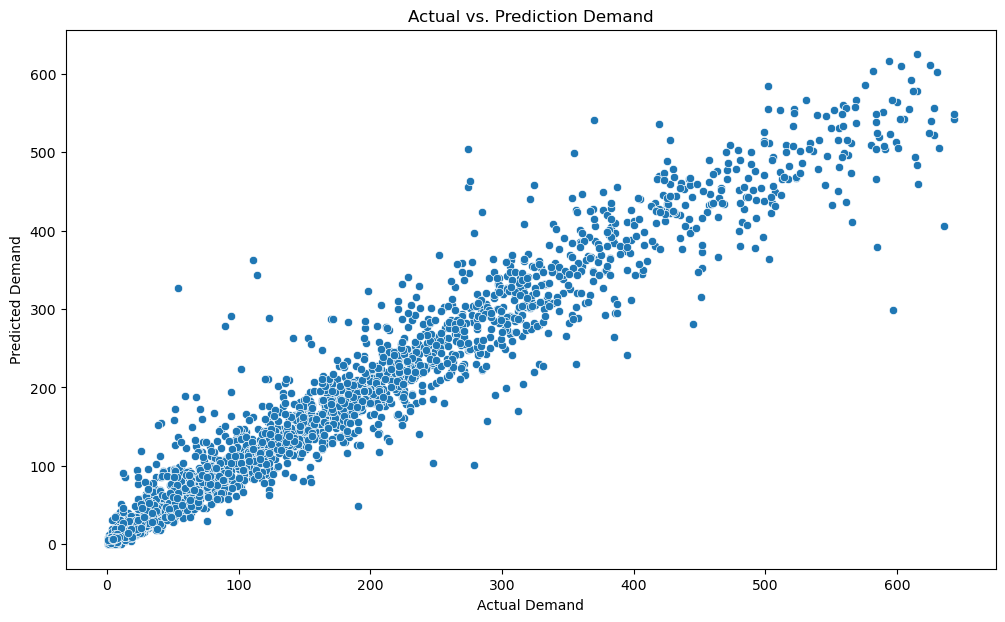

In [ ]:
plt.figure(figsize=(12, 7))
plot = sns.scatterplot(x=y_test_wo_outliers, y=y_pred_xgb_tuning_wo_outliers).set(title='Actual vs. Prediction Demand',
                                               xlabel='Actual Demand',
                                               ylabel='Predicted Demand');

Plot ini menunjukkan hubungan antara demand sebenarnya dan demand prediksi suatu barang atau jasa. Titik-titik yang lebih dekat pada garis diagonal dari kiri bawah ke kanan atas menandakan akurasi prediksi model yang baik. Dari plot ini, terlihat tren positif yang jelas, yang mengindikasikan bahwa model secara umum memiliki akurasi prediksi yang baik untuk berbagai demand. Namun, penyebaran titik-titik, terutama di kisaran demand yang lebih tinggi, menunjukkan bahwa model memiliki variabilitas dalam akurasi pada tingkat demand yang berbeda. Hal ini menunjukkan perlunya kalibrasi ulang model untuk rentang harga yang lebih tinggi atau pengaruh outlier terhadap performa model.

Adanya nilai-nilai error yang cukup tinggi membuat perbedaan yang cukup signifikan antara nilai RMSE dan MAE. Hal ini dapat tergambarkan pula pada plot di atas, di mana terdapat harga aktual yang rendah tapi diprediksi jauh lebih tinggi (overestimation), dan juga sebaliknya (underestimation). Akan tetapi, nilai MAPE yang didapat, yaitu sekitar 29% menjadikan model ini dapat dikategorikan ke dalam 'reasonable forecasting' (Lewis, 1982).

*Source: Lewis, C. D. (1982). Industrial and business forecasting methods: A practical guide to exponential smoothing and curve fitting*

Error Plot

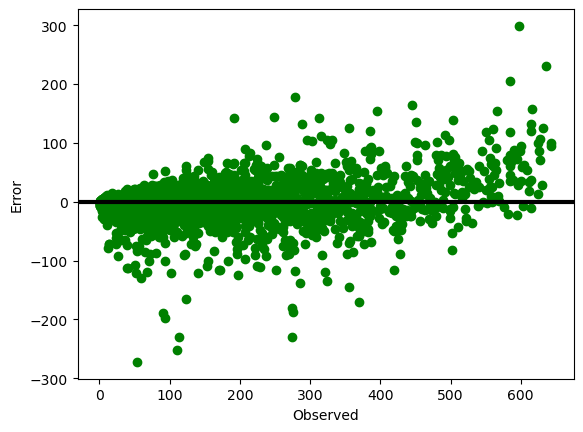

In [ ]:
error = y_test_wo_outliers - y_pred_xgb_tuning_wo_outliers
fig, ax = plt.subplots()
ax.scatter(y_test_wo_outliers, error, color = 'green')
ax.axhline(lw=3, color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Error')
plt.show()

- Error cenderung memiliki variabilitas yang konsisten di seluruh rentang nilai observasi, yang merupakan indikasi bahwa varian error (residu) konstan (homoskedastisitas). Ini adalah tanda bahwa model memodelkan variabilitas data dengan efektif.
- Secara keseluruhan, plot menunjukkan bahwa model cukup baik dalam memprediksi data dengan tidak adanya bias sistematis yang jelas.

# Feature Importances

Feature importance adalah sebuah teknik yang digunakan untuk menentukan pengaruh atau kontribusi dari setiap fitur (variabel independen) terhadap prediksi model dalam machine learning. Fitur-fitur yang memiliki tingkat pentingnya tinggi dianggap lebih berpengaruh terhadap keputusan model, sedangkan fitur dengan tingkat pentingnya rendah memiliki sedikit atau tidak ada pengaruh signifikan terhadap hasil yang diprediksi oleh model.

Untuk dapat mengetahui sebenarnya fitur apa saja yang sangat memengaruhi target (demand), kita dapat mengeceknya melalui function feature_importances_.

<Axes: title={'center': 'Feature Importances'}>

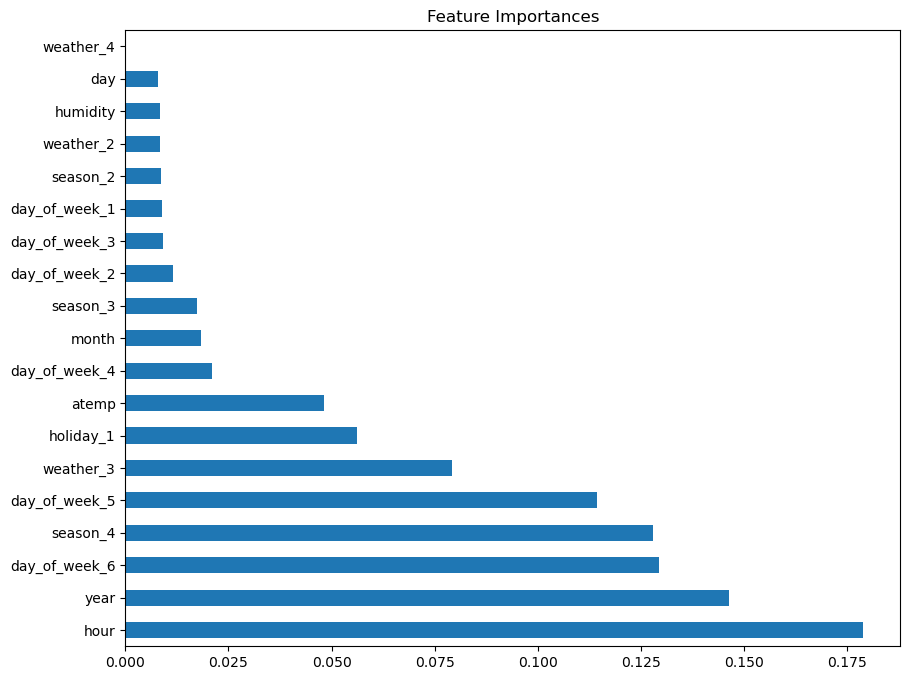

In [ ]:
# Plot feature importances
feature_imp = pd.Series(xgb_tuning_wo_outliers['model'].feature_importances_, df_oh_wo_outliers.drop('total_rented_bikes', axis=1).columns).sort_values(ascending = False)
plt.figure(figsize=(10, 8))
feature_imp.plot(kind='barh', title='Feature Importances')

- Fitur `hour` memiliki pengaruh tertinggi yang menunjukkan bahwa jam dalam sehari sangat mempengaruhi target.
- Fitur `year` juga memiliki kepentingan yang signifikan, menunjukkan bahwa terdapat perbedaan atau tren tahunan yang penting dalam data.
- Berbagai hari dalam seminggu (`day_of_week_6` dan `day_of_week_5`) memiliki pengaruh besar terhadap demand, menunjukkan bahwa hari tertentu mungkin lebih signifikan dibanding yang lain.
- Fitur `weather_3` (hujan ringan) dan `season_4` (gugur) juga berpengaruh besar terhadap besarnya demand
- Fitur `holiday_1` dan `atemp` memiliki pengaruh yang moderat terhadap besarnya demand sepeda per jam.

# Conclusion

- `hour`, `year`, `day_of_week`, `season`, dan `weather` merupakan variabel yang paling berpengaruh terhadap demand
- Namun, keberadaan beberapa outliers menunjukkan bahwa model dapat ditingkatkan, mungkin melalui pendekatan yang lebih canggih dalam pengolahan data atau pemilihan fitur, serta peningkatan tuning model.
- Berdasarkan hasil analisis menggunakan model XGBoost Regressor, ditemukan bahwa model ini cukup efektif dalam memprediksi dengan nilai RMSLE sebesar 0.351265, RMSE sebesar 37.211688, MAE sebesar 23.125309, dan MAPE sebesar 29.0574%. Walaupun performa ini menunjukkan tingkat ketepatan yang lumayan, tetapi nilai MAPE yang hampir mencapai 30% mengindikasikan bahwa model mungkin mengalami kesulitan dalam situasi atau data tertentu, yang bisa menyebabkan estimasi harga yang meleset cukup signifikan dari nilai sebenarnya.
- Metrik evaluasi yang digunakan pada model adalah nilai RMSLE, RMSE, MAE, dan MAPE. Jika ditinjau dari nilai MAPE yang dihasilkan oleh model setelah dilakukan hyperparameter tuning, yaitu sebesar ~29%, kita dapat menyimpulkan bahwa bila nanti model yang kita buat ini digunakan untuk memperkirakan hourly demand pada rentang nilai seperti yang dilatih terhadap model, maka perkiraan demandnya rata-rata akan meleset kurang lebih sebesar 29% dari demand seharusnya. Selain itu, jika ditinjau dari MAE, perkiraan demandnya rata-rata akan meleset 23 unit sepeda.
- Kesalahan rata-rata 23 unit menunjukkan bahwa pada setiap jam, model bisa salah memperkirakan jumlah sepeda yang dibutuhkan sebanyak 23 unit. Angka ini memberikan panduan operasional yang konkret. Misalnya, mempersiapkan sepeda cadangan untuk mengantisipasi permintaan yang tidak tepat sesuai prediksi.

# Recommendation for Model Improvement
- Mengecek prediksi mana saja yang memiliki nilai error yang tinggi. Kita dapat mengelompokkan error tersebut ke dalam grup overestimation dan underestimation, lalu memilih 5% error paling ekstrim saja untuk tiap grup. Nantinya pengelompokkan akan menjadi 3 grup, yaitu overestimation (5%), underestimation (5%), dan grup mayoritas yang error-nya mendekati nilai mean (90%). Setelahnya kita bisa mengecek hubungan antara error tersebut dengan tiap variabel independen. Pada akhirnya kita dapat mengetahui sebenarnya variabel mana saja dan aspek apa yang menyebabkan model menghasilkan error yang tinggi, sehingga kita bisa melakukan training ulang dengan penerapan feature engineering lainnya.
- Kumpulkan dan integrasikan data tambahan yang dapat mempengaruhi demand, seperti kecepatan angin, event lokal, dan data lalu lintas. Memasukkan variabel-variabel ini dapat membantu model lebih akurat dalam memprediksi fluktuasi demand.
- Eksplorasi penggunaan teknik advanced seperti neural networks atau deep learning yang mungkin dapat menangkap pola kompleks dalam data yang tidak dapat dikenali oleh model-model tradisional.
- Lakukan A/B testing dengan versi model yang berbeda untuk melihat mana yang paling efektif dalam operasional nyata. Hal ini tidak hanya validasi keakuratan model, tetapi juga keefektifannya dalam penggunaan sehari-hari.

# Bisnis Recommendation
- Mengingat MAE menunjukkan bahwa model dapat meleset sekitar 23 sepeda per jam, sebaiknya perusahaan mempertimbangkan untuk menyediakan stok sepeda tambahan di lokasi-lokasi strategis. Hal ini akan mengurangi risiko kehabisan stok sepeda saat permintaan meningkat tiba-tiba, terutama pada jam-jam sibuk atau saat event-event khusus.
- Karena `hour` sangat berpengaruh terhadap demand, pertimbangkan untuk menetapkan tarif dinamis di jam-jam khusus. Misalkan di rush hour, tingkatkan biaya rental sepeda sebesar 5%.
- Lokasi penyimpanan sepeda harus ditinjau ulang untuk memastikan bahwa sepeda ditempatkan di lokasi yang paling mungkin mengalami peningkatan permintaan. Hal ini bisa berdasarkan analisis lebih mendalam tentang kesalahan prediksi model di berbagai lokasi dan waktu.
- Analisis lebih lanjut mengenai kesalahan prediksi di jam-jam tertentu dan lokasi tertentu dapat membantu dalam mengoptimalkan penempatan sepeda. Penyesuaian ini tidak hanya berdasarkan demand yang diprediksi tetapi juga memperhitungkan pola kesalahan prediksi yang teridentifikasi.
- Menggunakan data dari prediksi untuk meluncurkan program loyalitas atau promosi pada waktu-waktu tertentu dapat meningkatkan penggunaan dan mendorong lebih banyak registrasi pengguna baru.

# Profit Estimation
Misalkan dengan demand prediction yang lebih baik, biaya operasional berkurang 10% akibat sumber daya yang terkelola dengan baik. Dengan terpenuhinya demand customer, anggap jumlah customer meningkat 15% per hari. Kemudian, dengan adanya dynamic pricing, profit bisnis meningkat 2.5%.

**Original Scenario**:

Total Revenue per day without model = USD1,000

Total Operational Costs per day without model = USD200

**With Predictive Model**:

Reduced Costs by 10% = USD180

Increased Revenue by 15% = USD1,150

**With Dynamic Pricing**:

Increased Revenue by 2.5% = USD25


**Profit Calculation**:

Original Profit = USD800 per day

New Profit = USD1150 + USD25 - USD180 = USD995 per day

**Profit harian meningkat sebesar 24.375%**.

# Recommended Model
Karena XGB Regressor menunjukkan hasil paling menjanjikan, maka model terbaik adalah XGB Regressor yang dimodelkan terhadap data tanpa outliers.

In [ ]:
import pickle
random_xgb_wo_outliers.best_estimator_
estimator = Pipeline([('model', random_xgb_wo_outliers.best_estimator_)])
estimator.fit(X_train_wo_outliers, y_train_wo_outliers)

pickle.dump(estimator, open('XGB_Bike.sav', 'wb'))

In [ ]:
filename = 'XGB_Bike.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
np.sqrt(mean_squared_log_error(y_test_wo_outliers, np.maximum(0, loaded_model.predict(X_test_wo_outliers))))

0.3512650942739689